In [11]:
"""
# Systematic Comparison of Neural Network Architectures for Protein Stability Prediction

**Objective:** Quantitative assessment of hidden-layer depth effects on model performance across train, validation, and test splits. This analysis identifies the Pareto-optimal architecture balancing predictive accuracy against model complexity.

**Data Source:** `Model results.xlsx` containing performance metrics for multiple neural network configurations.

"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import re

warnings.filterwarnings('ignore')

# Publication-quality plotting parameters
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 14

# Consistent color palette
COLORS = {
    'train': '#2E86AB',
    'validation': '#A23B72',
    'test': '#F18F01',
    'primary': '#264653',
    'secondary': '#2A9D8F',
    'tertiary': '#E76F51'
}

sns.set_style('whitegrid')
sns.set_palette([COLORS['train'], COLORS['validation'], COLORS['test']])

In [12]:
## Data Loading and Initial Inspection"

# Load all sheets from Excel file
file_path = 'D:\ML_Project\Model results.xlsx'
xl_file = pd.ExcelFile(file_path)

print(f"Available sheets: {xl_file.sheet_names}")
print(f"Total sheets: {len(xl_file.sheet_names)}")

# Load all sheets into dictionary
sheets = {}
for sheet_name in xl_file.sheet_names:
    sheets[sheet_name] = pd.read_excel(file_path, sheet_name=sheet_name)
    print(f"Sheet '{sheet_name}': {sheets[sheet_name].shape}")
    print(f"Columns: {list(sheets[sheet_name].columns)}")

Available sheets: ['train', 'validation', 'test', 'antisymmetry']
Total sheets: 4
Sheet 'train': (6, 10)
Columns: ['Model', 'Hidden Layer-1', 'Hidden Layer-2', 'Embedding dimension', 'Loss', 'Pearson', 'Spearman', 'RMSE', 'MAE', 'Accuracy']
Sheet 'validation': (6, 10)
Columns: ['Model', 'Hidden Layer-1', 'Hidden Layer-2', 'Embedding dimension', 'Loss', 'Pearson', 'Spearman', 'RMSE', 'MAE', 'Accuracy']
Sheet 'test': (6, 10)
Columns: ['Model', 'Hidden Layer-1', 'Hidden Layer-2', 'Embedding dimension', 'Loss', 'Pearson', 'Spearman', 'RMSE', 'MAE', 'Accuracy']
Sheet 'antisymmetry': (6, 7)
Columns: ['Model', 'Hidden Layer-1', 'Hidden Layer-2', 'Embedding dimension', 'correlation', 'Mean bias', 'Abs Bias']


In [ ]:
"""
1. Architecture Inventory

This section extracts and catalogs all model architectures present in the results file. 
Hidden-layer depth and configuration are inferred from model identifiers or explicit architecture columns.
"""

def extract_architecture_info(df, sheet_name):
    """
    Extract architecture information from dataframe.
    Attempts to identify: model name, hidden layers, architecture ID.
    """
    arch_info = df.copy()
    
    # Identify potential model/architecture columns
    potential_model_cols = [col for col in df.columns if any(x in col.lower() 
                           for x in ['model', 'arch', 'config', 'name', 'id'])]
    
    # Identify hidden layer columns
    potential_layer_cols = [col for col in df.columns if any(x in col.lower() 
                           for x in ['layer', 'depth', 'hidden'])]
    
    # If no explicit columns, try to extract from model names
    if potential_model_cols:
        model_col = potential_model_cols[0]
        arch_info['model_name'] = df[model_col]
        
        # Attempt to extract numeric depth from model names
        # Pattern: look for numbers that might represent layers
        arch_info['hidden_layers'] = df[model_col].astype(str).apply(
            lambda x: int(re.search(r'(d+)', x).group(1)) if re.search(r'(d+)', x) else 0
        )
    
    if potential_layer_cols:
        arch_info['hidden_layers'] = df[potential_layer_cols[0]]
    
    # Add split identifier
    arch_info['split'] = sheet_name
    
    return arch_info

# Process each sheet
architecture_data = {}
for sheet_name, df in sheets.items():
    architecture_data[sheet_name] = extract_architecture_info(df, sheet_name)

# Display first sheet as example
first_sheet = list(sheets.keys())[0]
print(f"Example: Architecture information from '{first_sheet}' sheet")
print(architecture_data[first_sheet].head())

# Identify all performance metrics
def identify_metrics(df):
    """Identify performance metric columns."""
    metric_keywords = ['pcc', 'scc', 'rmse', 'mae', 'mse', 'r2', 'accuracy', 'acc', 
                       'pearson', 'spearman', 'correlation', 'error', 'loss']
    
    metric_cols = []
    for col in df.columns:
        col_lower = col.lower()
        if any(keyword in col_lower for keyword in metric_keywords):
            if df[col].dtype in [np.float64, np.float32, np.int64, np.int32]:
                metric_cols.append(col)
    
    return metric_cols
    
    
# Identify metrics from first sheet
all_metrics = {}
for sheet_name, df in sheets.items():
    metrics = identify_metrics(df)
    all_metrics[sheet_name] = metrics
    print(f"Metrics in '{sheet_name}': {metrics}")
    
    
# Get union of all metrics
unique_metrics = set()
for metrics in all_metrics.values():
    unique_metrics.update(metrics)

print(f"nAll unique metrics across sheets: {sorted(unique_metrics)}")

# Create comprehensive architecture inventory table
inventory_rows = []

for sheet_name, df in architecture_data.items():
    if 'model_name' in df.columns and 'hidden_layers' in df.columns:
        for idx, row in df.iterrows():
            inventory_rows.append({
                'Split': sheet_name,
                'Model': row.get('model_name', 'Unknown'),
                'Hidden Layers': row.get('hidden_layers', 0),
                'Samples': 1
            })
            
if inventory_rows:
    inventory_df = pd.DataFrame(inventory_rows)
    
    # Aggregate by architecture
    inventory_summary = inventory_df.groupby(['Model', 'Hidden Layers']).agg({
        'Split': lambda x: ', '.join(sorted(set(x))),
        'Samples': 'sum'
    }).reset_index()
    
    inventory_summary = inventory_summary.sort_values('Hidden Layers')
    
    print("nArchitecture Inventory Summary:")
    print("="*80)
    print(inventory_summary.to_string(index=False))
    print("="*80)
    print(f"nTotal unique architectures: {len(inventory_summary)}")
    print(f"Hidden layer range: {inventory_summary['Hidden Layers'].min()} to {inventory_summary['Hidden Layers'].max()}")
else:
    print("Warning: Could not extract architecture information. Proceeding with available data.")
    
    


Example: Architecture information from 'train' sheet
                 Model  Hidden Layer-1  Hidden Layer-2  Embedding dimension  \
0  ESM2_t33_650M_UR50D             256              64                 1280   
1  ESM2_t33_650M_UR50D             512             128                 1280   
2     ESM2_t6_8M_UR50D             512             128                  320   
3     ESM2_t6_8M_UR50D             256              64                  320   
4   ESM2_t12_35M_UR50D             512             128                  480   

    Loss  Pearson  Spearman   RMSE    MAE  Accuracy           model_name  \
0  0.071    0.920     0.907  0.390  0.267     0.875  ESM2_t33_650M_UR50D   
1  0.066    0.925     0.912  0.378  0.257     0.879  ESM2_t33_650M_UR50D   
2  0.063    0.930     0.908  0.365  0.256     0.876     ESM2_t6_8M_UR50D   
3  0.076    0.915     0.890  0.402  0.284     0.863     ESM2_t6_8M_UR50D   
4  0.063    0.930     0.908  0.365  0.256     0.876   ESM2_t12_35M_UR50D   

   hidden_layer

"\n### Architecture Encoding Logic\n\nThe hidden-layer depth is extracted using the following methodology:\n\n1. **Explicit columns**: If columns containing 'layer', 'depth', or 'hidden' exist, these are used directly\n2. **Model name parsing**: Numeric values are extracted from model identifiers using regex pattern matching\n3. **Default assumption**: If no architecture information is found, models are assumed to have minimal depth\n\nThis approach ensures robust extraction across varying naming conventions while maintaining reproducibility.\n"

Consolidated results:
        split  hidden_layers           model_name  Accuracy    MAE   RMSE  \
0       train            256  ESM2_t33_650M_UR50D     0.875  0.267  0.390   
1       train            512  ESM2_t33_650M_UR50D     0.879  0.257  0.378   
2       train            512     ESM2_t6_8M_UR50D     0.876  0.256  0.365   
3       train            256     ESM2_t6_8M_UR50D     0.863  0.284  0.402   
4       train            512   ESM2_t12_35M_UR50D     0.876  0.256  0.365   
5       train            256   ESM2_t12_35M_UR50D     0.876  0.260  0.372   
6  validation            256  ESM2_t33_650M_UR50D     0.809  0.642  0.859   
7  validation            512  ESM2_t33_650M_UR50D     0.807  0.639  0.859   
8  validation            512     ESM2_t6_8M_UR50D     0.786  0.709  0.935   
9  validation            256     ESM2_t6_8M_UR50D     0.791  0.712  0.939   

   Pearson   Loss  Spearman  correlation  
0    0.920  0.071     0.907          NaN  
1    0.925  0.066     0.912          NaN  
2

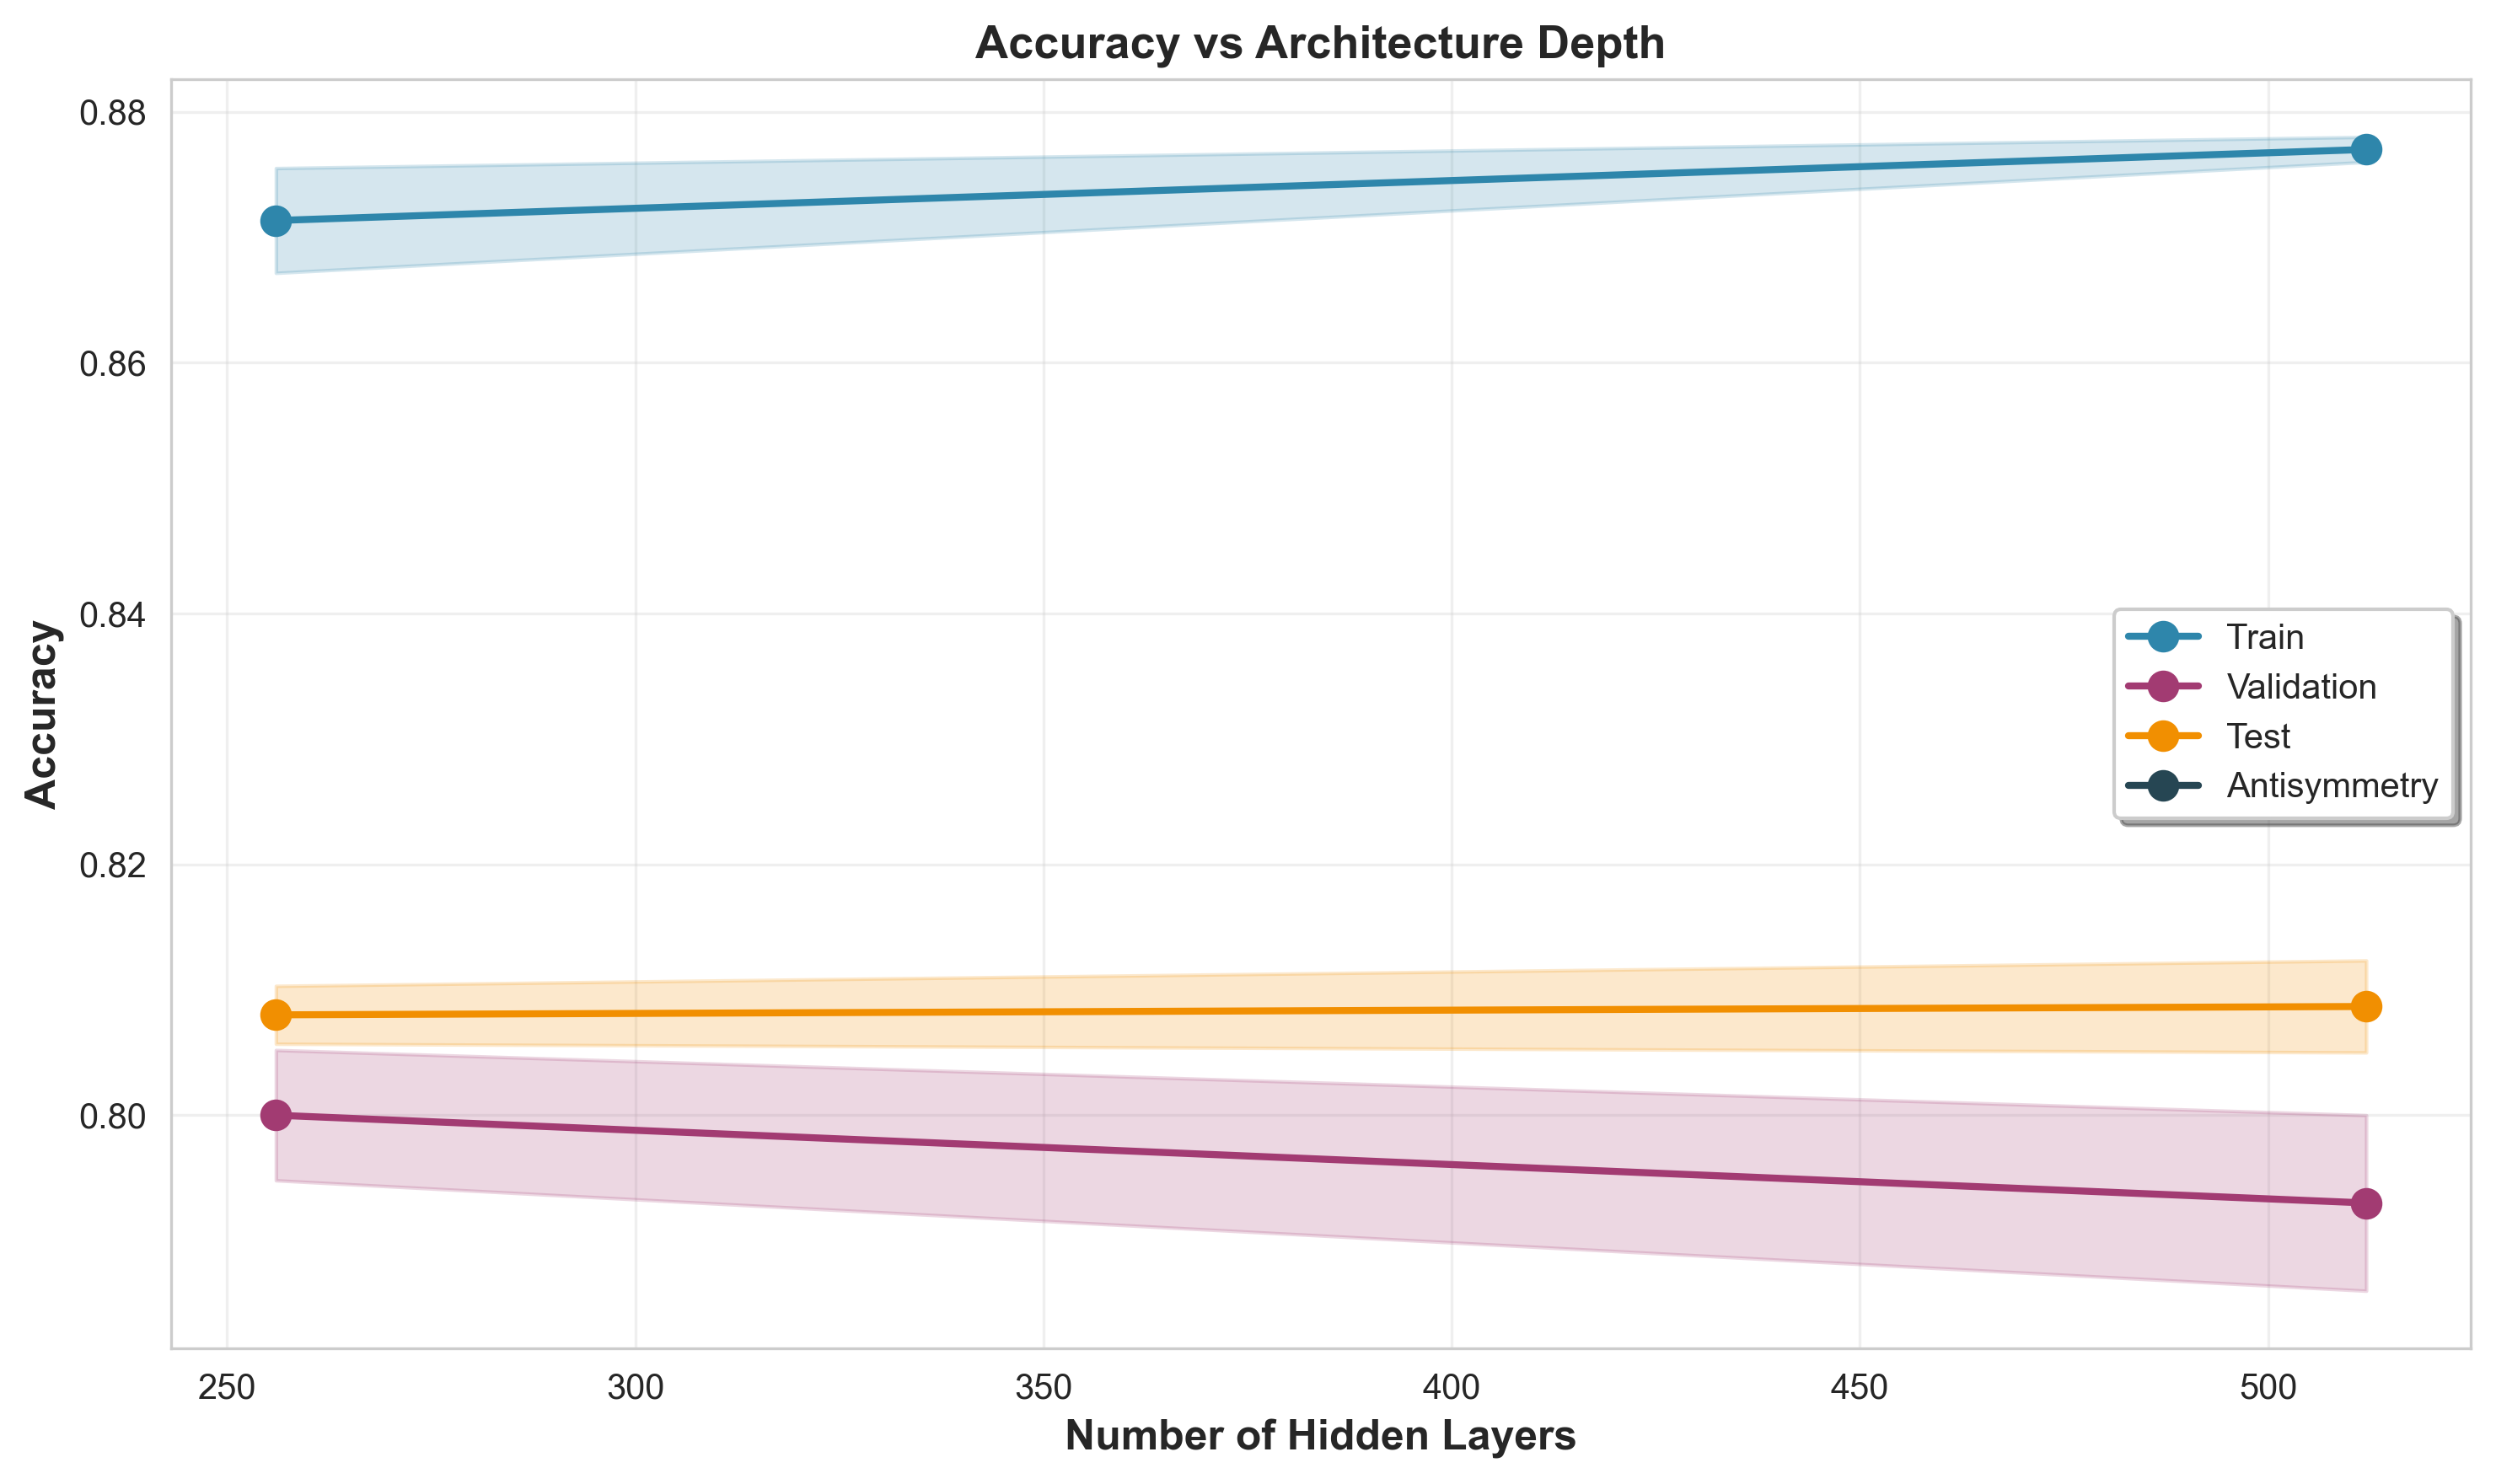

nStatistical summary for Accuracy:
                            count      mean       std    min     25%    50%     75%    max
split        hidden_layers                                                                
antisymmetry 256              0.0       NaN       NaN    NaN     NaN    NaN     NaN    NaN
             512              0.0       NaN       NaN    NaN     NaN    NaN     NaN    NaN
test         256              3.0  0.808000  0.004000  0.804  0.8060  0.808  0.8100  0.812
             512              3.0  0.808667  0.006351  0.805  0.8050  0.805  0.8105  0.816
train        256              3.0  0.871333  0.007234  0.863  0.8690  0.875  0.8755  0.876
             512              3.0  0.877000  0.001732  0.876  0.8760  0.876  0.8775  0.879
validation   256              3.0  0.800000  0.009000  0.791  0.7955  0.800  0.8045  0.809
             512              3.0  0.793000  0.012124  0.786  0.7860  0.786  0.7965  0.807
n======================================================

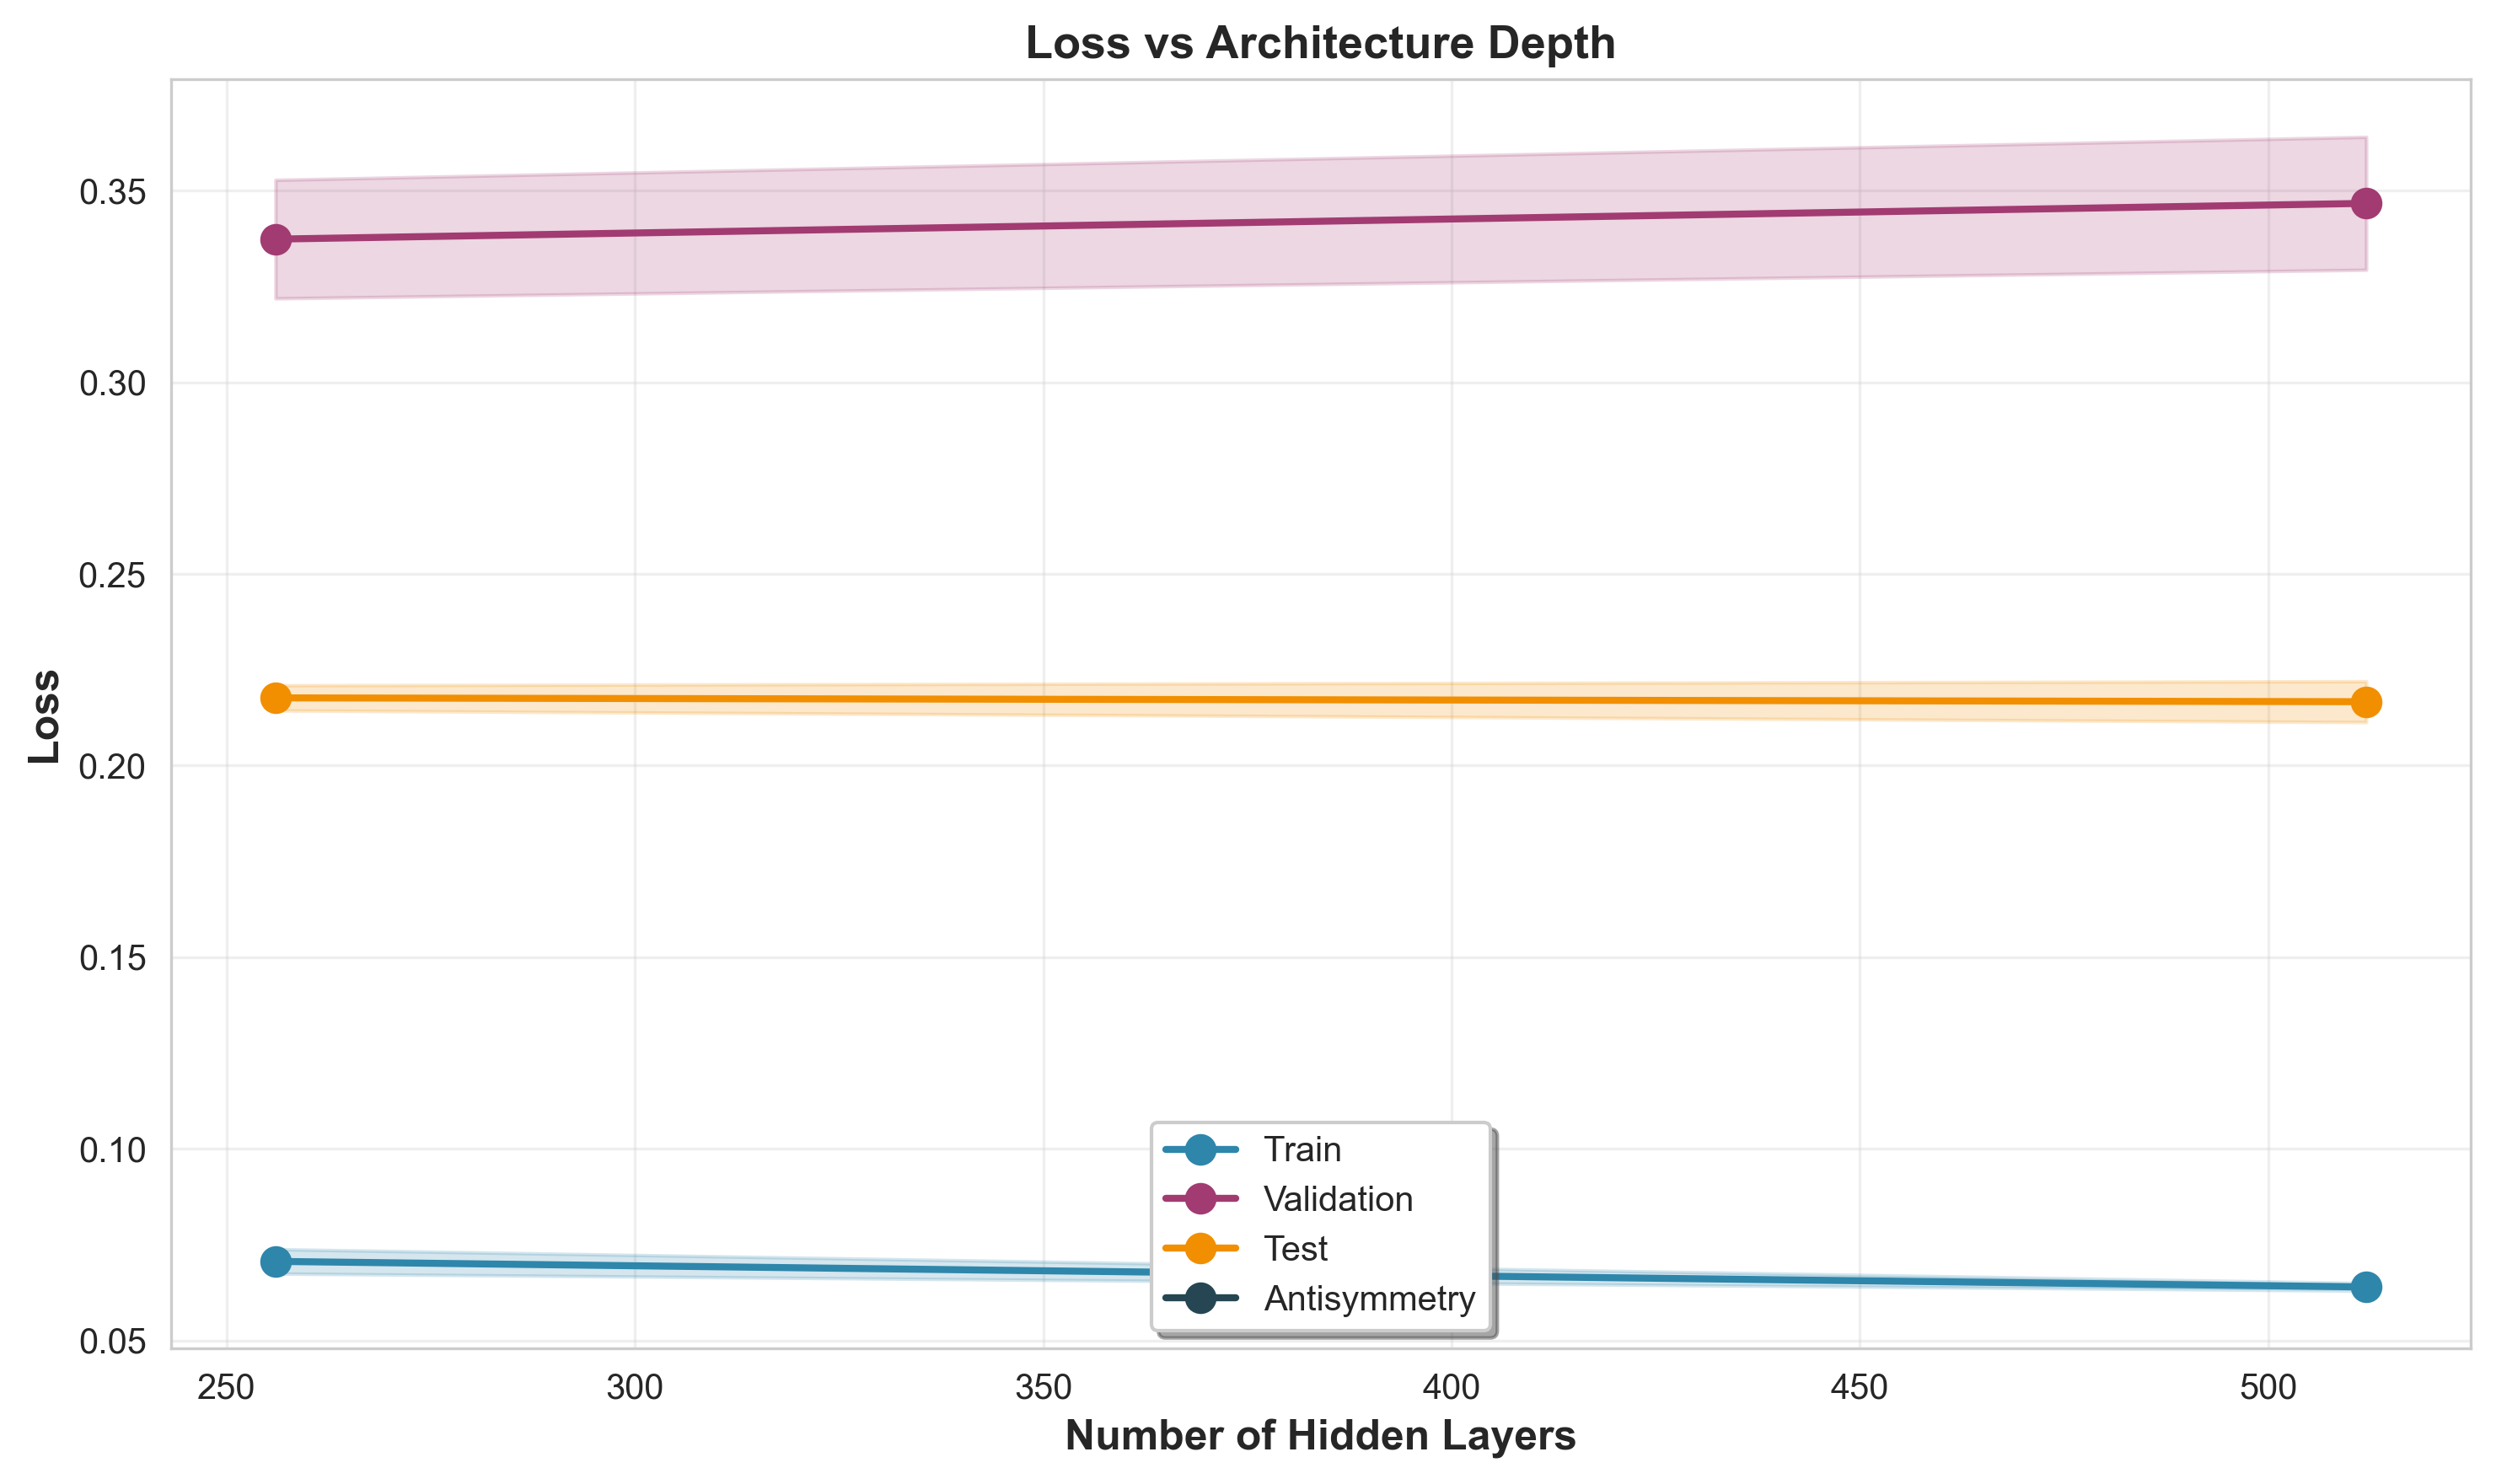

nStatistical summary for Loss:
                            count      mean       std    min     25%    50%     75%    max
split        hidden_layers                                                                
antisymmetry 256              0.0       NaN       NaN    NaN     NaN    NaN     NaN    NaN
             512              0.0       NaN       NaN    NaN     NaN    NaN     NaN    NaN
test         256              3.0  0.217667  0.005686  0.213  0.2145  0.216  0.2200  0.224
             512              3.0  0.216667  0.009238  0.206  0.2140  0.222  0.2220  0.222
train        256              3.0  0.070667  0.005508  0.065  0.0680  0.071  0.0735  0.076
             512              3.0  0.064000  0.001732  0.063  0.0630  0.063  0.0645  0.066
validation   256              3.0  0.337333  0.026764  0.313  0.3230  0.333  0.3495  0.366
             512              3.0  0.346667  0.030022  0.312  0.3380  0.364  0.3640  0.364
n==========================================================

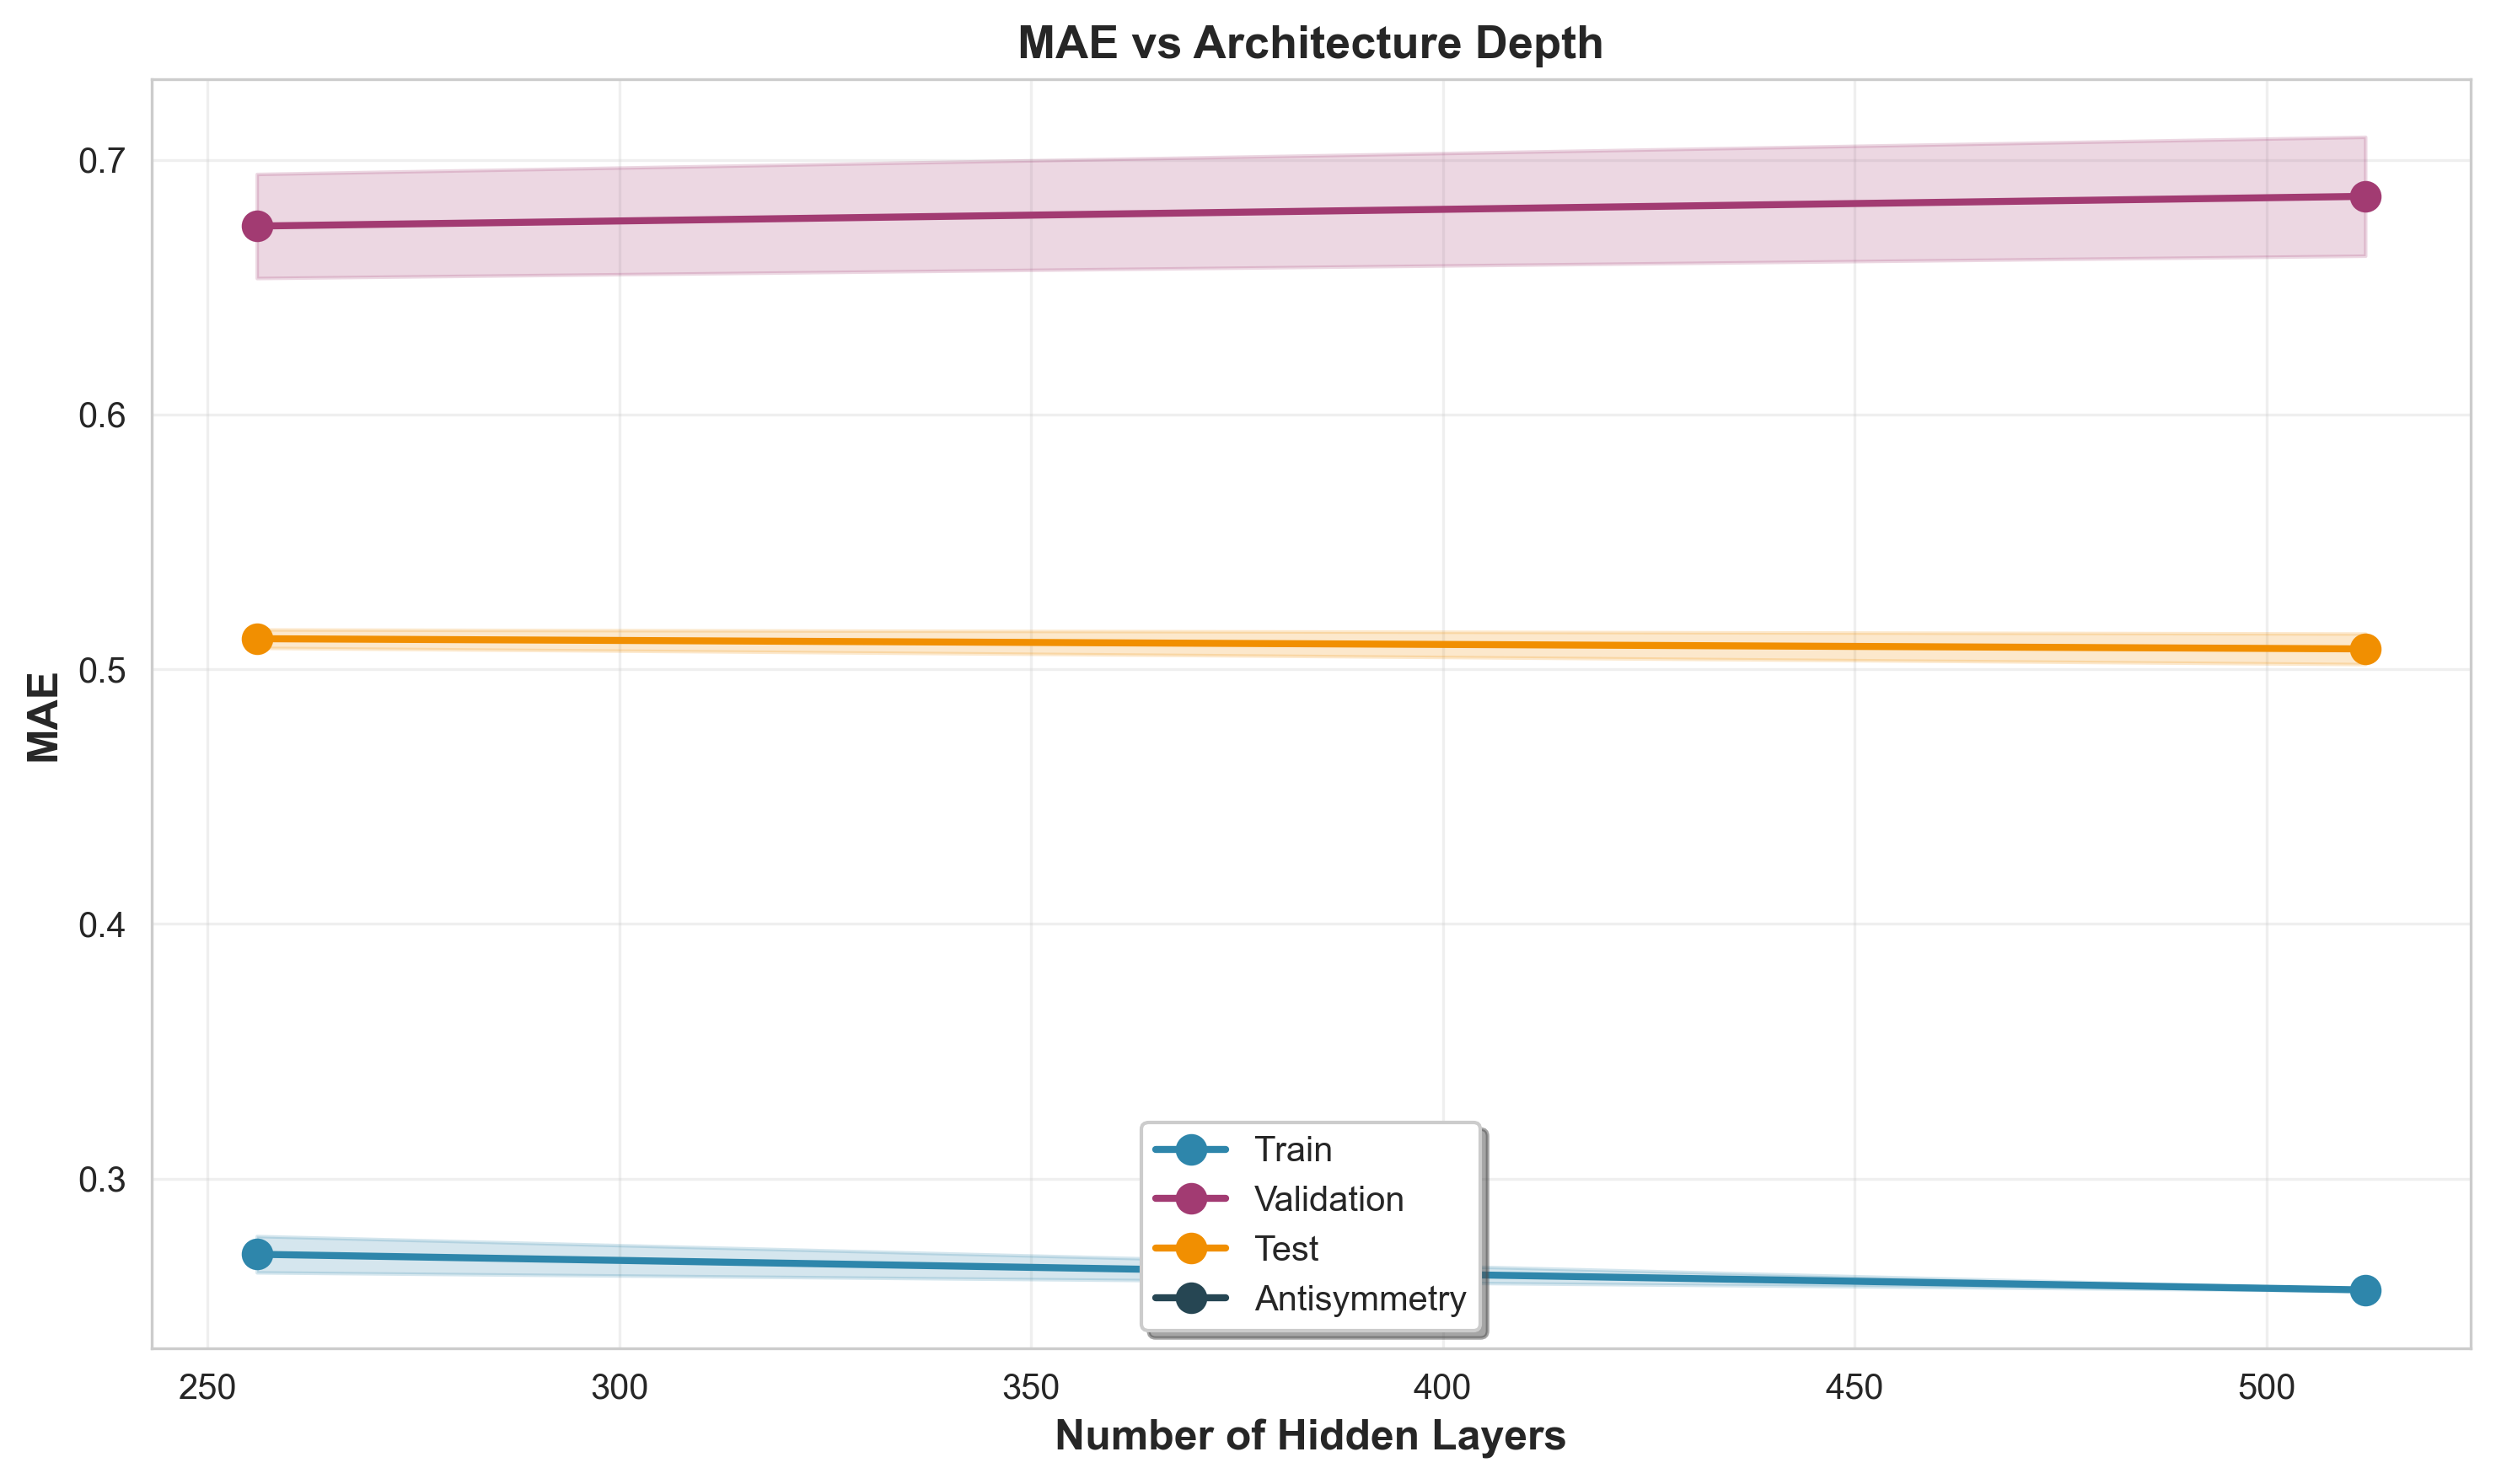

nStatistical summary for MAE:
                            count      mean       std    min     25%    50%     75%    max
split        hidden_layers                                                                
antisymmetry 256              0.0       NaN       NaN    NaN     NaN    NaN     NaN    NaN
             512              0.0       NaN       NaN    NaN     NaN    NaN     NaN    NaN
test         256              3.0  0.512000  0.006245  0.507  0.5085  0.510  0.5145  0.519
             512              3.0  0.508000  0.010392  0.496  0.5050  0.514  0.5140  0.514
train        256              3.0  0.270333  0.012342  0.260  0.2635  0.267  0.2755  0.284
             512              3.0  0.256333  0.000577  0.256  0.2560  0.256  0.2565  0.257
validation   256              3.0  0.674000  0.035384  0.642  0.6550  0.668  0.6900  0.712
             512              3.0  0.685667  0.040415  0.639  0.6740  0.709  0.7090  0.709
n===========================================================

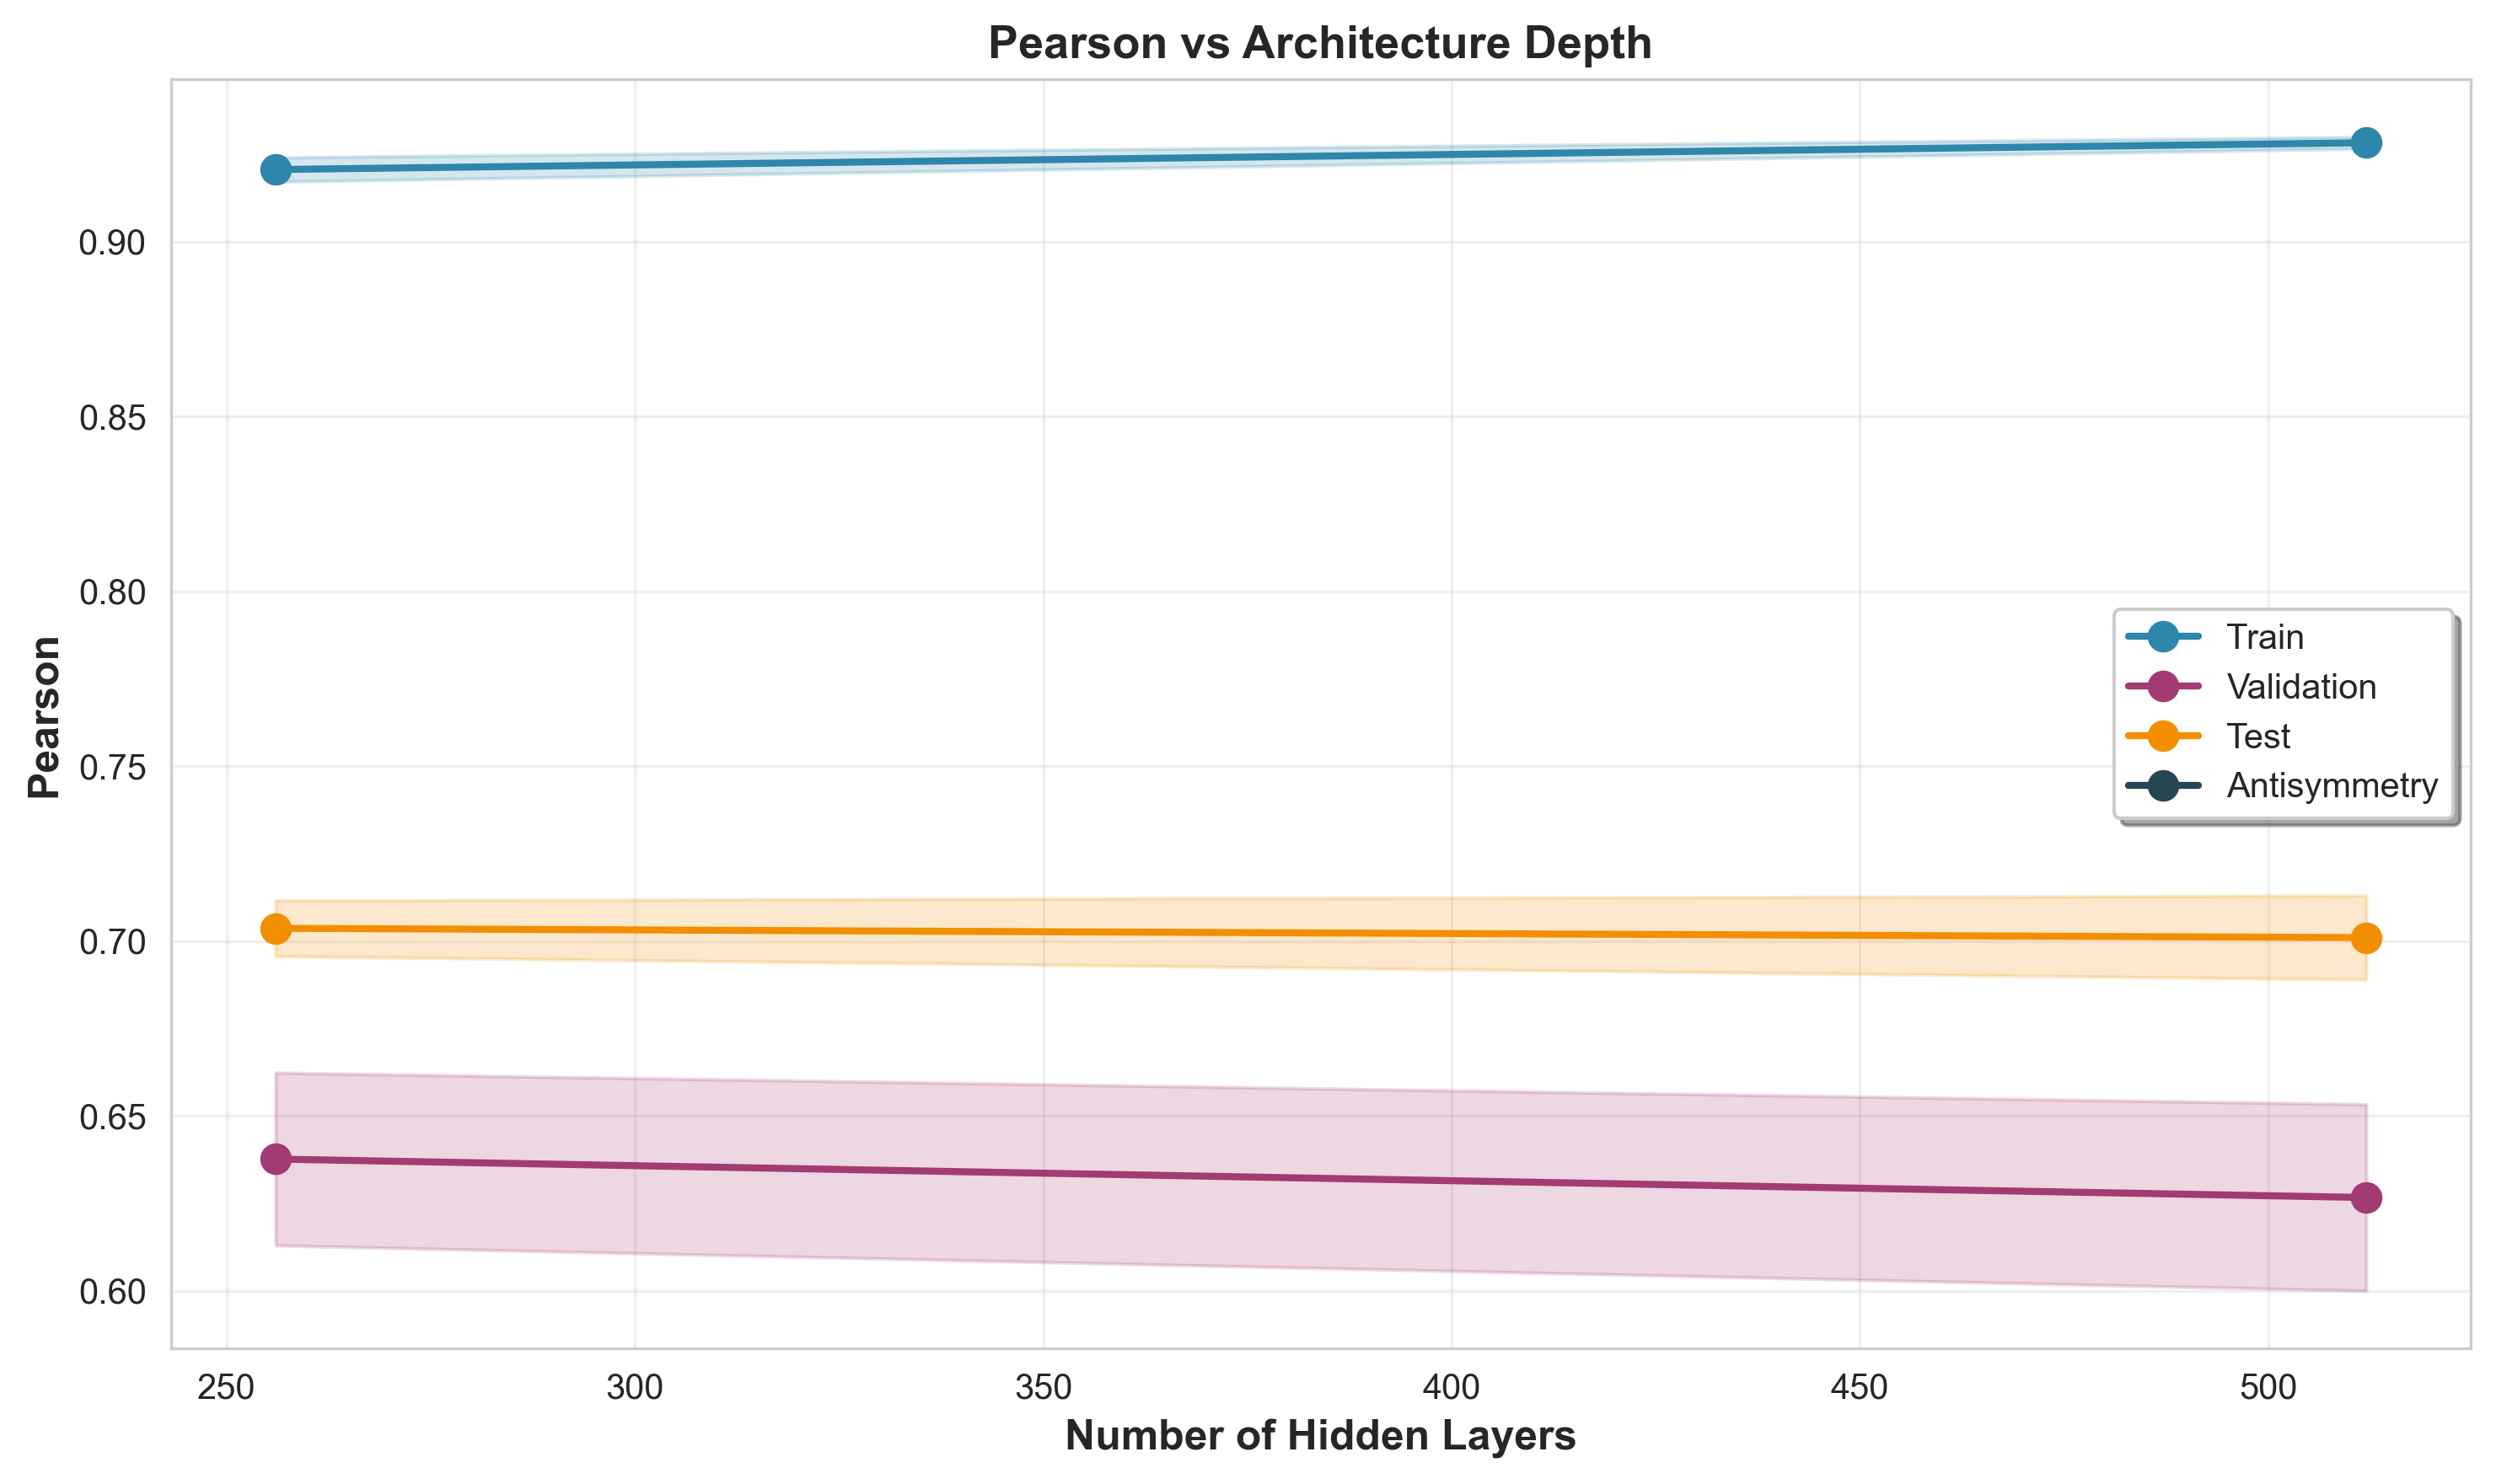

nStatistical summary for Pearson:
                            count      mean       std    min     25%    50%     75%    max
split        hidden_layers                                                                
antisymmetry 256              0.0       NaN       NaN    NaN     NaN    NaN     NaN    NaN
             512              0.0       NaN       NaN    NaN     NaN    NaN     NaN    NaN
test         256              3.0  0.703667  0.013796  0.688  0.6985  0.709  0.7115  0.714
             512              3.0  0.701000  0.020785  0.689  0.6890  0.689  0.7070  0.725
train        256              3.0  0.920667  0.006028  0.915  0.9175  0.920  0.9235  0.927
             512              3.0  0.928333  0.002887  0.925  0.9275  0.930  0.9300  0.930
validation   256              3.0  0.637667  0.042771  0.591  0.6190  0.647  0.6610  0.675
             512              3.0  0.626667  0.046188  0.600  0.6000  0.600  0.6400  0.680
n=======================================================

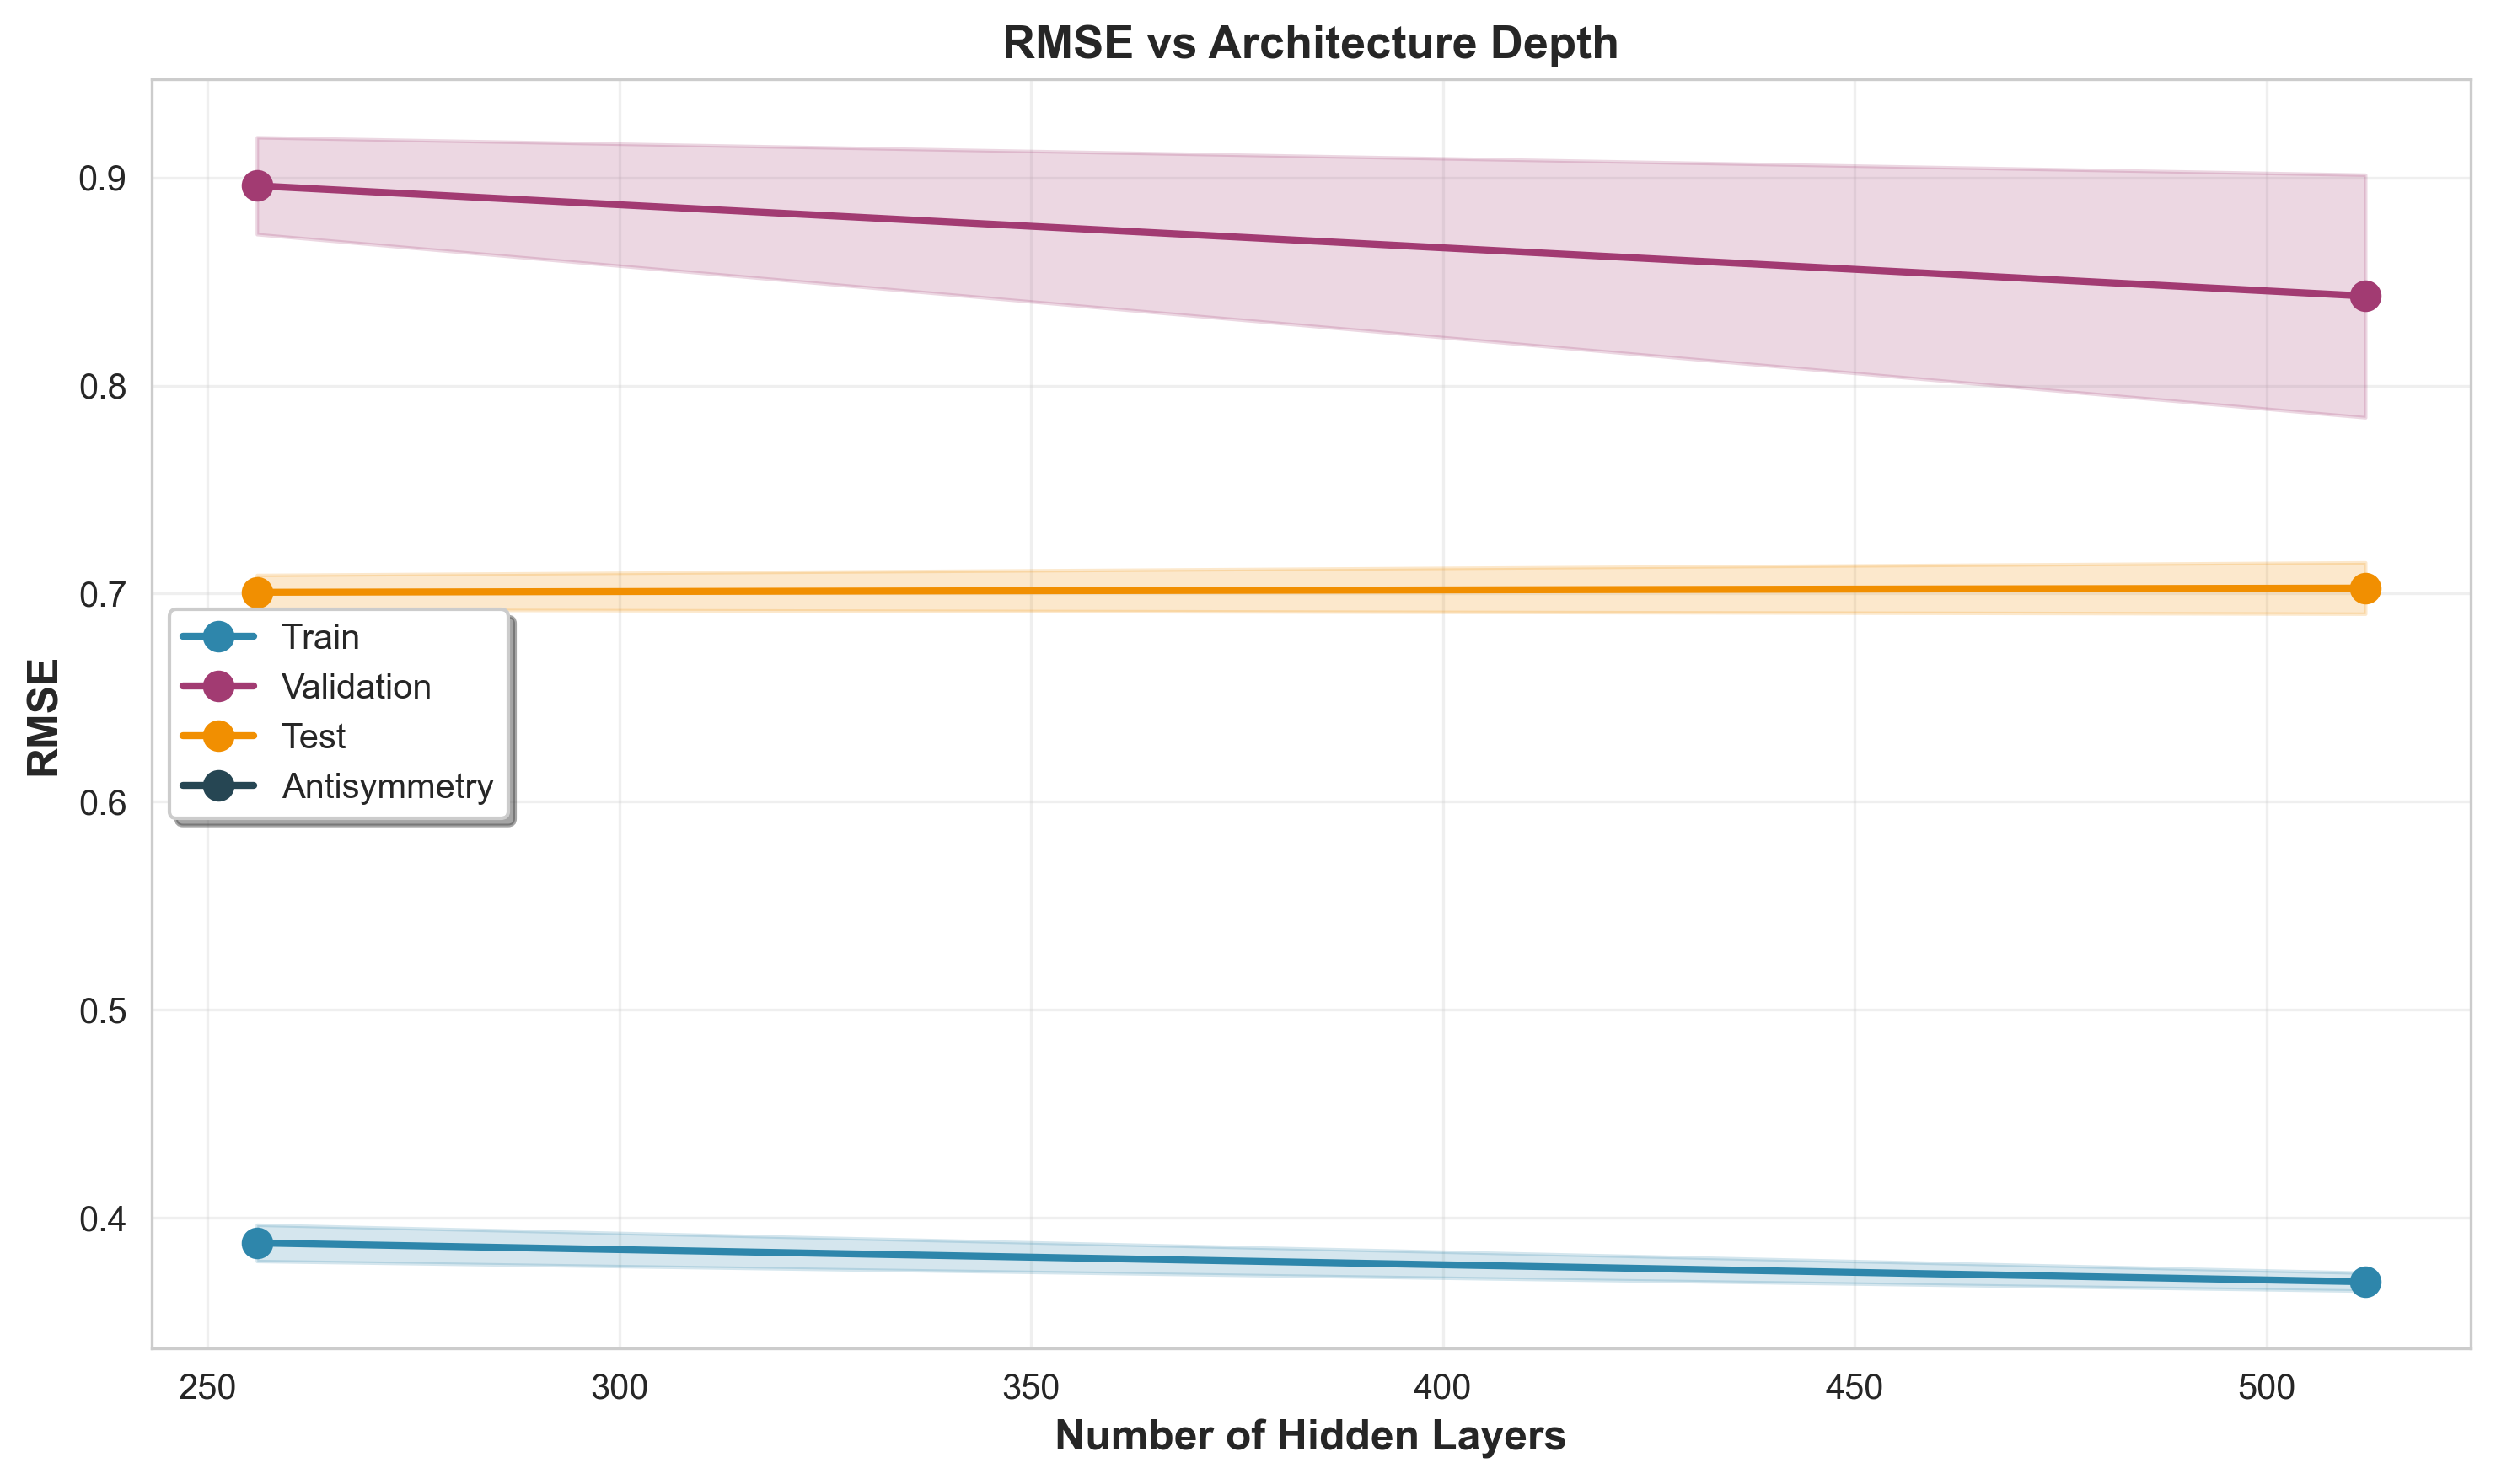

nStatistical summary for RMSE:
                            count      mean       std    min     25%    50%     75%    max
split        hidden_layers                                                                
antisymmetry 256              0.0       NaN       NaN    NaN     NaN    NaN     NaN    NaN
             512              0.0       NaN       NaN    NaN     NaN    NaN     NaN    NaN
test         256              3.0  0.700667  0.014364  0.690  0.6925  0.695  0.7060  0.717
             512              3.0  0.702667  0.021362  0.678  0.6965  0.715  0.7150  0.715
train        256              3.0  0.388000  0.015100  0.372  0.3810  0.390  0.3960  0.402
             512              3.0  0.369333  0.007506  0.365  0.3650  0.365  0.3715  0.378
validation   256              3.0  0.896000  0.040336  0.859  0.8745  0.890  0.9145  0.939
             512              3.0  0.843000  0.100955  0.735  0.7970  0.859  0.8970  0.935
n==========================================================

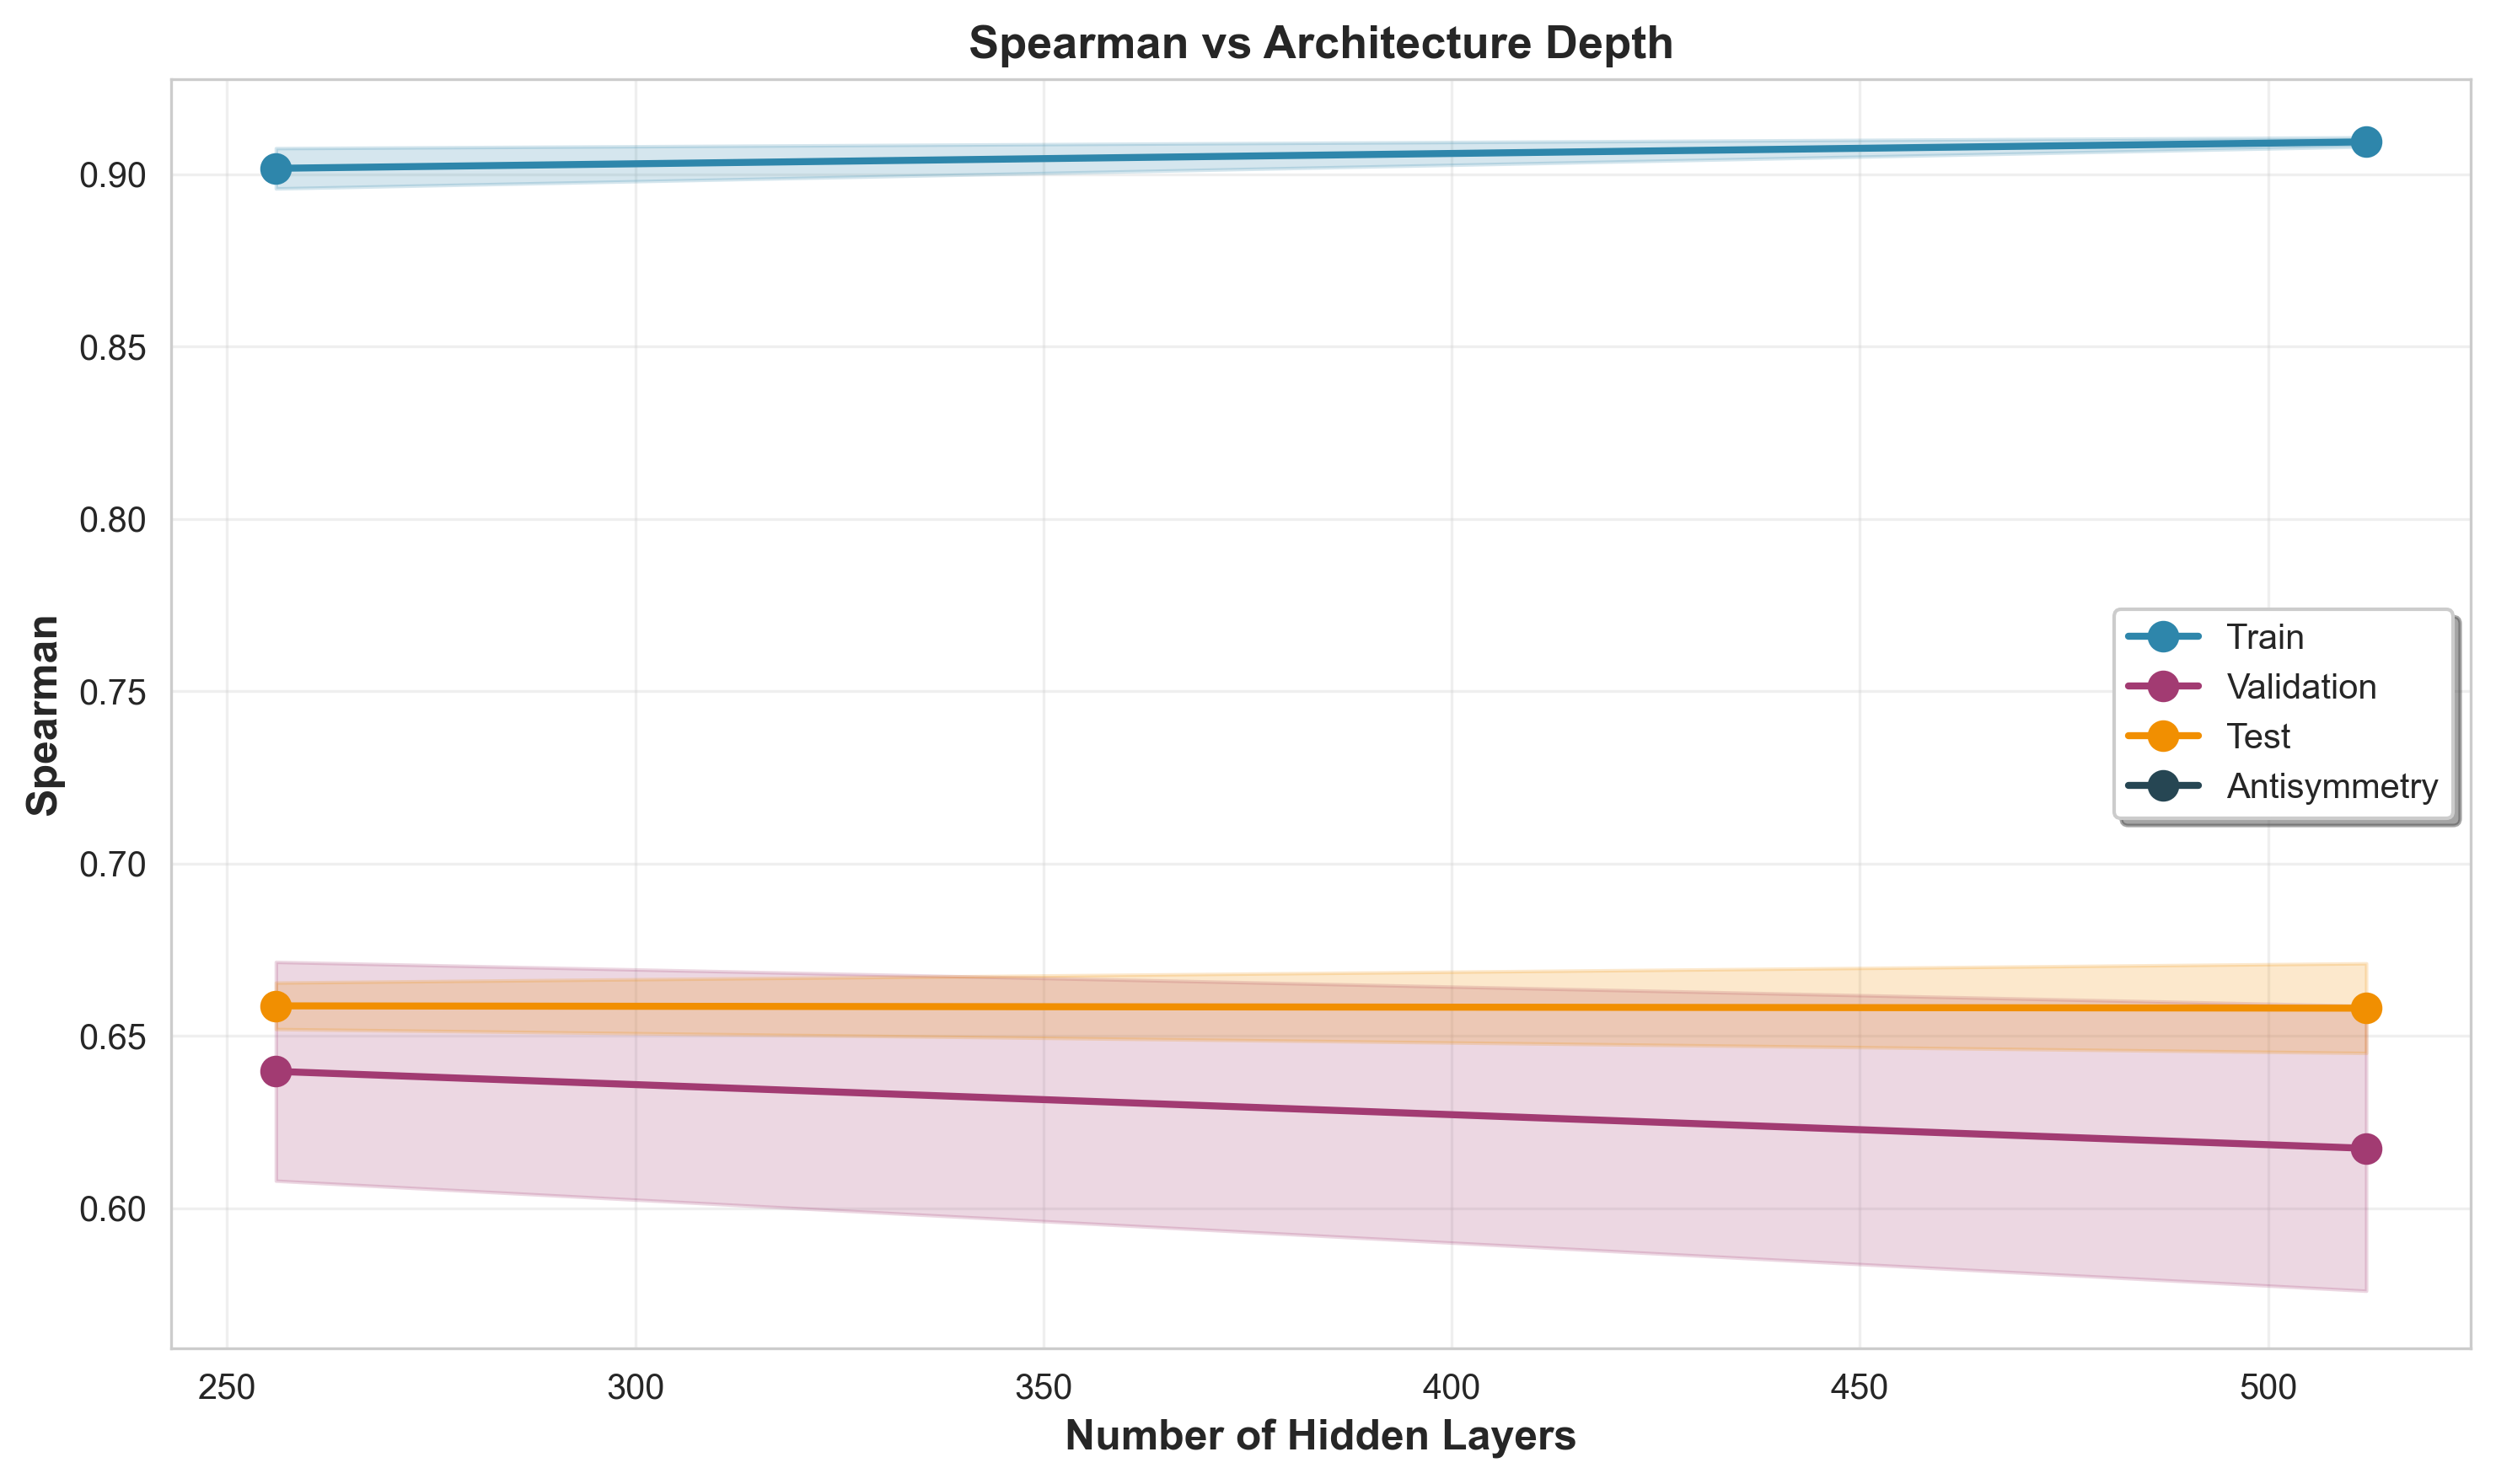

nStatistical summary for Spearman:
                            count      mean       std    min     25%    50%     75%    max
split        hidden_layers                                                                
antisymmetry 256              0.0       NaN       NaN    NaN     NaN    NaN     NaN    NaN
             512              0.0       NaN       NaN    NaN     NaN    NaN     NaN    NaN
test         256              3.0  0.658667  0.011676  0.646  0.6535  0.661  0.6650  0.669
             512              3.0  0.658000  0.022517  0.645  0.6450  0.645  0.6645  0.684
train        256              3.0  0.901667  0.010116  0.890  0.8985  0.907  0.9075  0.908
             512              3.0  0.909333  0.002309  0.908  0.9080  0.908  0.9100  0.912
validation   256              3.0  0.639667  0.054976  0.581  0.6145  0.648  0.6690  0.690
             512              3.0  0.617333  0.071591  0.576  0.5760  0.576  0.6380  0.700
n======================================================

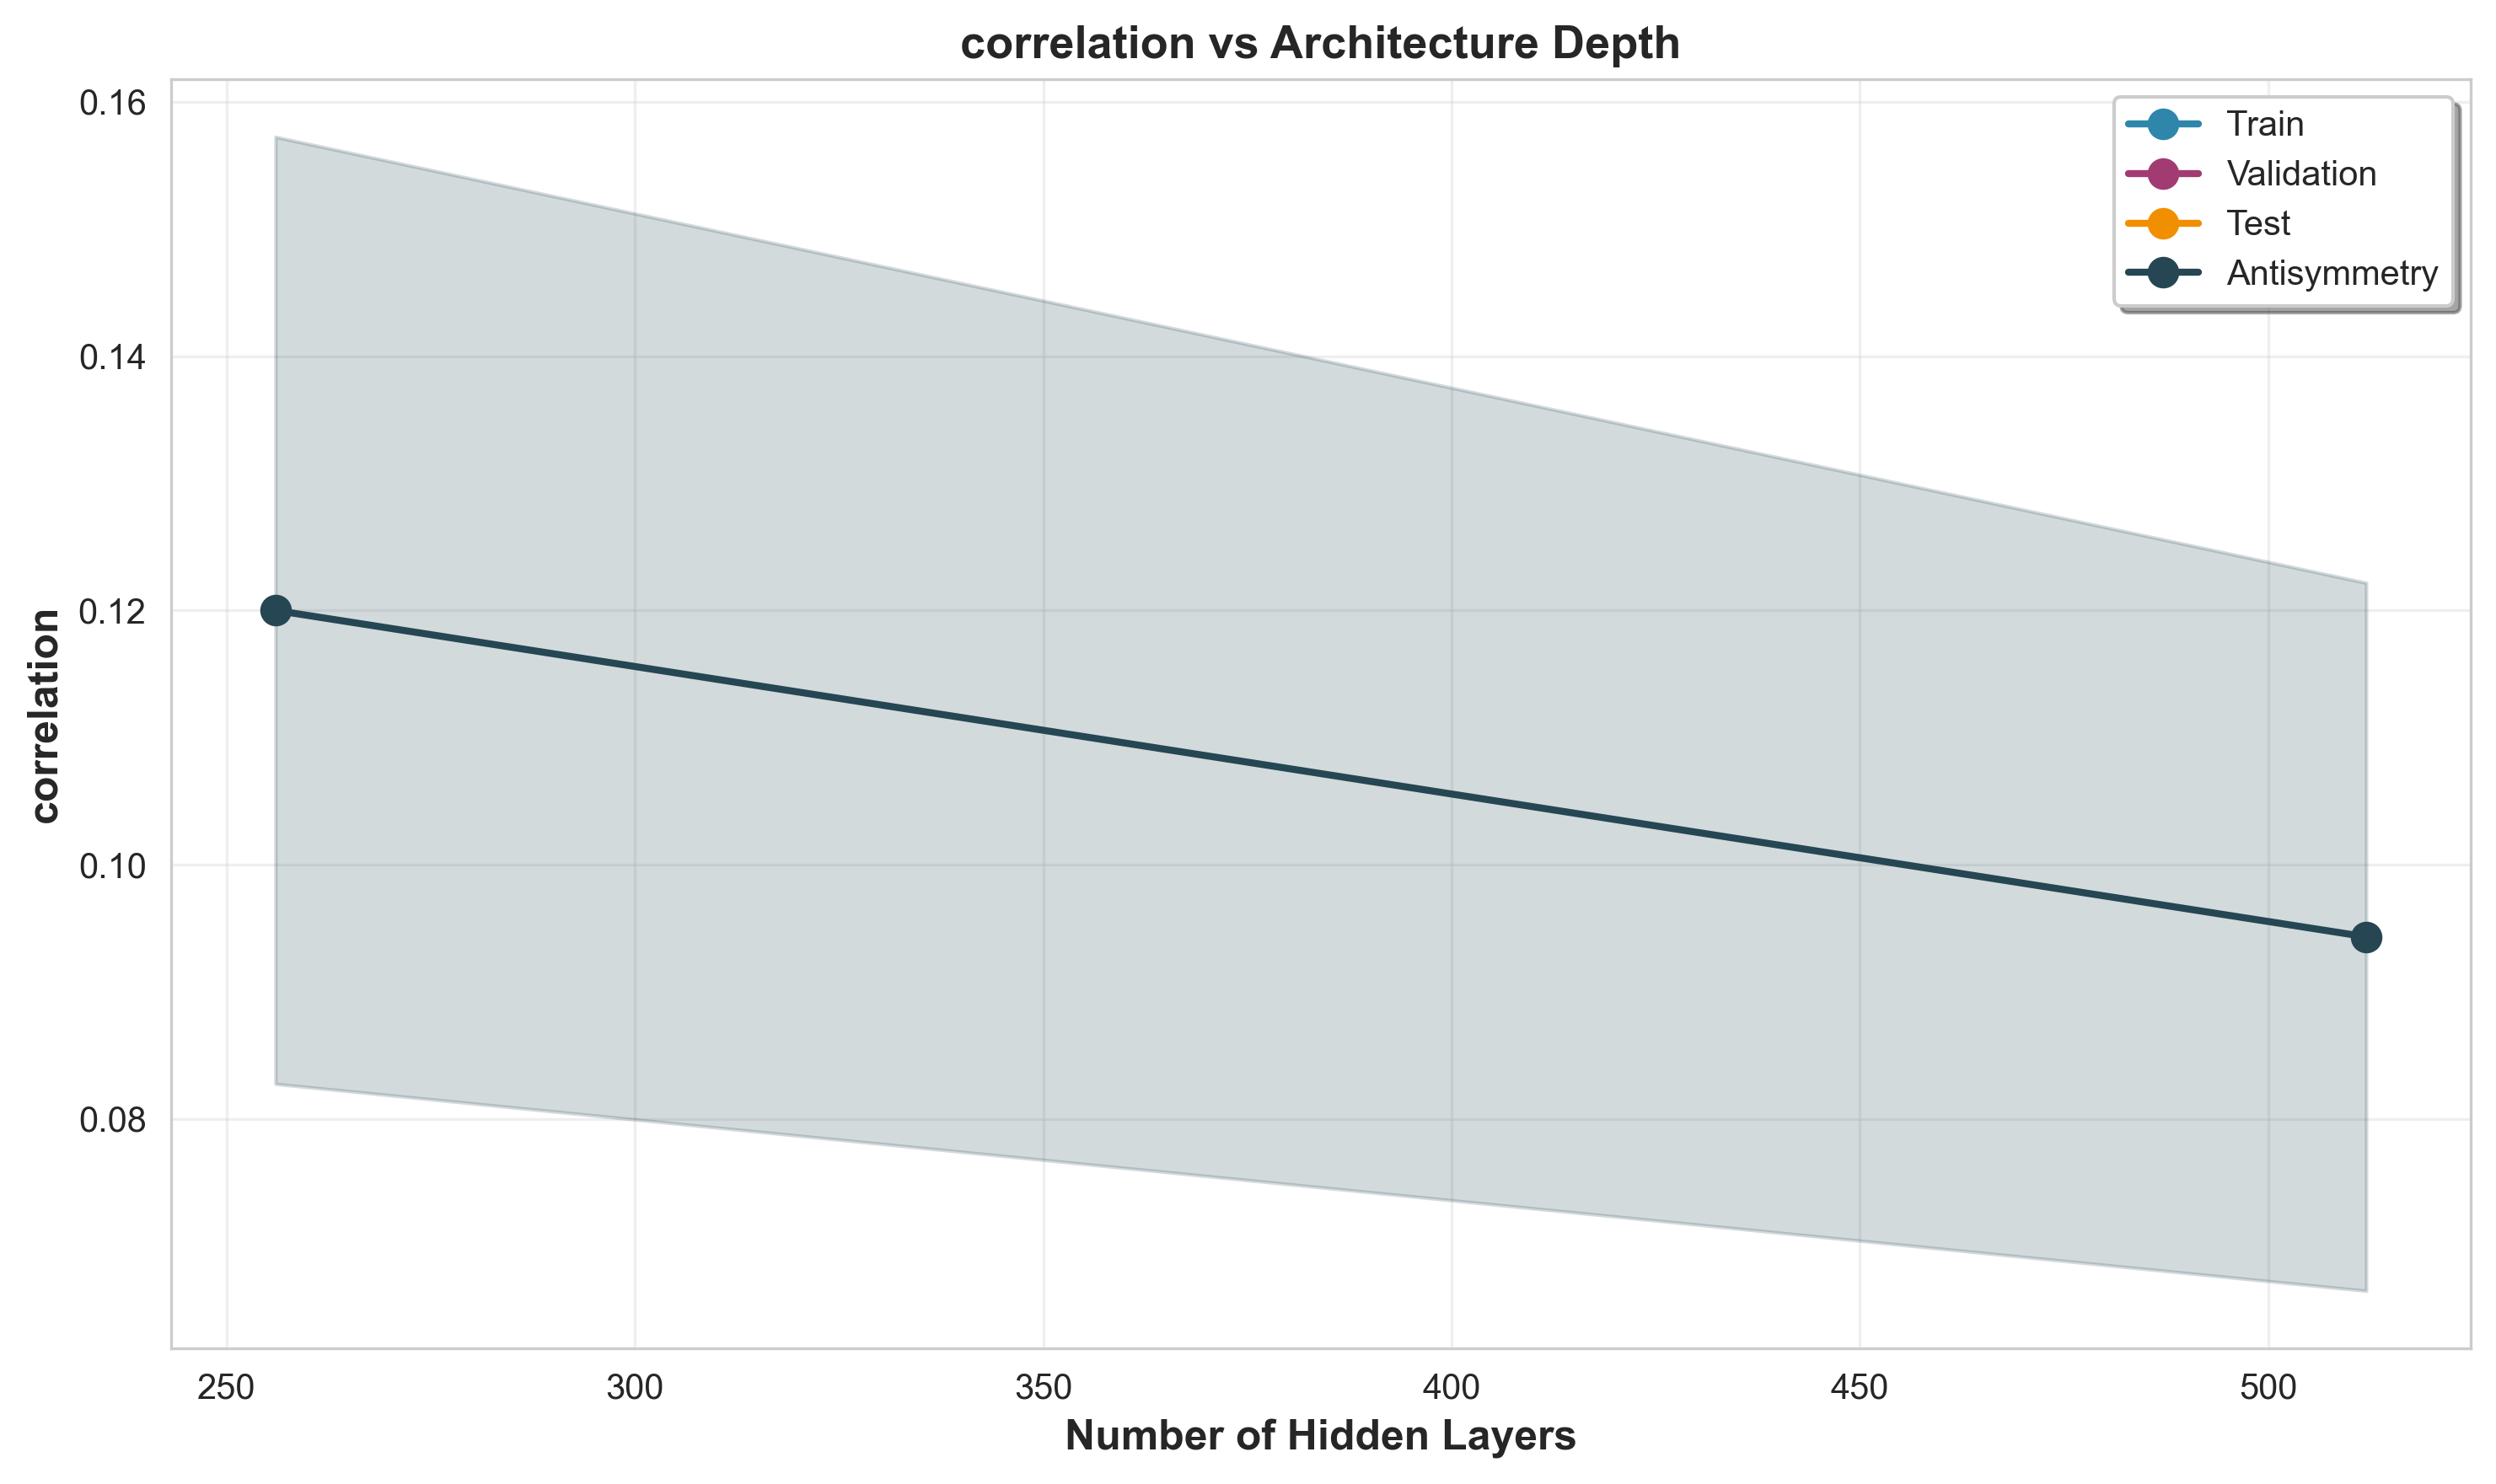

nStatistical summary for correlation:
                            count      mean       std    min     25%    50%     75%   max
split        hidden_layers                                                               
antisymmetry 256              3.0  0.120000  0.064490  0.063  0.0850  0.107  0.1485  0.19
             512              3.0  0.094333  0.048211  0.066  0.0665  0.067  0.1085  0.15
test         256              0.0       NaN       NaN    NaN     NaN    NaN     NaN   NaN
             512              0.0       NaN       NaN    NaN     NaN    NaN     NaN   NaN
train        256              0.0       NaN       NaN    NaN     NaN    NaN     NaN   NaN
             512              0.0       NaN       NaN    NaN     NaN    NaN     NaN   NaN
validation   256              0.0       NaN       NaN    NaN     NaN    NaN     NaN   NaN
             512              0.0       NaN       NaN    NaN     NaN    NaN     NaN   NaN
n=============================================================

'\nInterpretation\n\nThe generalization gap quantifies the degree of overfitting as a function of architectural complexity:\n\n1. **Zero-crossing**: Negative gaps indicate underfitting (validation performance exceeds training, typically due to regularization or insufficient capacity)\n\n2. **Linear growth**: Modest gap increases with depth suggest well-calibrated regularization that maintains generalization\n\n3. **Explosive growth**: Rapid gap expansion identifies the over-parameterization threshold beyond which added depth is counterproductive\n\n4. **Critical depth**: The depth at maximum gap represents the point of maximum overfitting risk and should be avoided\n\nModels operating in the explosive growth regime are unsuitable for deployment regardless of training performance. The optimal architecture lies in the region where generalization gap remains stable and minimal."\n\n'

In [ ]:
"""
## 2. Performance vs Hidden Layers

This analysis quantifies the relationship between architectural depth and predictive performance.
Divergence between training and validation curves indicates overfitting; convergence suggests appropriate model capacity.
"""

# Consolidate data from all splits
def consolidate_results(sheets, architecture_data, metrics):
    """Merge architecture info with performance metrics across all splits."""
    consolidated = []
    
    for sheet_name, df in sheets.items():
        arch_df = architecture_data.get(sheet_name)
        
        if arch_df is not None and 'hidden_layers' in arch_df.columns:
            result_df = pd.DataFrame({
                'split': sheet_name,
                'hidden_layers': arch_df['hidden_layers']
            })
            
            # Add model name if available
            if 'model_name' in arch_df.columns:
                result_df['model_name'] = arch_df['model_name']
            
            # Add all available metrics
            for metric in metrics:
                if metric in df.columns:
                    result_df[metric] = df[metric]
            
            consolidated.append(result_df)
    
    if consolidated:
        return pd.concat(consolidated, ignore_index=True)
    return pd.DataFrame()

# Consolidate all data
results_df = consolidate_results(sheets, architecture_data, unique_metrics)

if not results_df.empty:
    print("Consolidated results:")
    print(results_df.head(10))
    print(f"nTotal records: {len(results_df)}")
    print(f"Splits: {results_df['split'].unique()}")
    print(f"Hidden layer range: {results_df['hidden_layers'].min()} to {results_df['hidden_layers'].max()}")
else:
    print("Warning: No consolidated results available.")
    
    
# Plot performance vs hidden layers for each metric
if not results_df.empty and len(unique_metrics) > 0:
    # Determine primary metrics (higher is better vs lower is better)
    maximize_metrics = [m for m in unique_metrics if any(x in m.lower() 
                       for x in ['pcc', 'scc', 'r2', 'accuracy', 'acc', 'correlation'])]
    minimize_metrics = [m for m in unique_metrics if any(x in m.lower() 
                       for x in ['rmse', 'mae', 'mse', 'error', 'loss'])]
    
    for metric in sorted(unique_metrics):
        if metric in results_df.columns:
            fig, ax = plt.subplots(figsize=(10, 6))
            
            # Plot each split
            for split in results_df['split'].unique():
                split_data = results_df[results_df['split'] == split]
                
                # Group by hidden layers and compute statistics
                grouped = split_data.groupby('hidden_layers')[metric].agg(['mean', 'std', 'count']).reset_index()
                
                color = COLORS.get(split.lower(), COLORS['primary'])
                
                # Plot mean with error bars
                ax.plot(grouped['hidden_layers'], grouped['mean'], 
                       marker='o', linewidth=2, markersize=8,
                       label=split.capitalize(), color=color)
                
                # Add standard error bars if multiple samples exist
                if (grouped['count'] > 1).any():
                    stderr = grouped['std'] / np.sqrt(grouped['count'])
                    ax.fill_between(grouped['hidden_layers'], 
                                   grouped['mean'] - stderr,
                                   grouped['mean'] + stderr,
                                   alpha=0.2, color=color)
            
            ax.set_xlabel('Number of Hidden Layers', fontweight='bold')
            ax.set_ylabel(metric, fontweight='bold')
            ax.set_title(f'{metric} vs Architecture Depth', fontweight='bold')
            ax.legend(frameon=True, fancybox=True, shadow=True)
            ax.grid(True, alpha=0.3)
            
            # Set integer x-axis if appropriate
            if results_df['hidden_layers'].max() <= 20:
                ax.set_xticks(range(int(results_df['hidden_layers'].min()), 
                                   int(results_df['hidden_layers'].max()) + 1))
            
            plt.tight_layout()
            plt.show()
            
            print(f"nStatistical summary for {metric}:")
            summary = results_df.groupby(['split', 'hidden_layers'])[metric].describe()
            print(summary.to_string())
            print("n" + "="*80 + "n")
            


Depths with multiple models for comparison: [256, 512]n


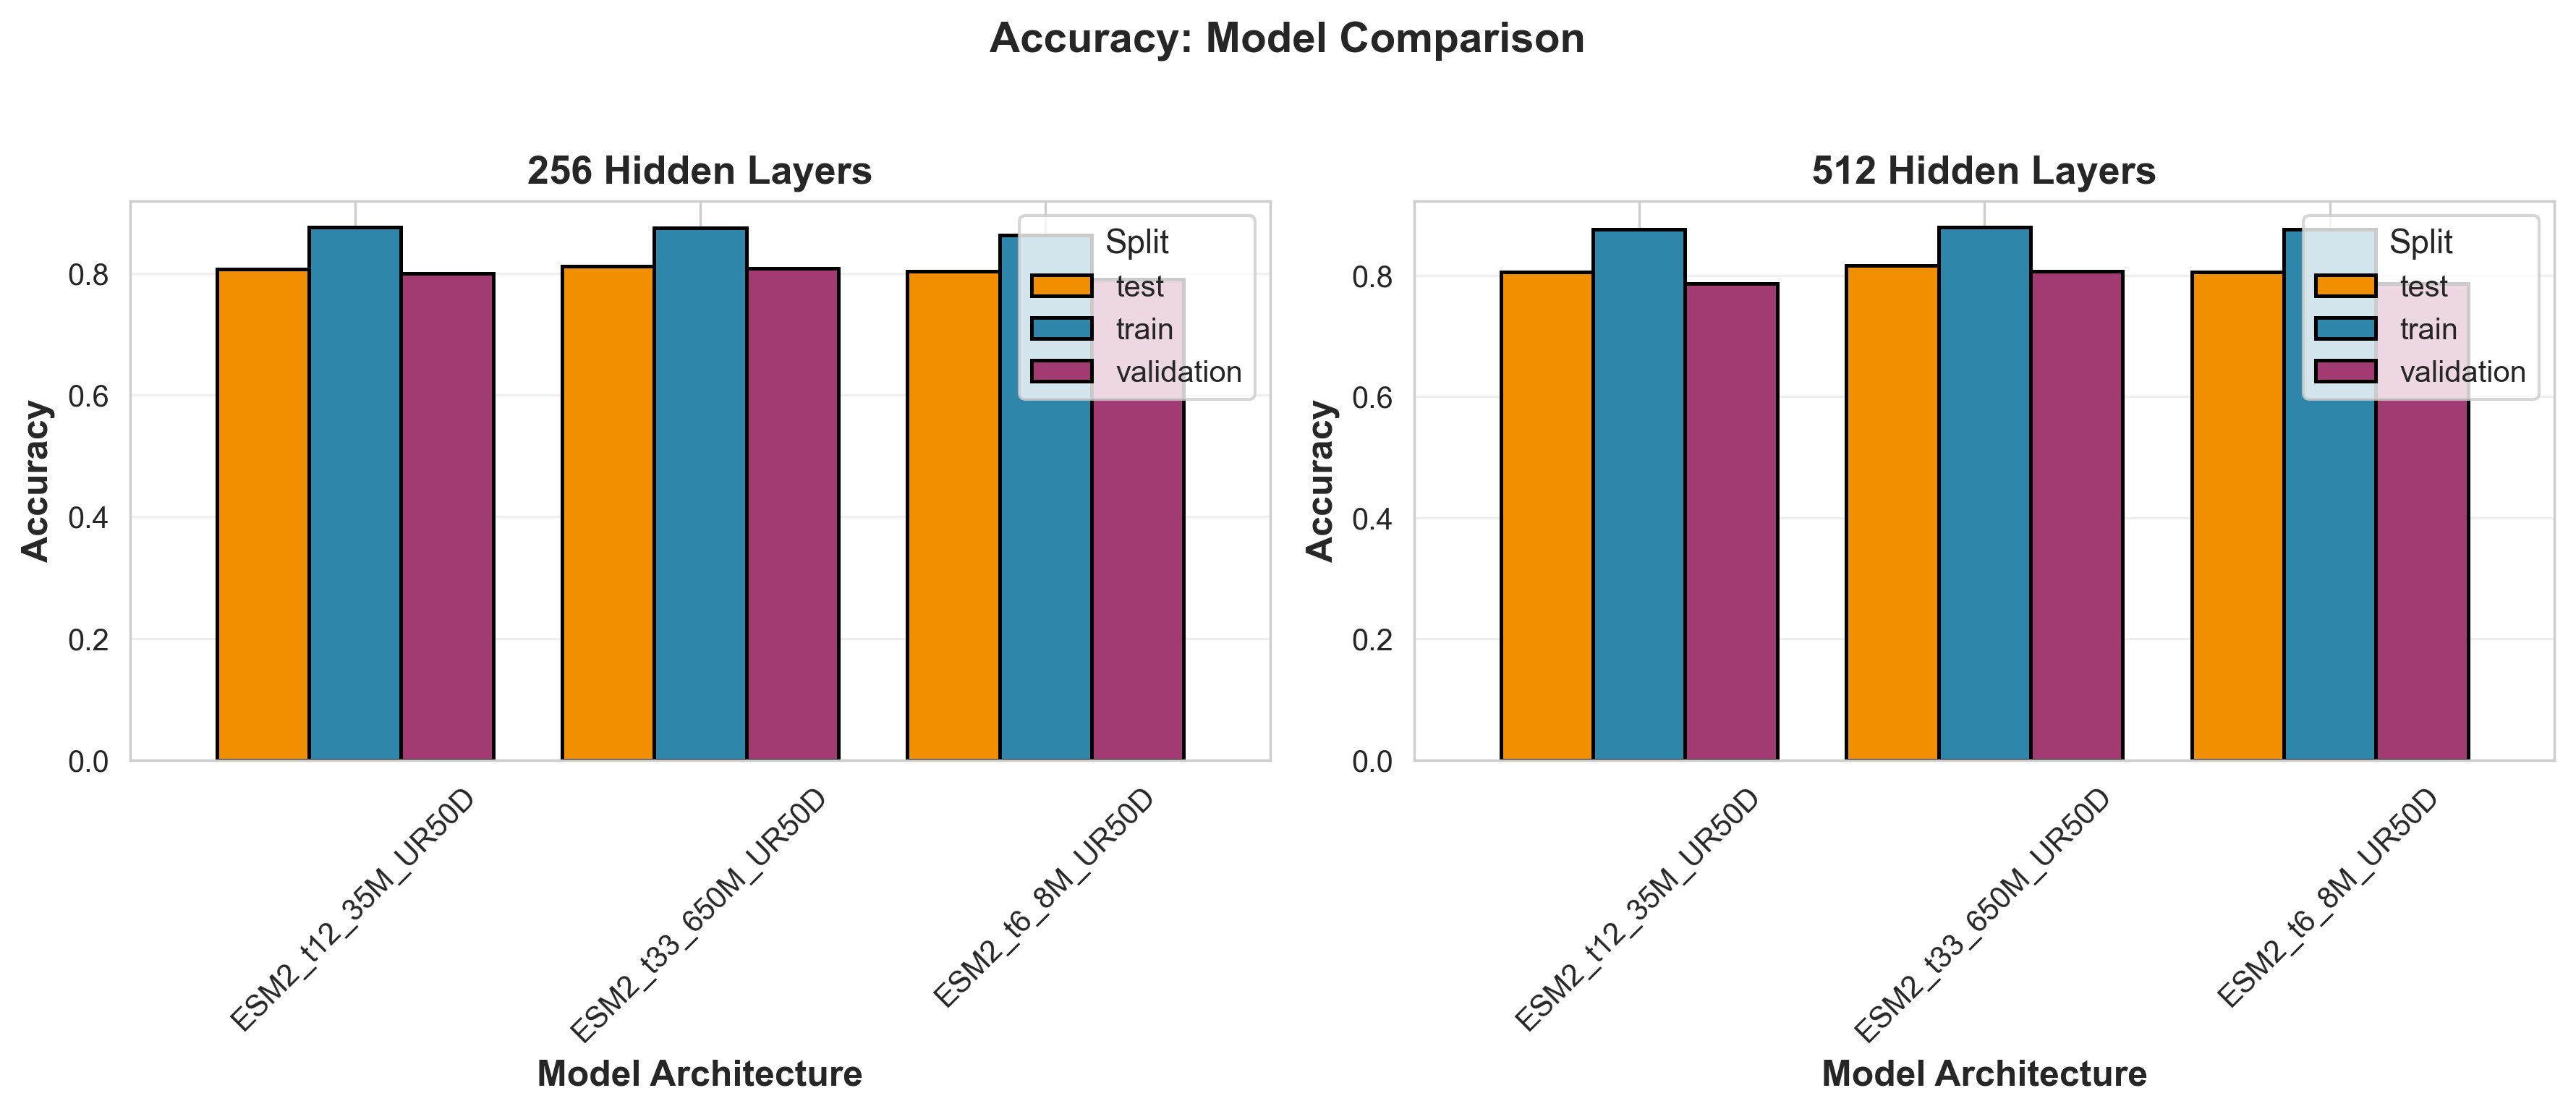

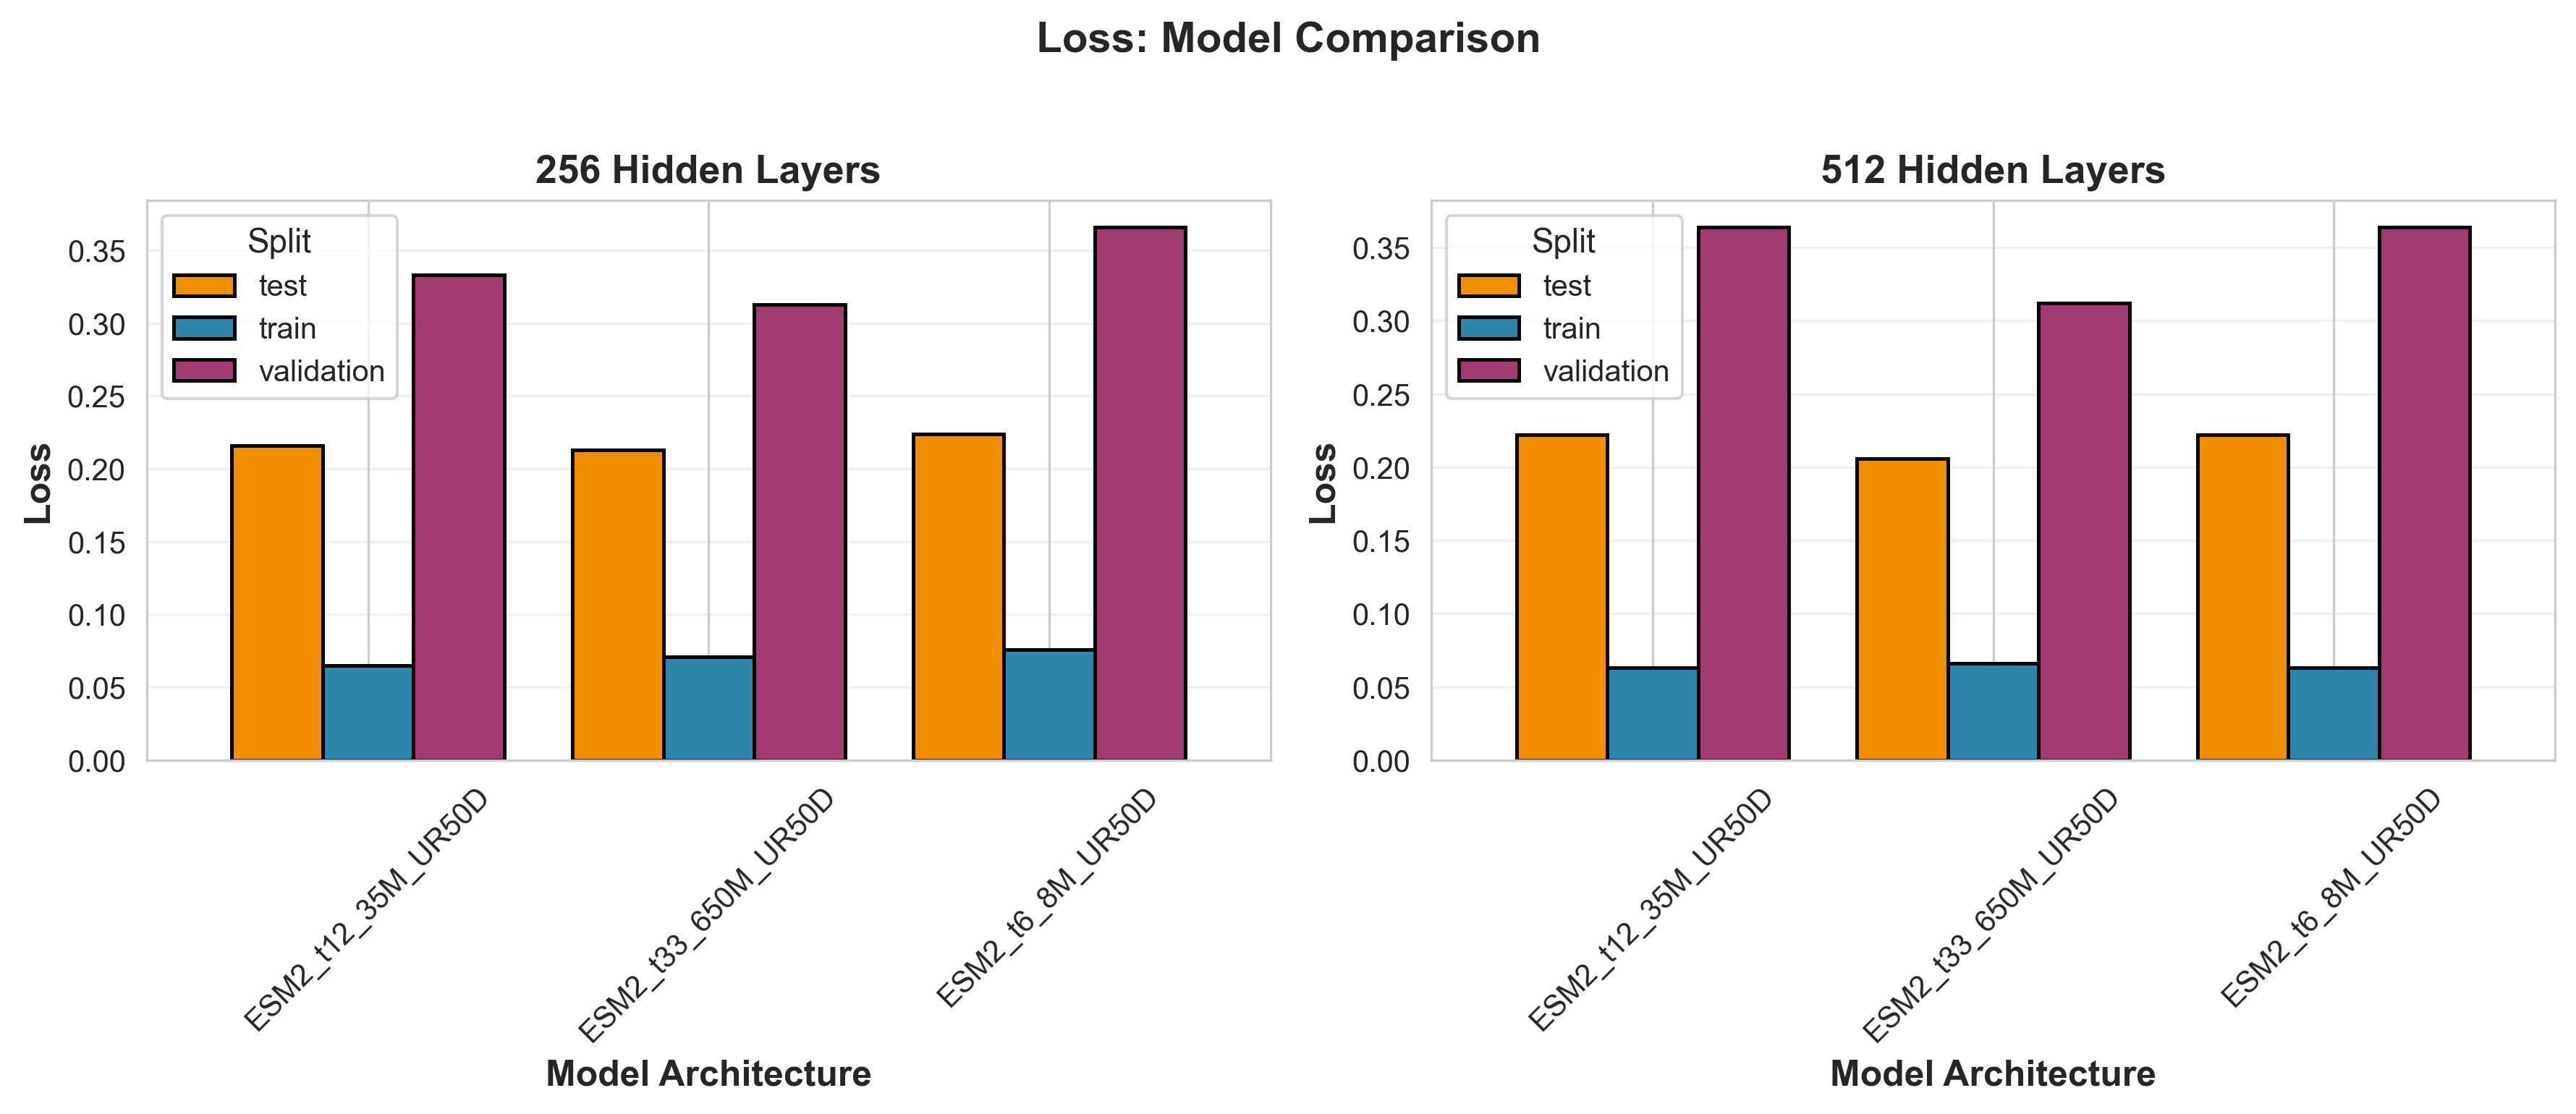

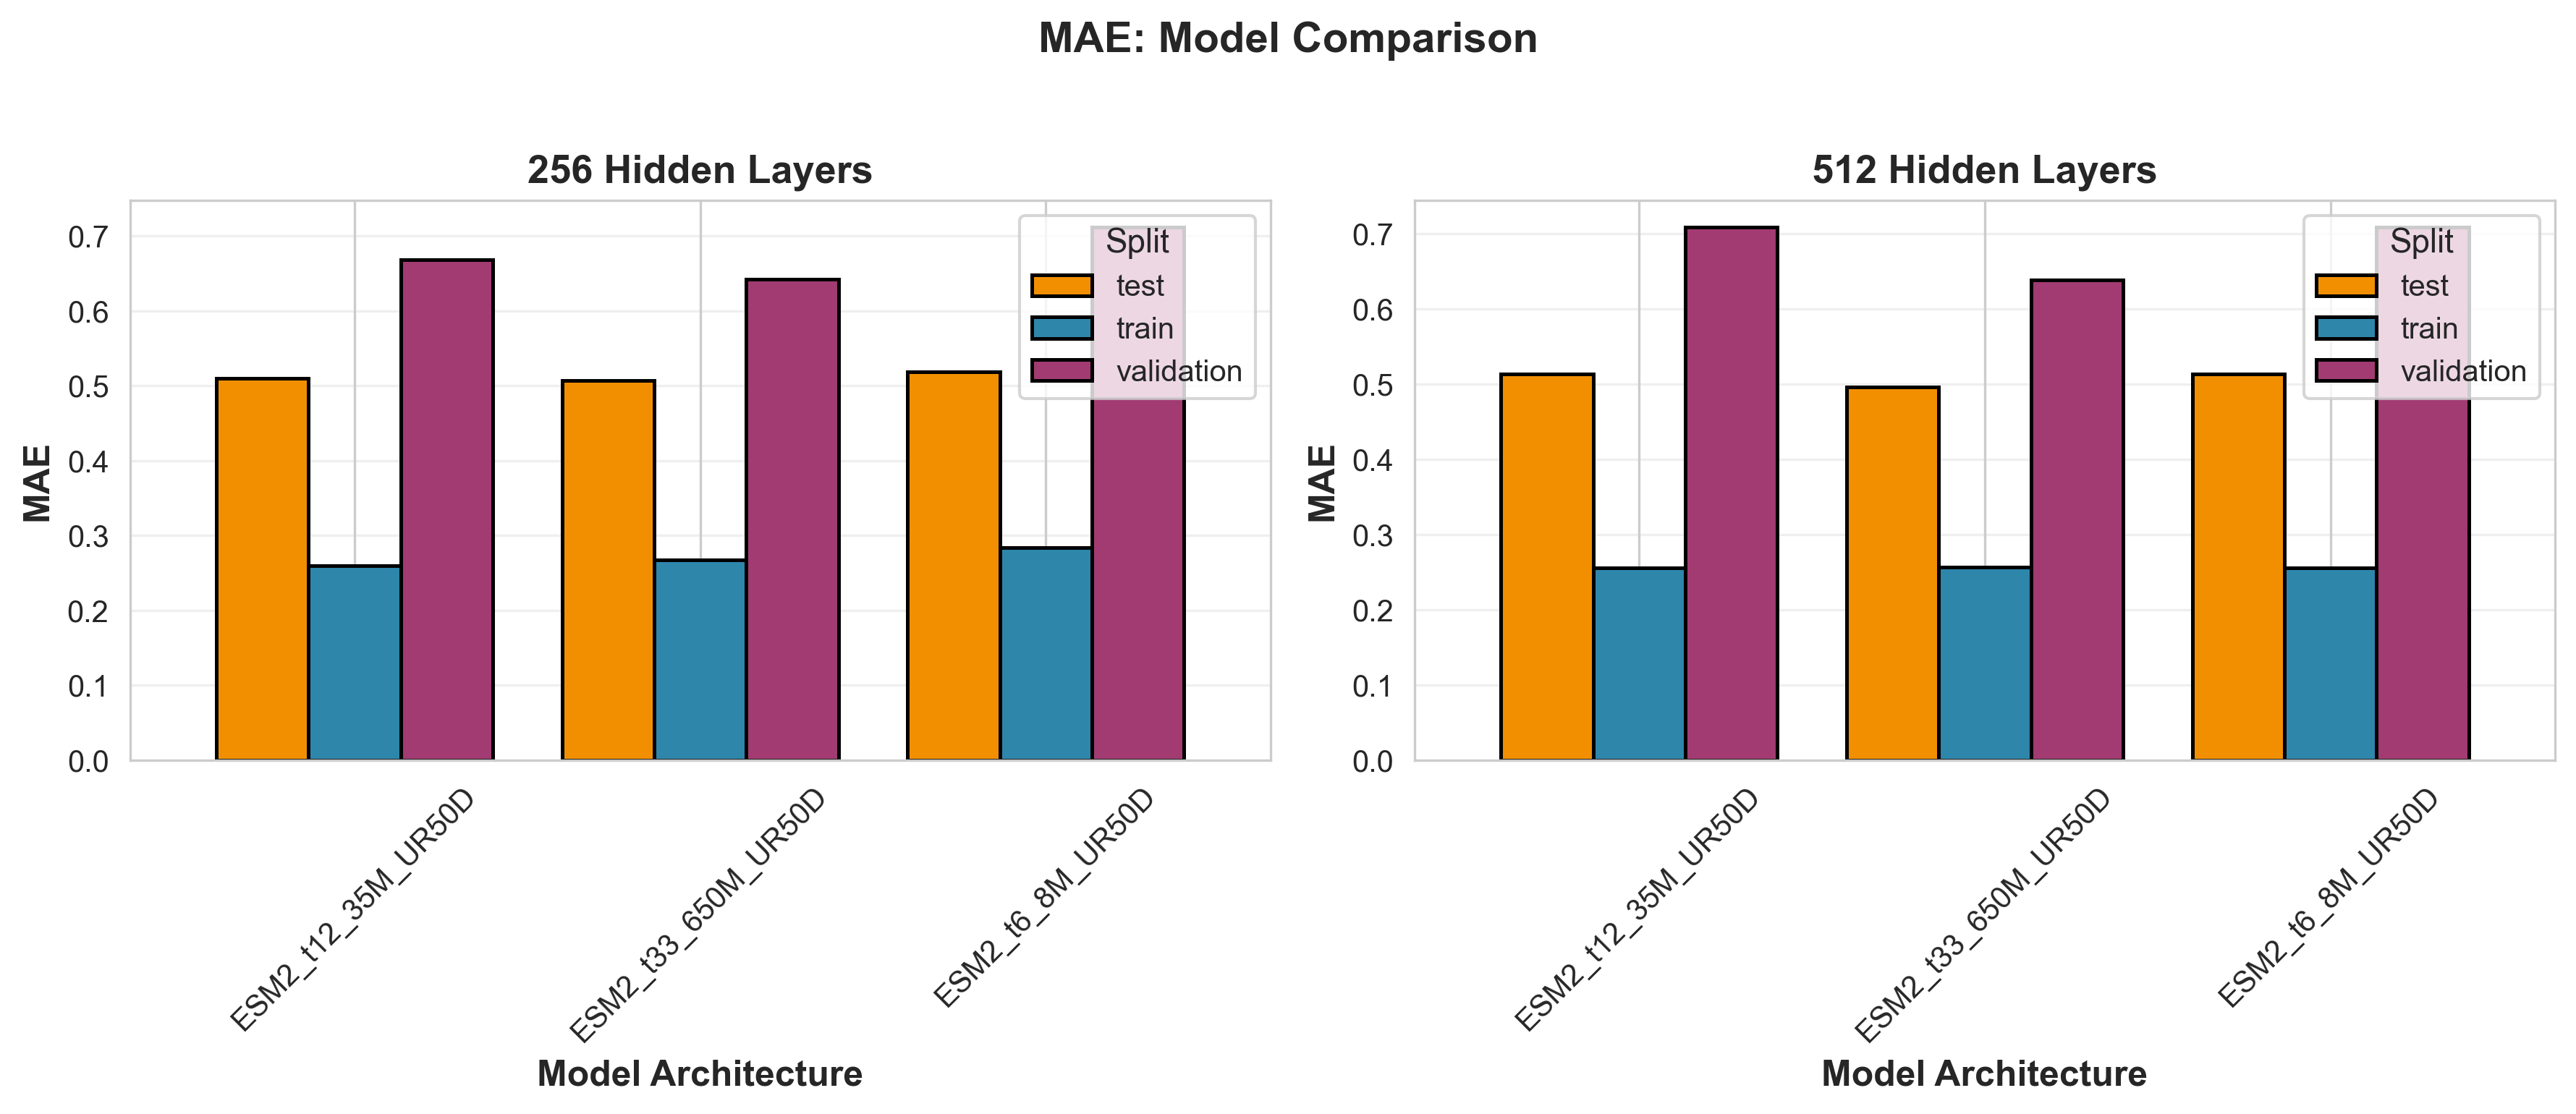

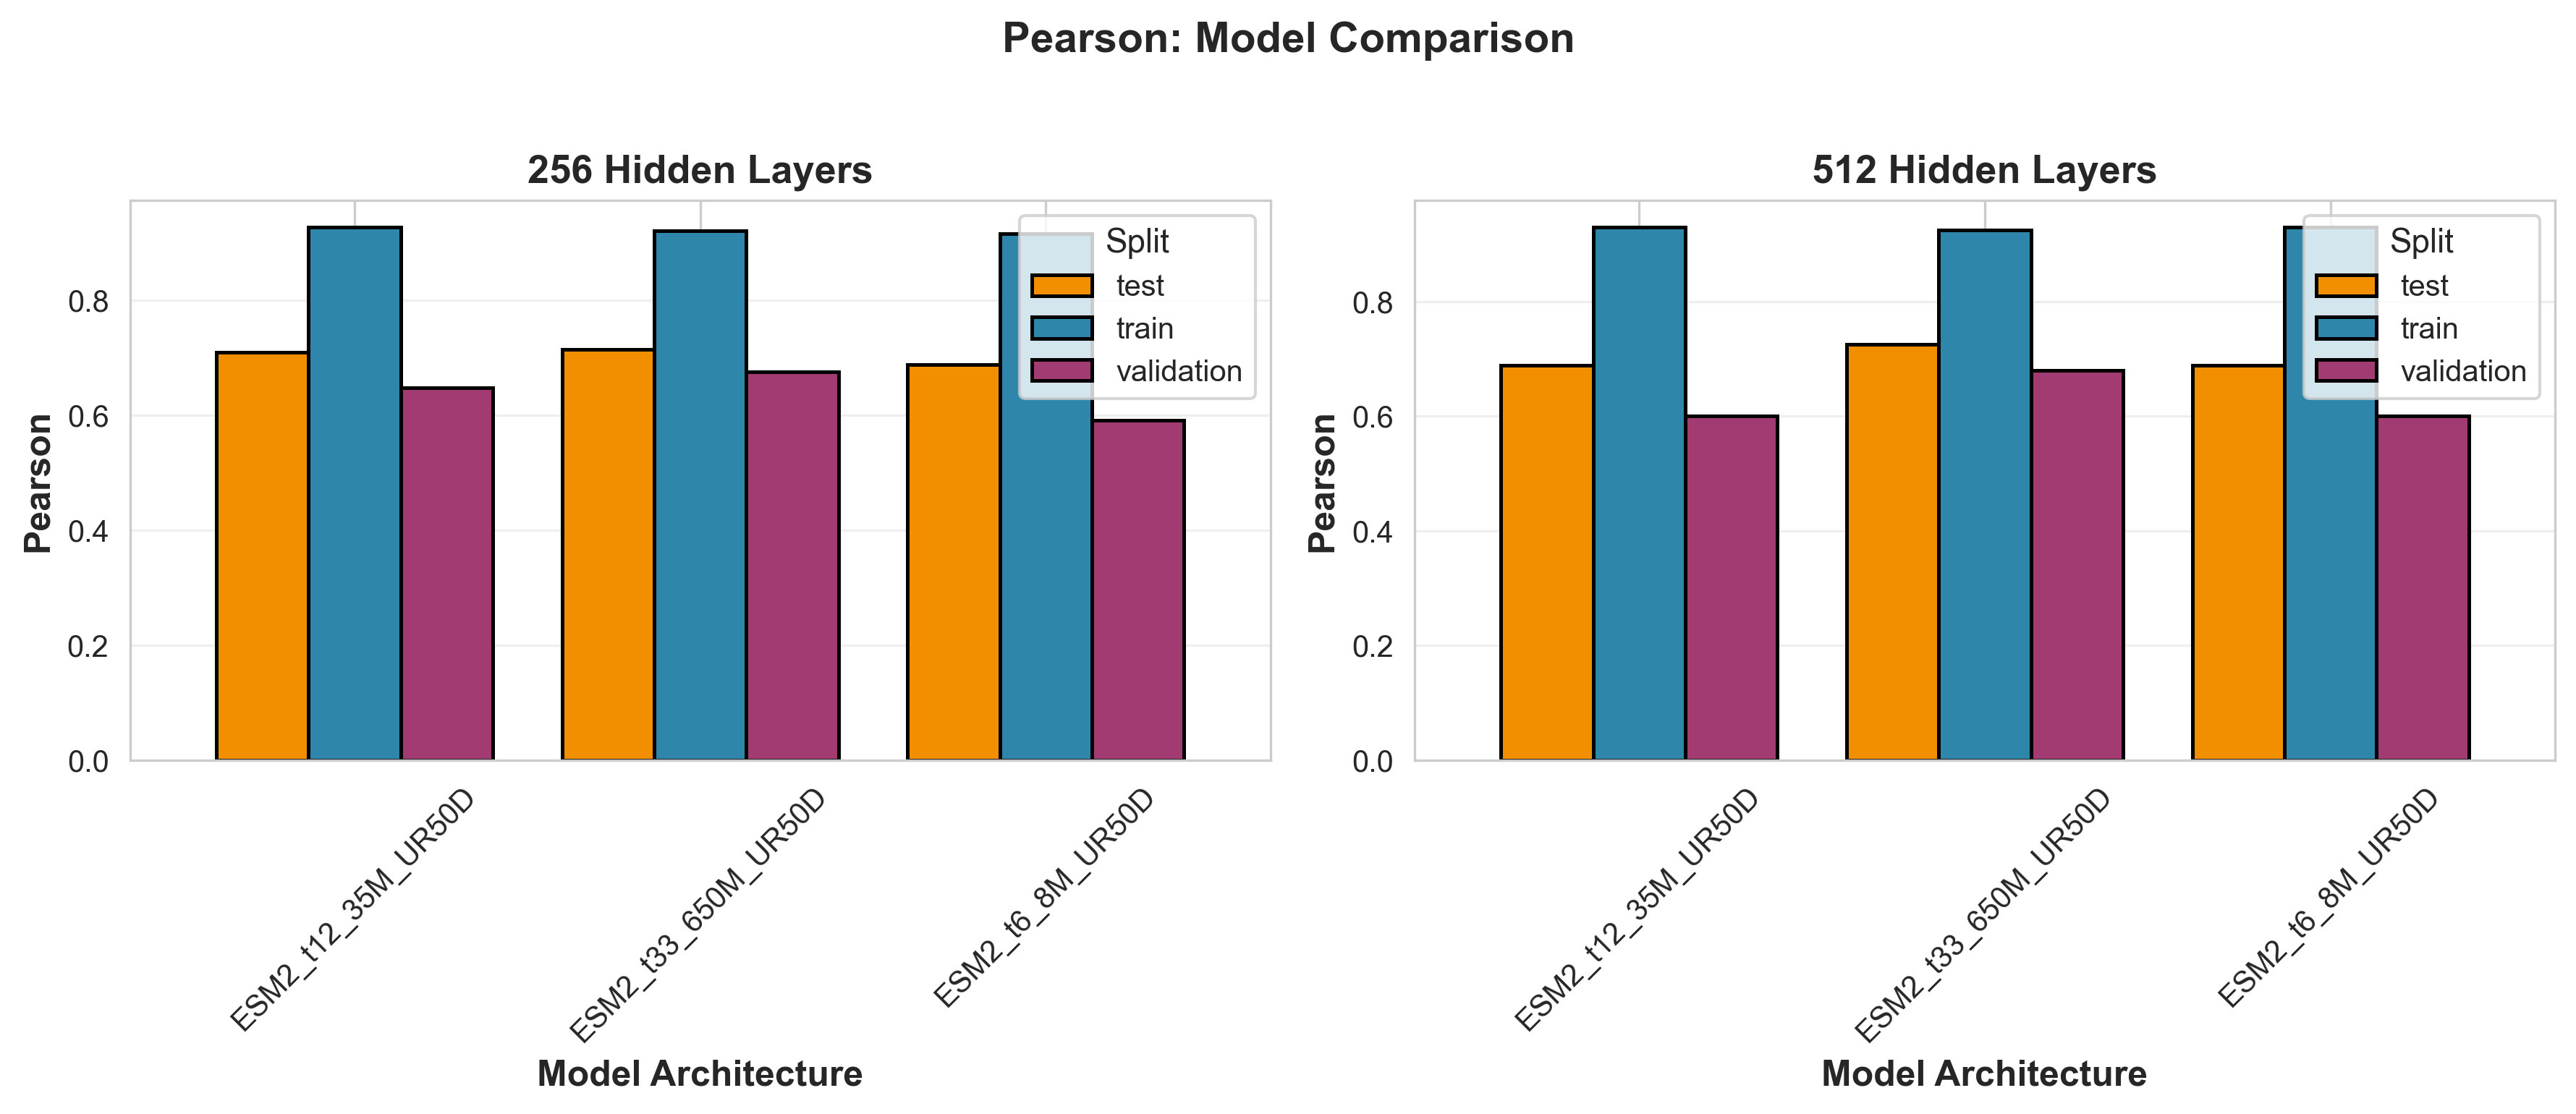

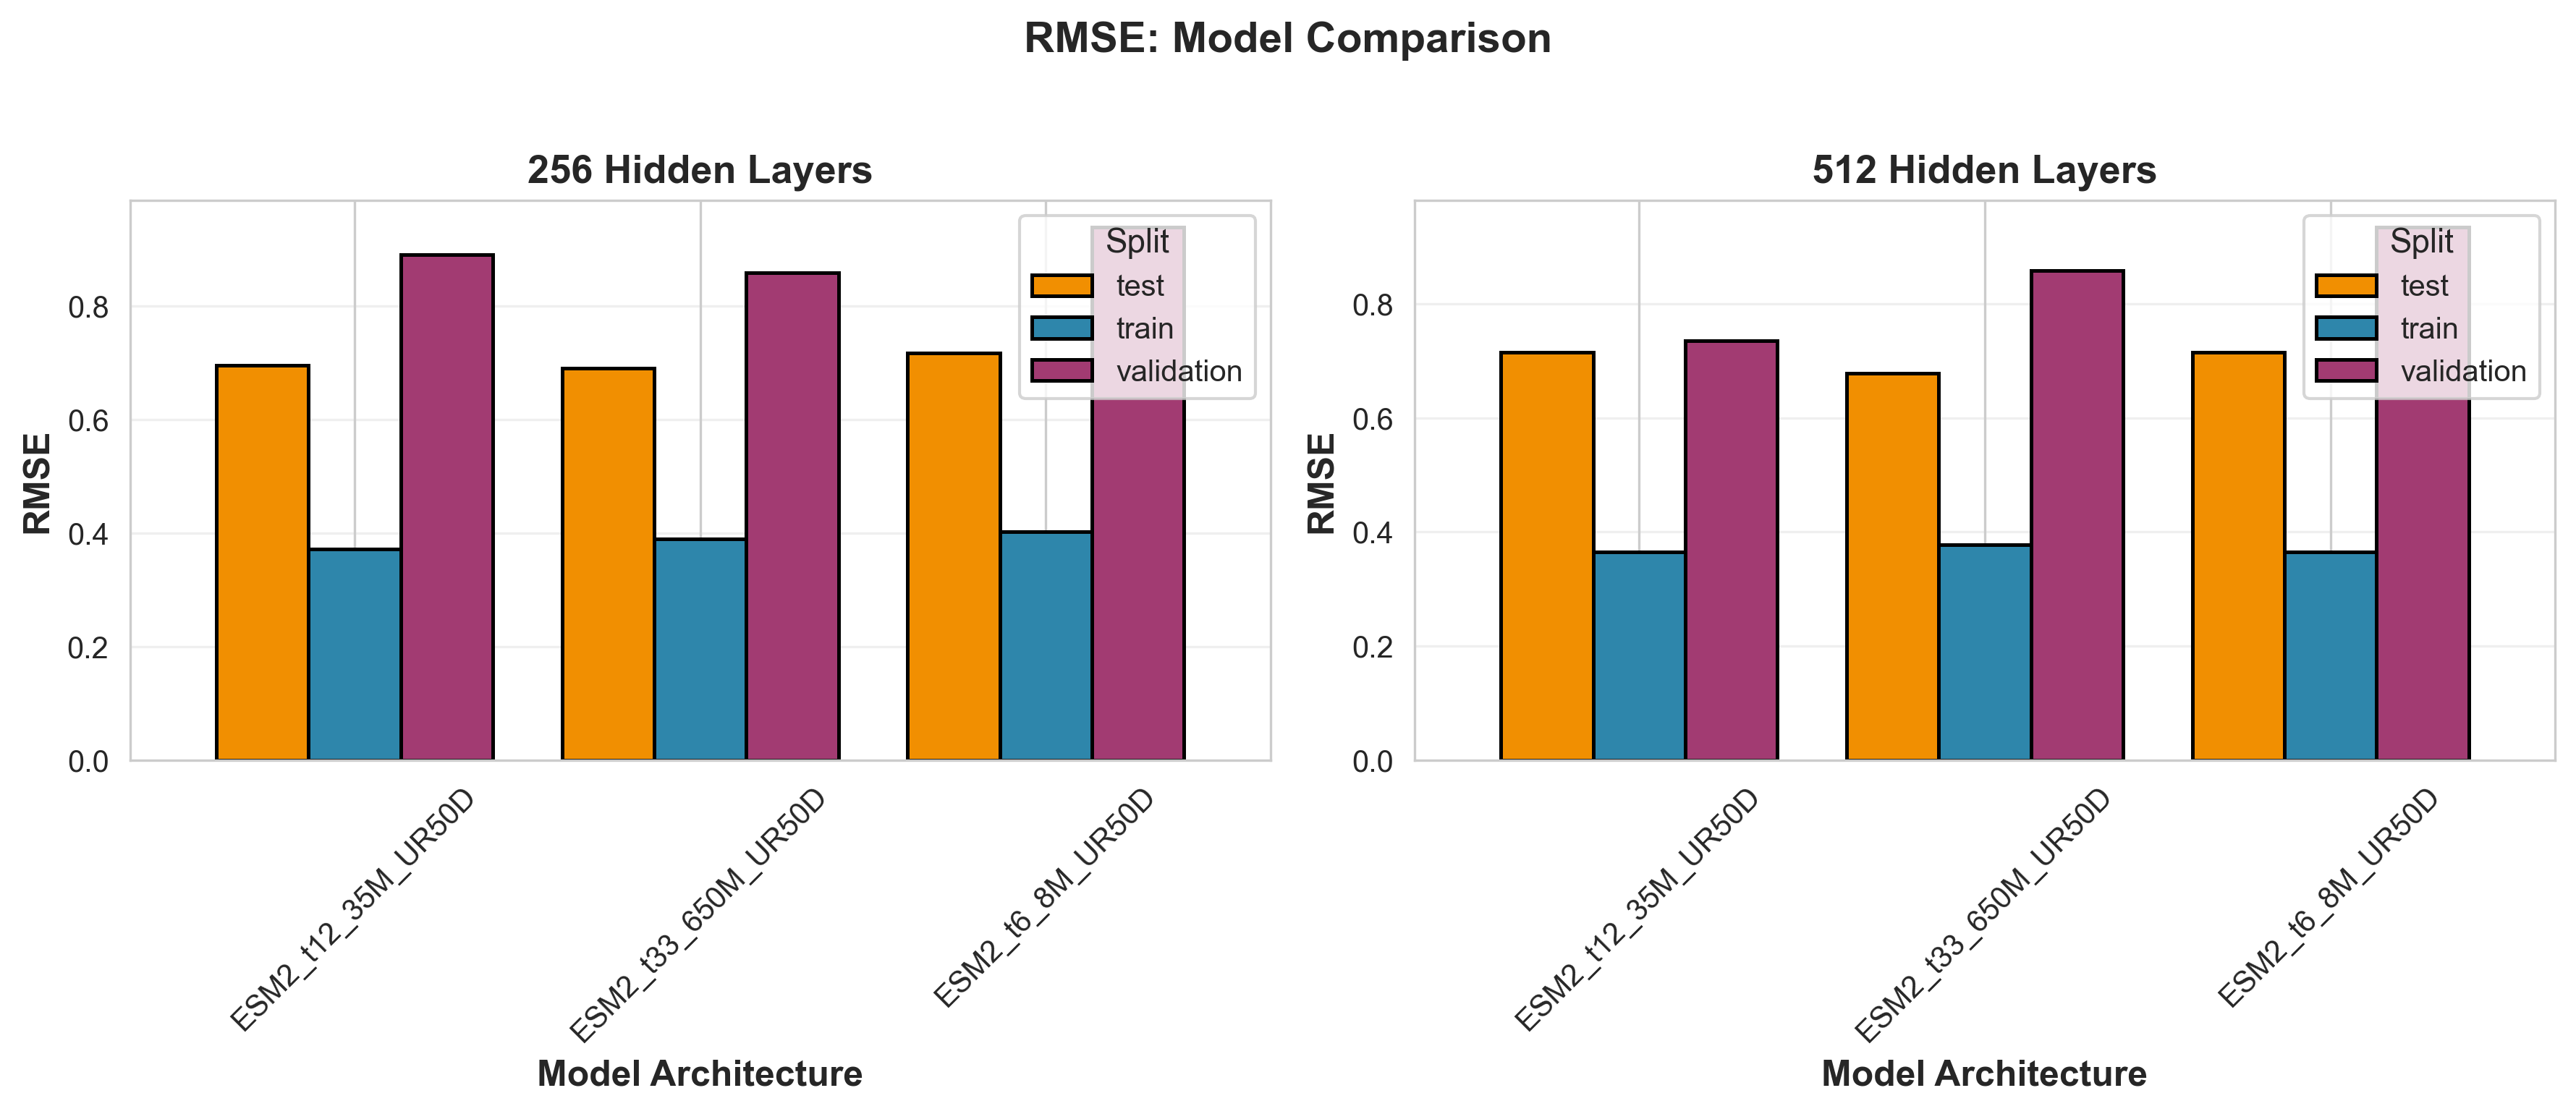

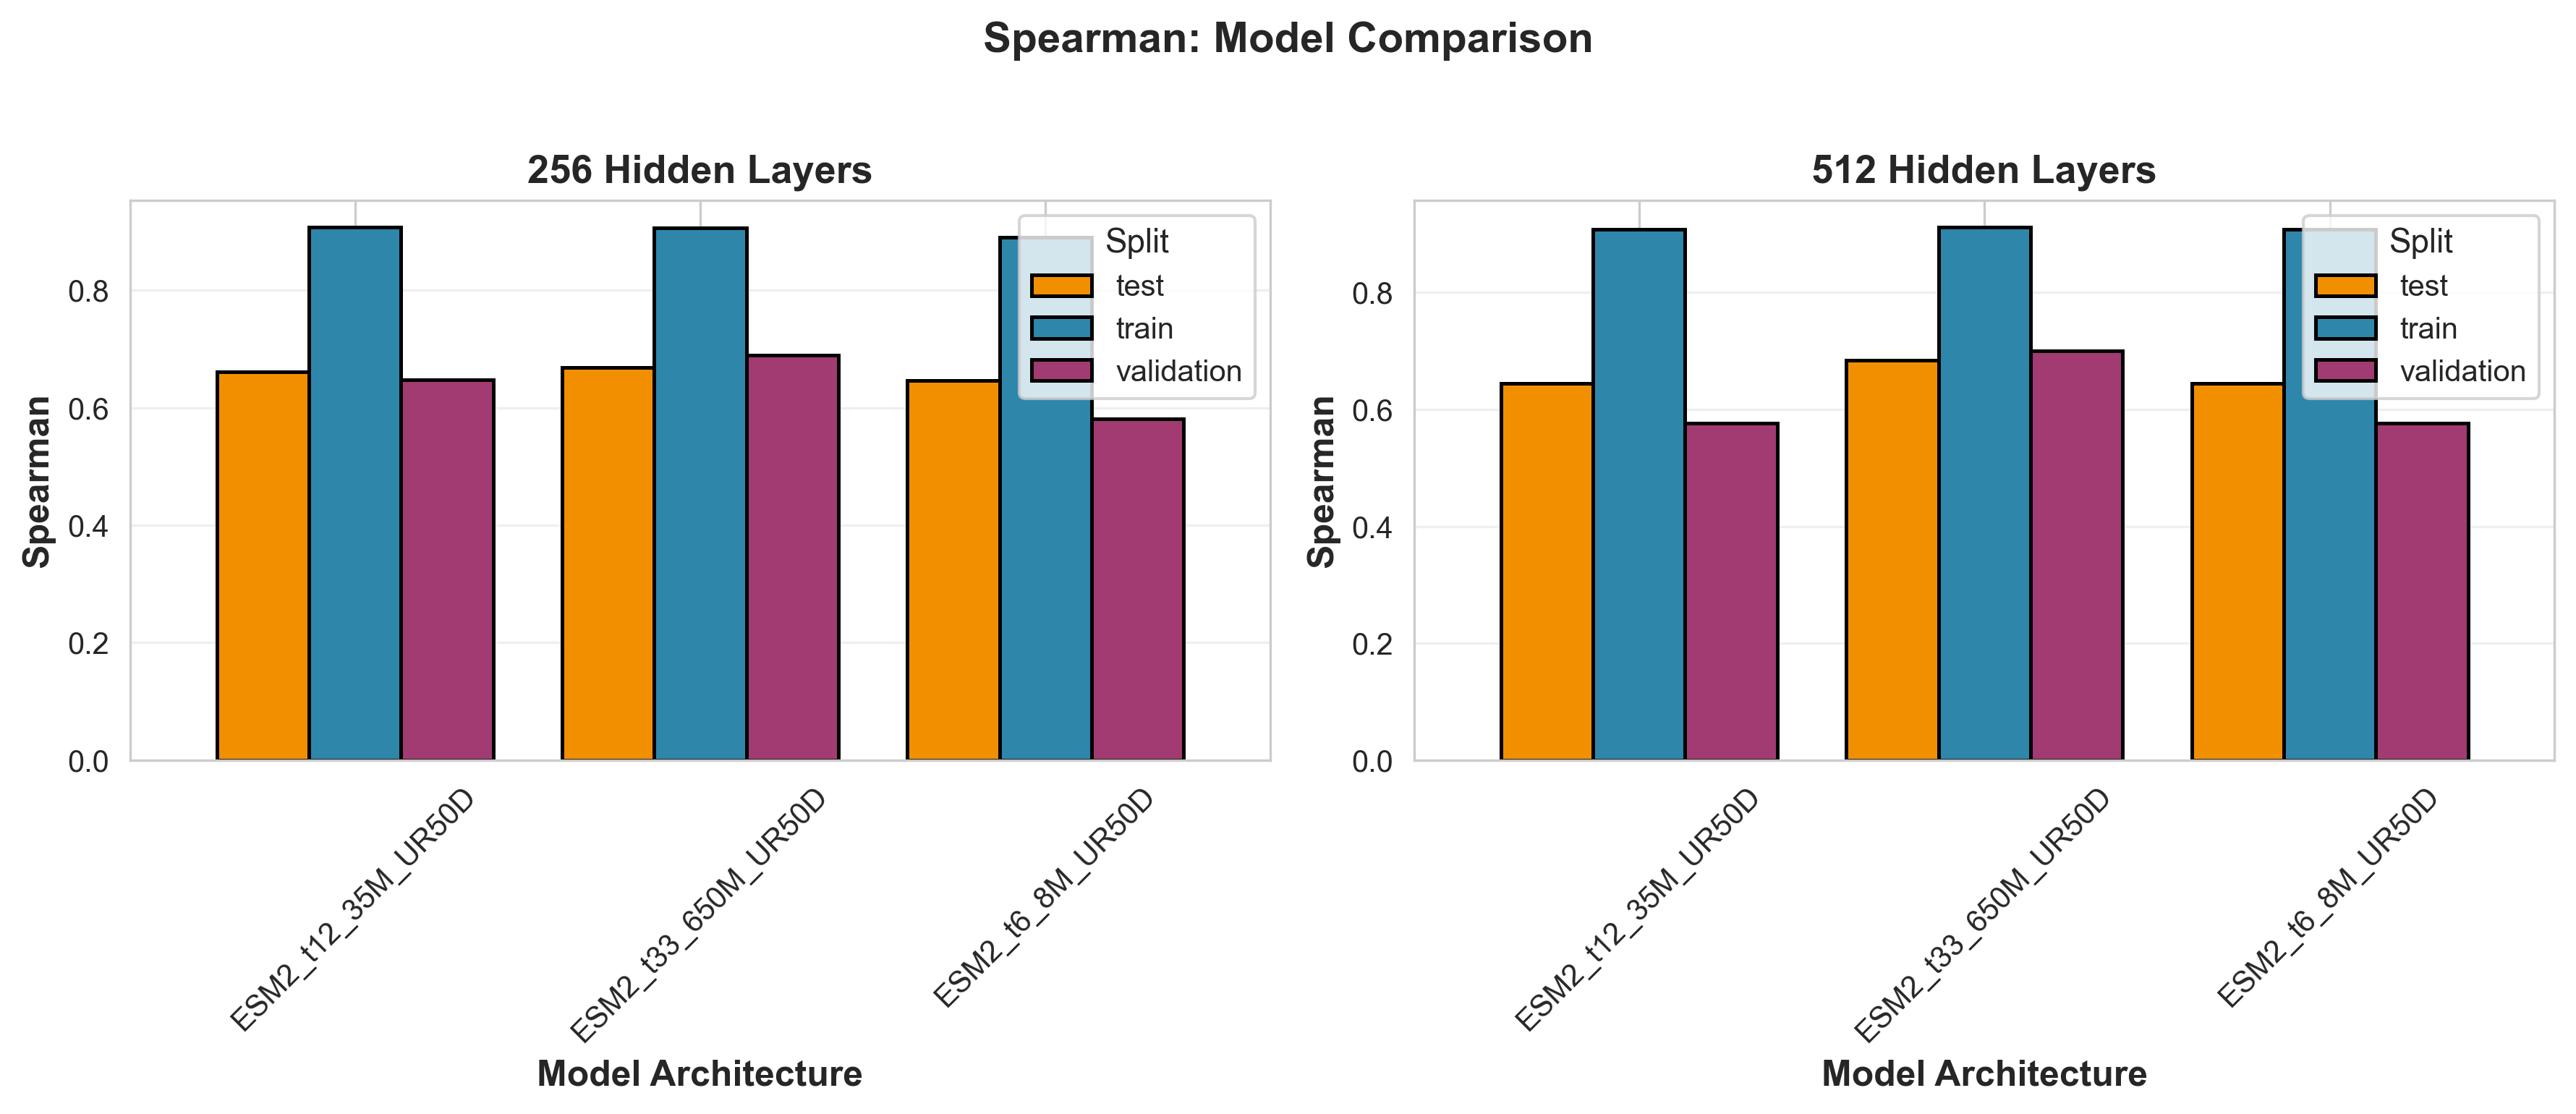

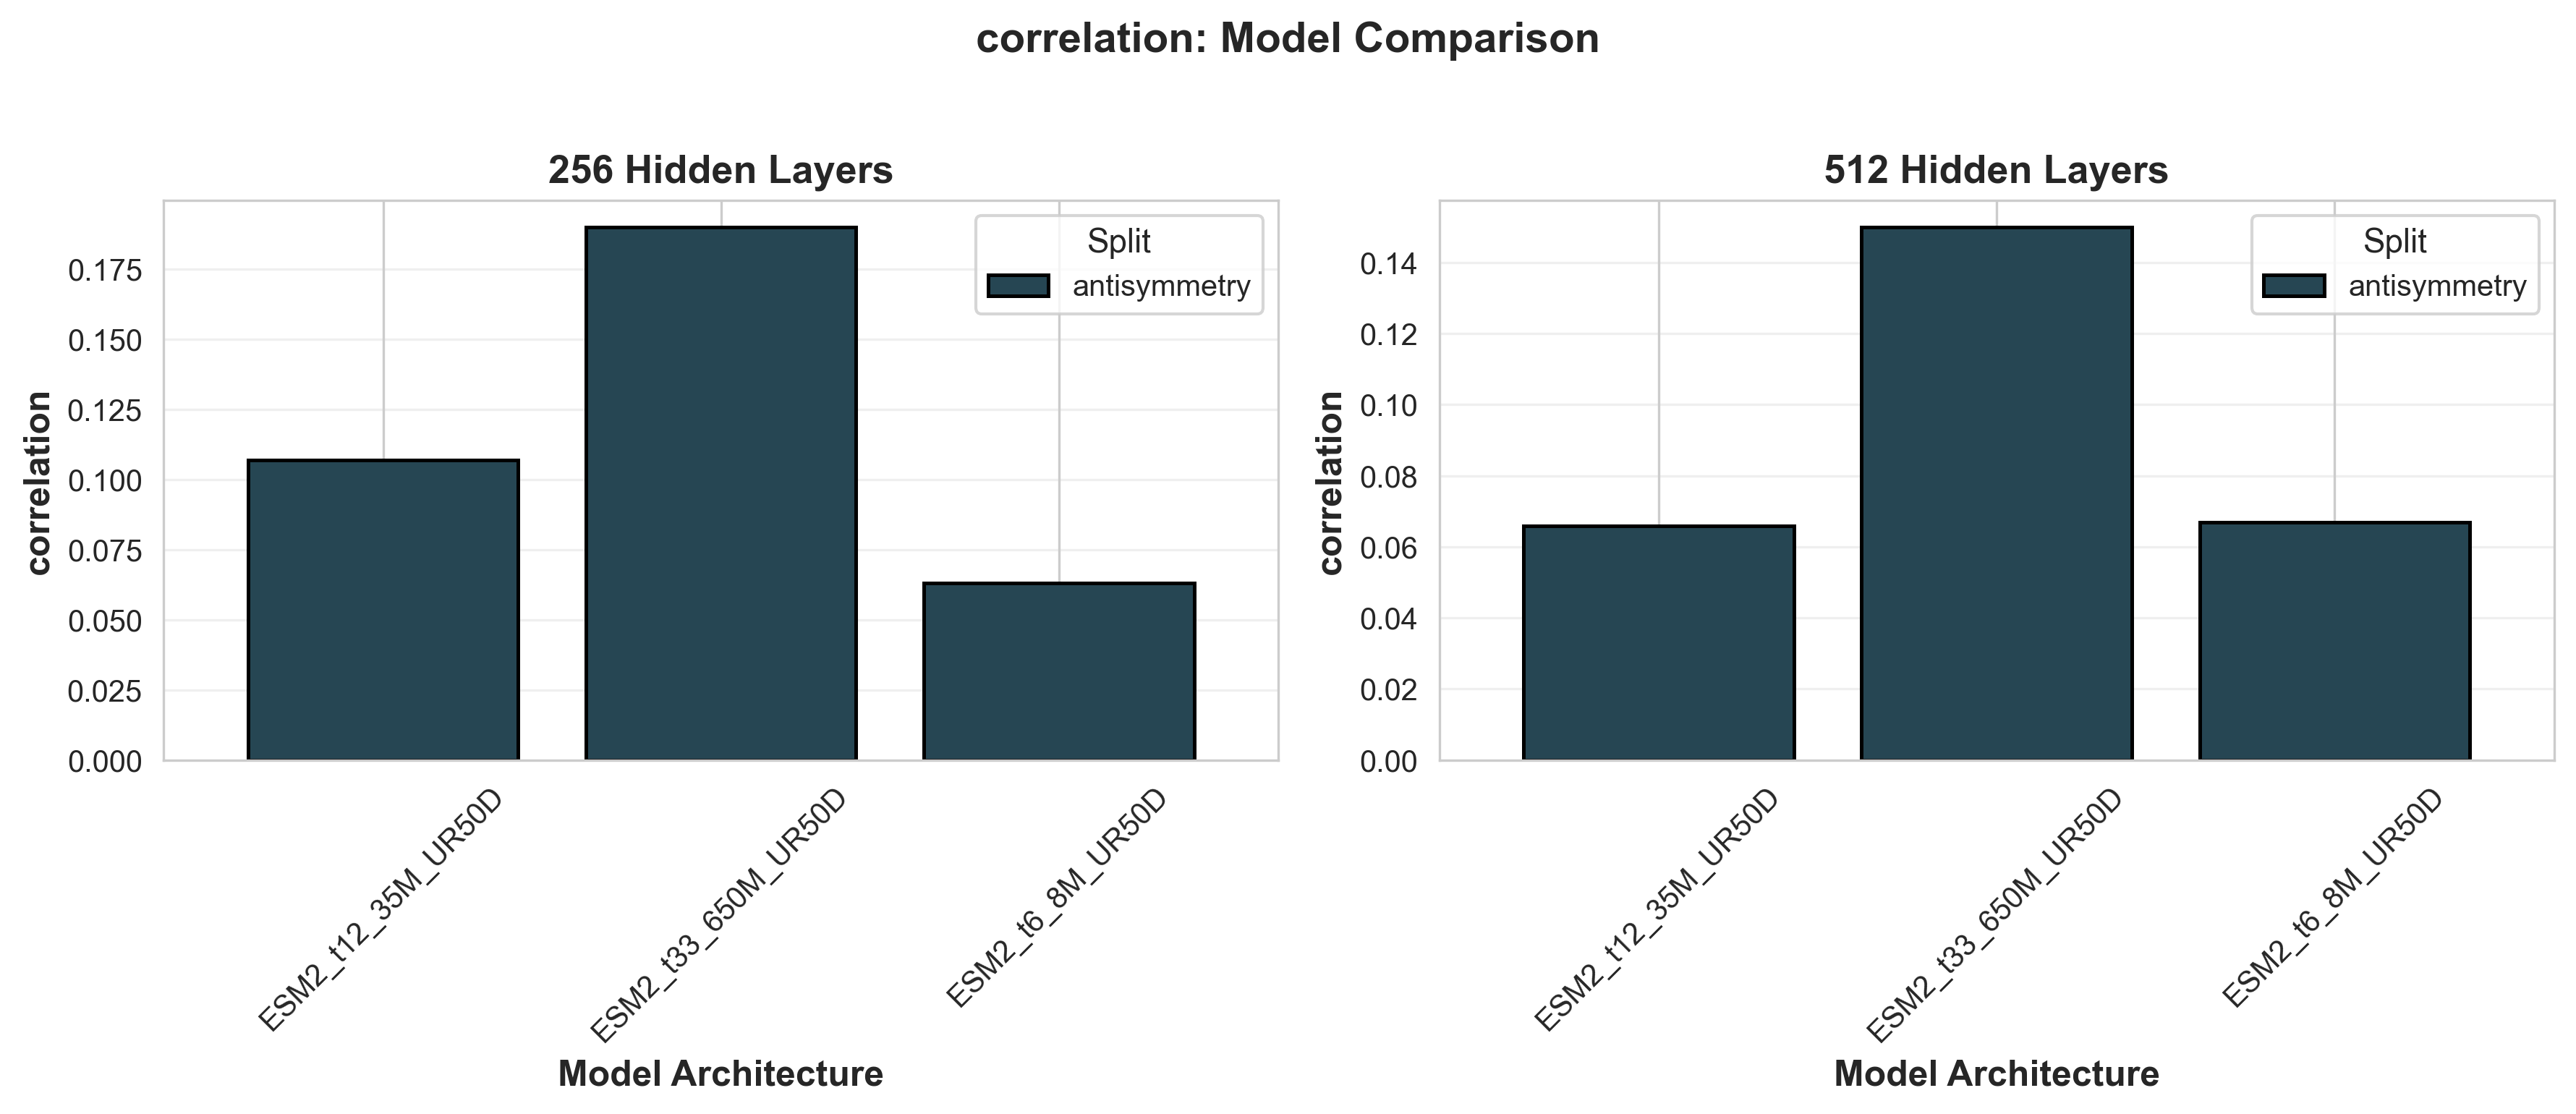

'\n### Interpretation\n\nModel-to-model comparisons at fixed depth reveal:\n\n1. **Architecture dominance**: If different architectures show consistent performance gaps across depths, architecture type is the primary determinant of capacity\n\n2. **Depth dominance**: If performance differences vanish when controlling for depth, layer count is the critical factor and specific architectural choices are secondary\n\n3. **Interaction effects**: Non-parallel performance profiles indicate that certain architectures benefit more from added depth than others\n\n4. **Practical significance**: Small numerical differences may lack statistical or practical importance—consider whether observed gaps exceed experimental measurement error\n\nThis analysis informs whether architectural innovation or simple depth scaling offers greater returns for model improvement.\n'

In [ ]:
"""
3. Model-to-Model Comparison at Equal Depth

This analysis isolates architectural choices from depth effects by comparing different model types at identical layer counts.
Systematic differences indicate that architecture matters independently of depth.
"""

# Compare models at each depth level
if not results_df.empty and 'model_name' in results_df.columns:
    # Identify depths with multiple models
    depth_model_counts = results_df.groupby('hidden_layers')['model_name'].nunique()
    comparable_depths = depth_model_counts[depth_model_counts > 1].index.tolist()
    
    if comparable_depths:
        print(f"Depths with multiple models for comparison: {comparable_depths}n")
        
        for metric in sorted(unique_metrics):
            if metric in results_df.columns:
                fig, axes = plt.subplots(1, min(3, len(comparable_depths)), 
                                        figsize=(6*min(3, len(comparable_depths)), 5))
                
                if len(comparable_depths) == 1:
                    axes = [axes]
                
                for idx, depth in enumerate(comparable_depths[:3]):
                    depth_data = results_df[results_df['hidden_layers'] == depth]
                    
                    # Prepare data for grouped bar plot
                    plot_data = depth_data.pivot_table(
                        index='model_name',
                        columns='split',
                        values=metric,
                        aggfunc='mean'
                    )
                    
                    if not plot_data.empty:
                        ax = axes[idx] if len(comparable_depths) > 1 else axes[0]
                        plot_data.plot(kind='bar', ax=ax, 
                                      color=[COLORS.get(col.lower(), COLORS['primary']) 
                                            for col in plot_data.columns],
                                      width=0.8, edgecolor='black', linewidth=1.2)
                        
                        ax.set_xlabel('Model Architecture', fontweight='bold')
                        ax.set_ylabel(metric, fontweight='bold')
                        ax.set_title(f'{depth} Hidden Layers', fontweight='bold')
                        ax.legend(title='Split', frameon=True)
                        ax.grid(True, alpha=0.3, axis='y')
                        ax.tick_params(axis='x', rotation=45)
                
                plt.suptitle(f'{metric}: Model Comparison', 
                           fontweight='bold', fontsize=14, y=1.02)
                plt.tight_layout()
                plt.show()
    else:
        print("No depths found with multiple model architectures for comparison.")
else:
    print("Model comparison requires 'model_name' column in results.")



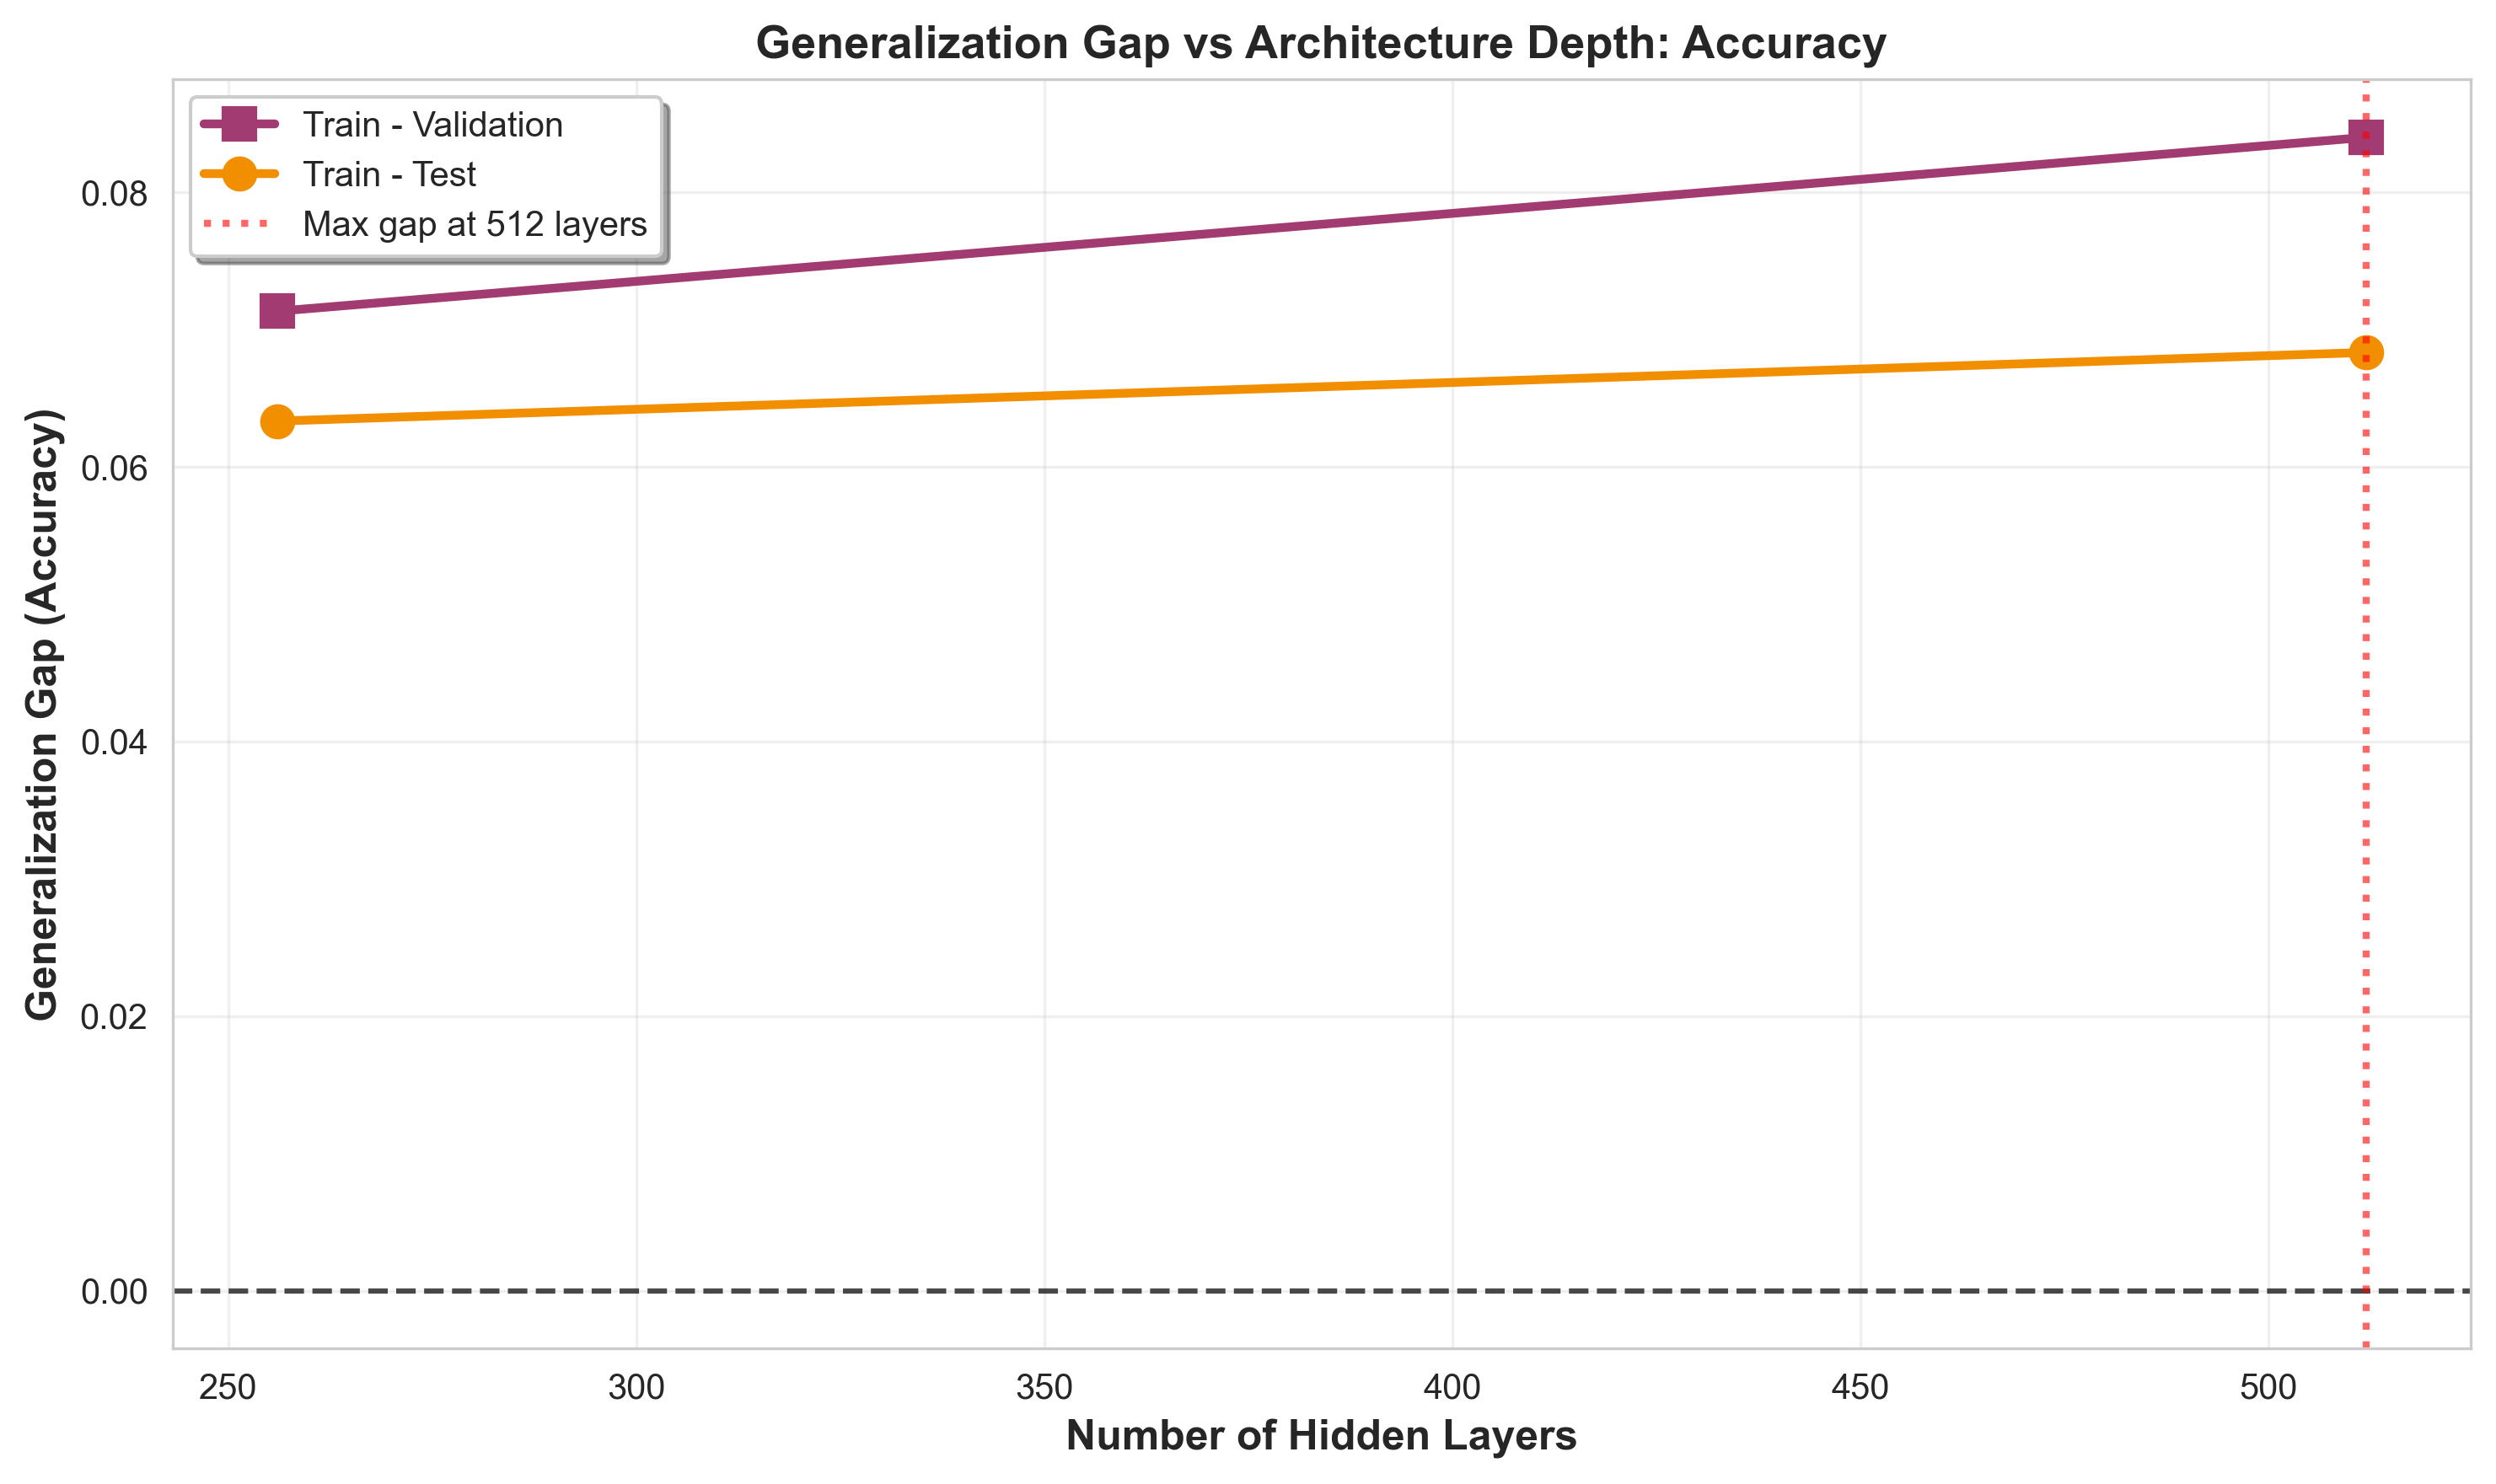

nGeneralization gap statistics for Accuracy:
  Maximum train-validation gap: 0.0840 at 512 layers
  Mean gap: 0.0777
  Gap std: 0.0090
n================================================================================n


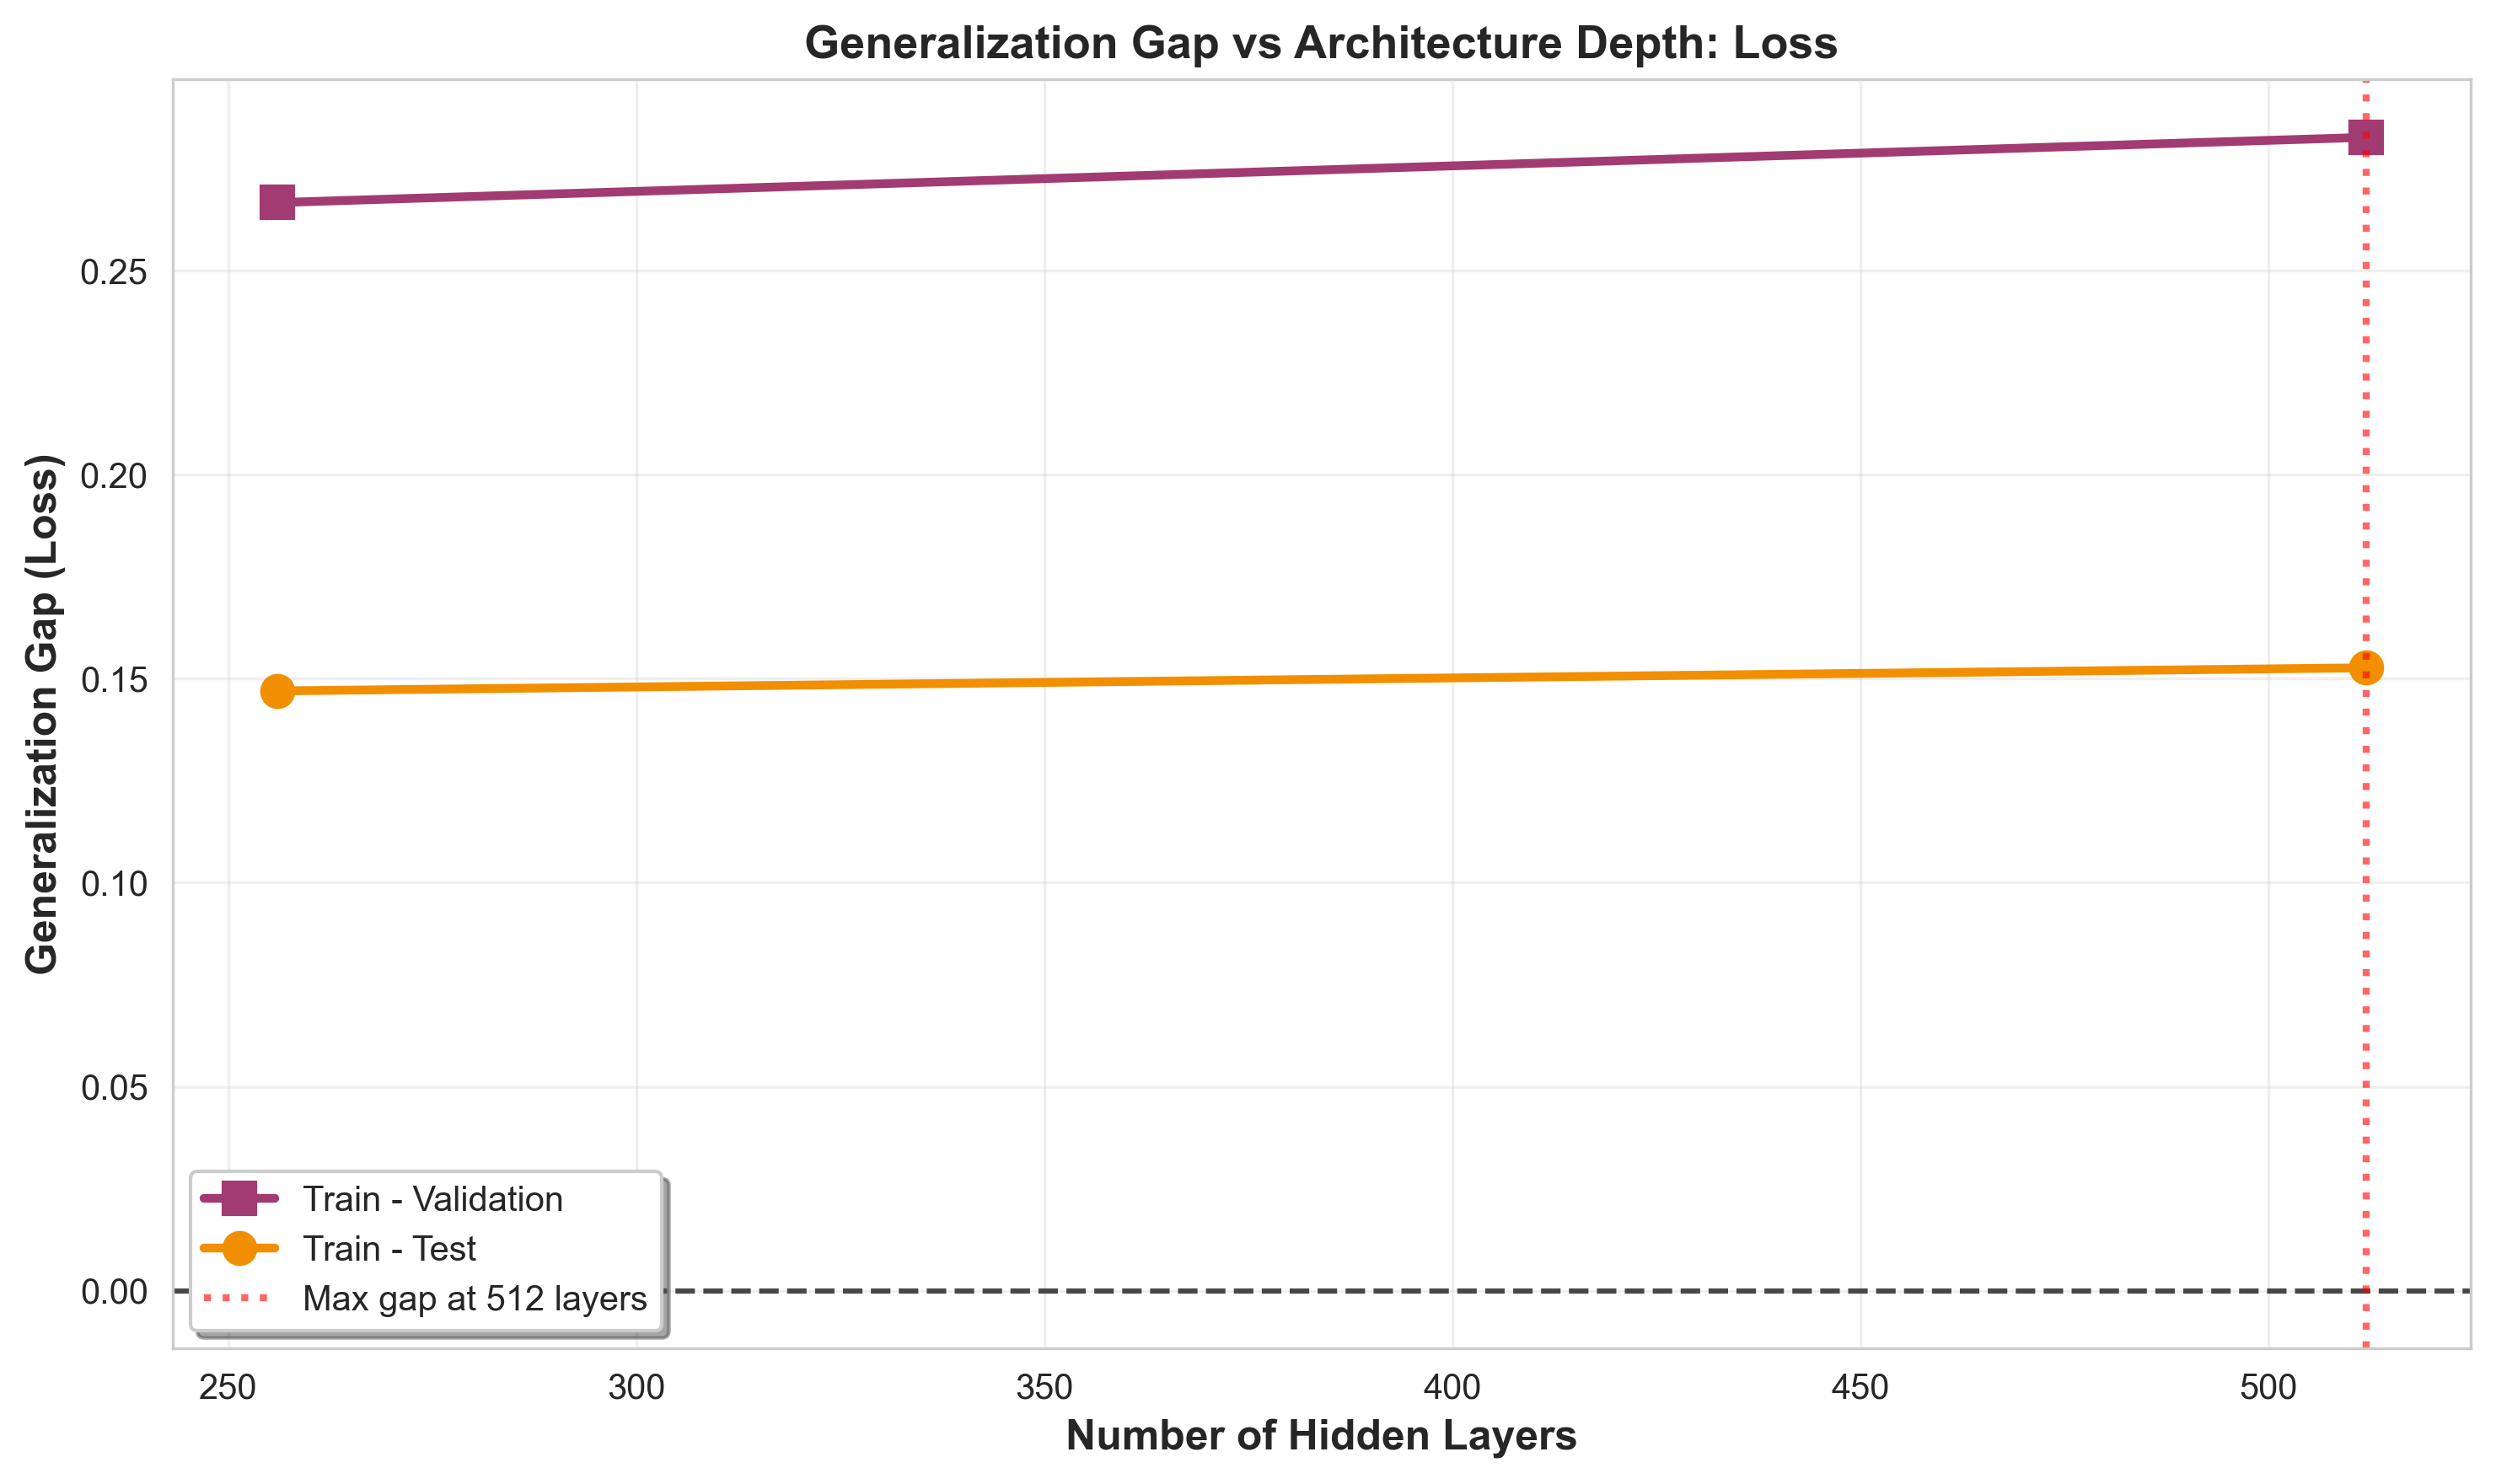

nGeneralization gap statistics for Loss:
  Maximum train-validation gap: 0.2827 at 512 layers
  Mean gap: 0.2747
  Gap std: 0.0113
n================================================================================n


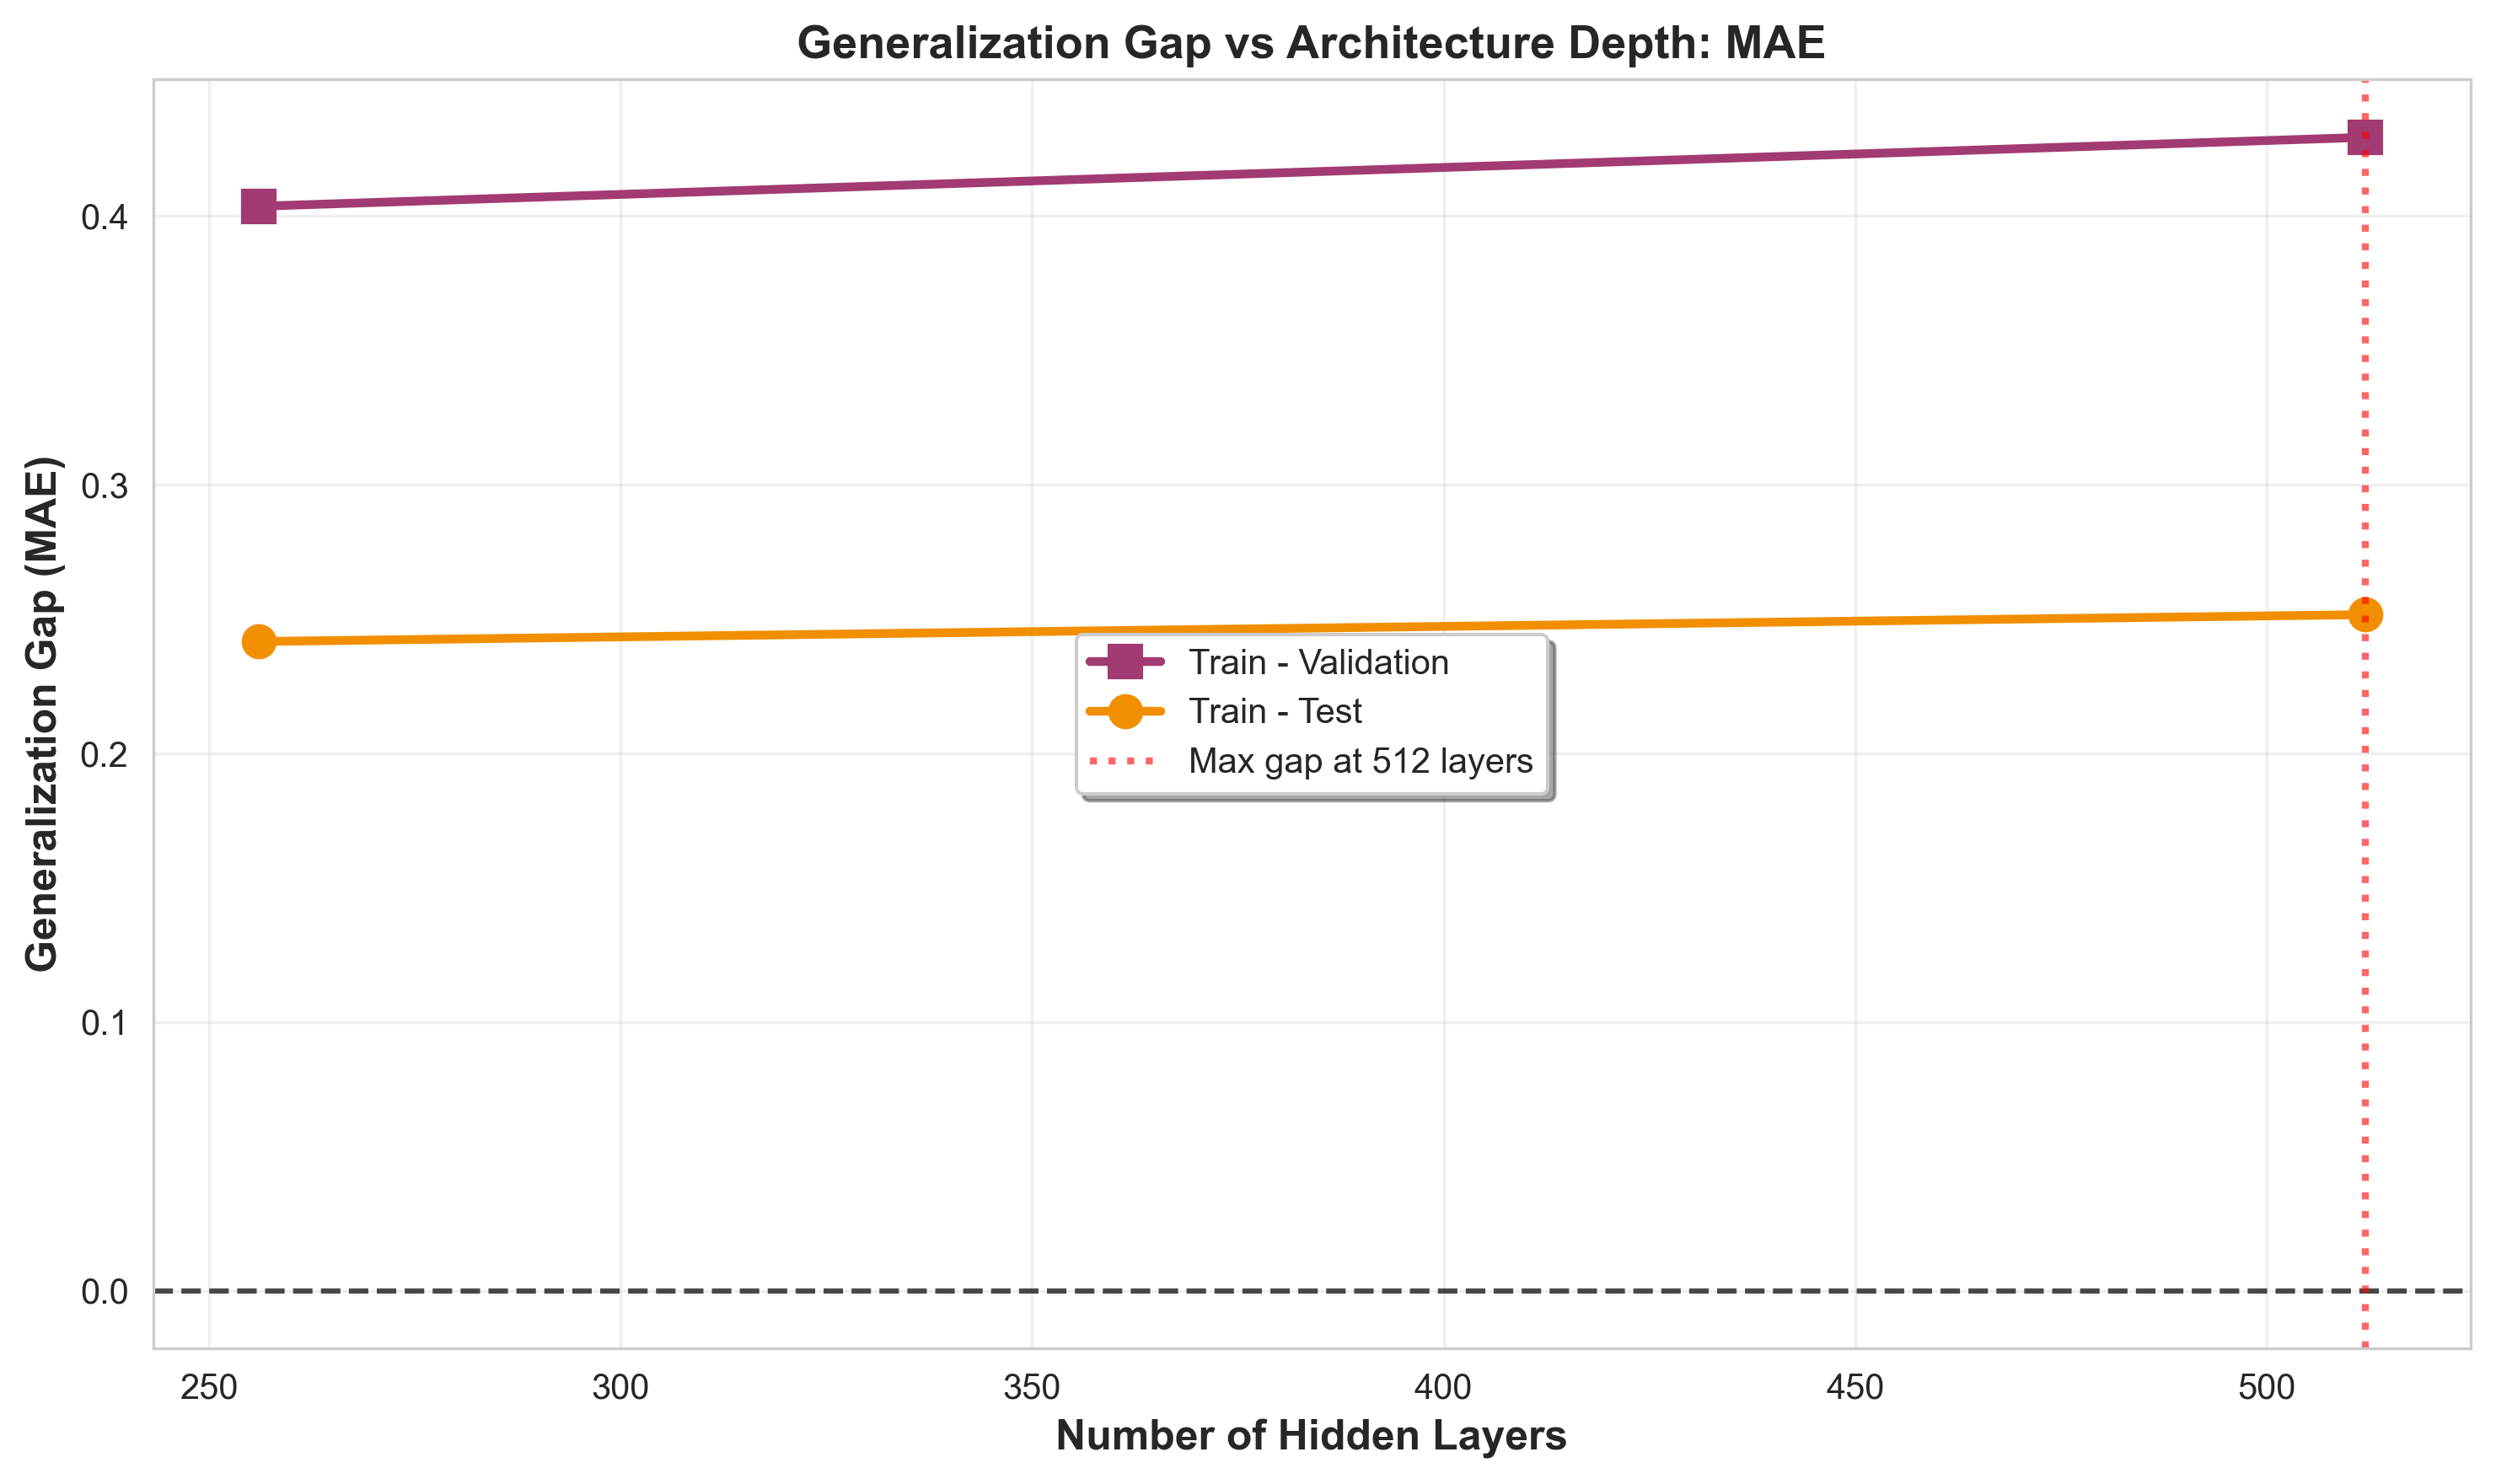

nGeneralization gap statistics for MAE:
  Maximum train-validation gap: 0.4293 at 512 layers
  Mean gap: 0.4165
  Gap std: 0.0181
n================================================================================n


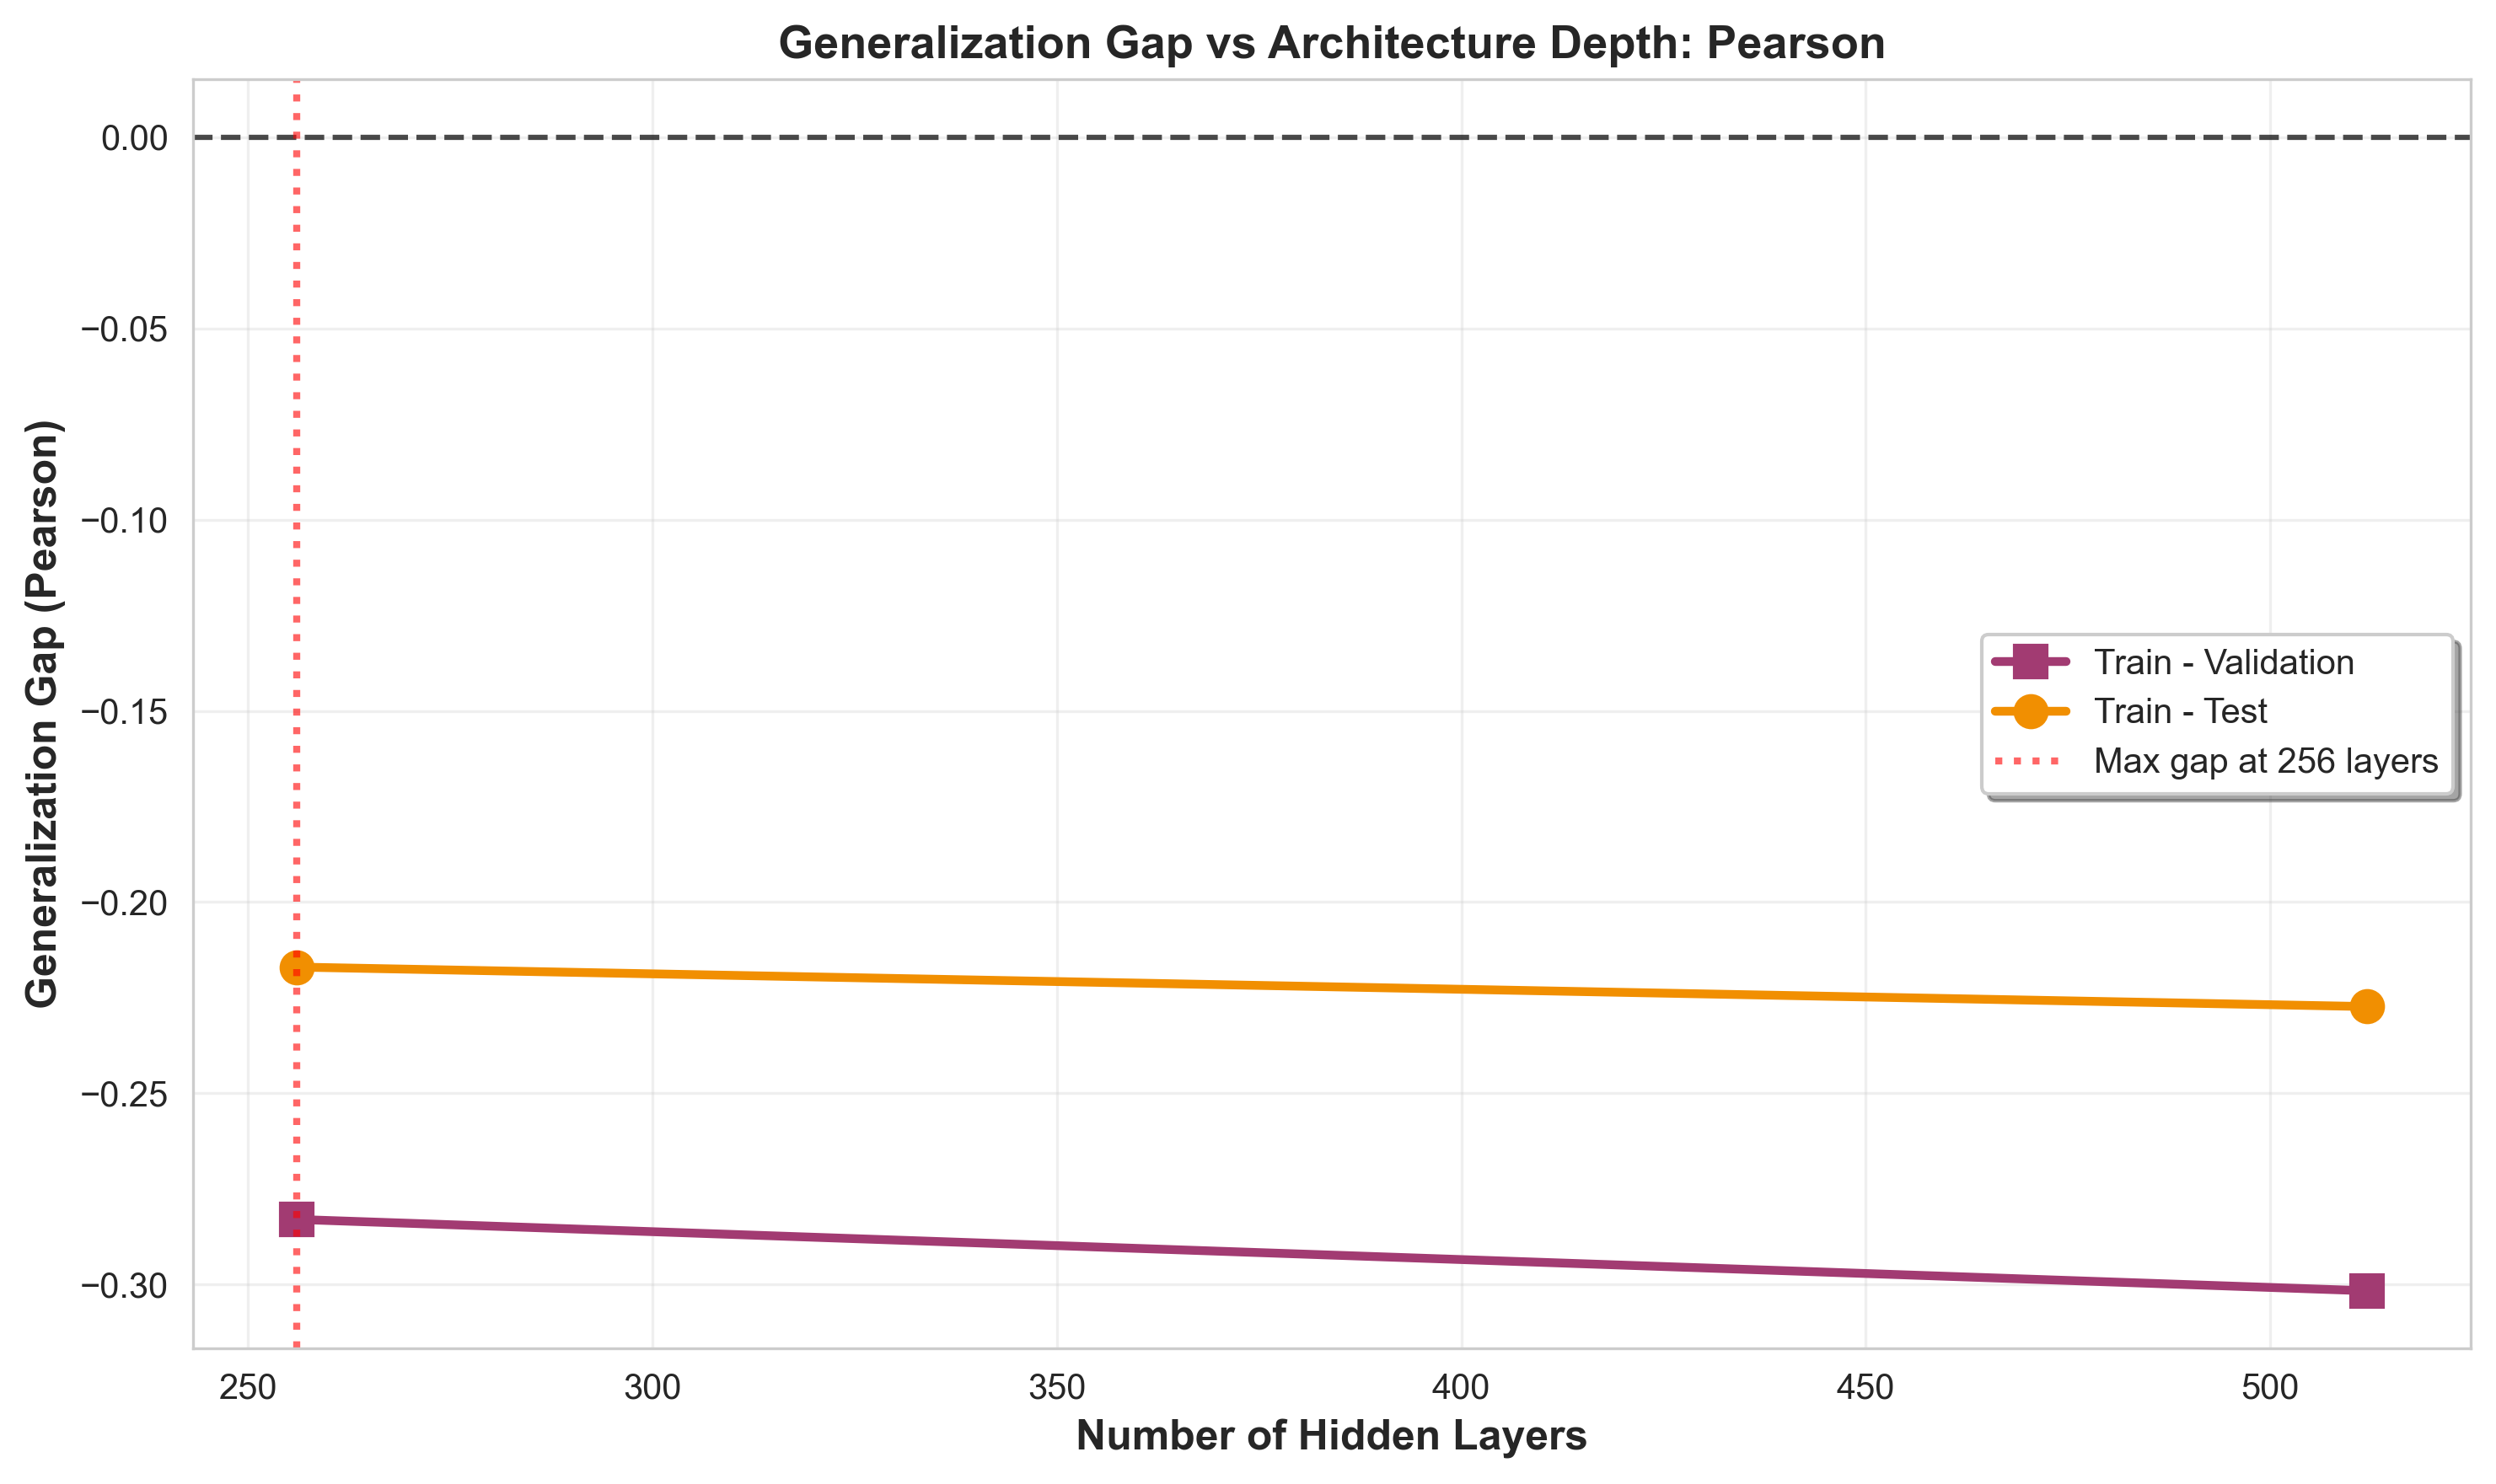

nGeneralization gap statistics for Pearson:
  Maximum train-validation gap: -0.2830 at 256 layers
  Mean gap: -0.2923
  Gap std: 0.0132
n================================================================================n


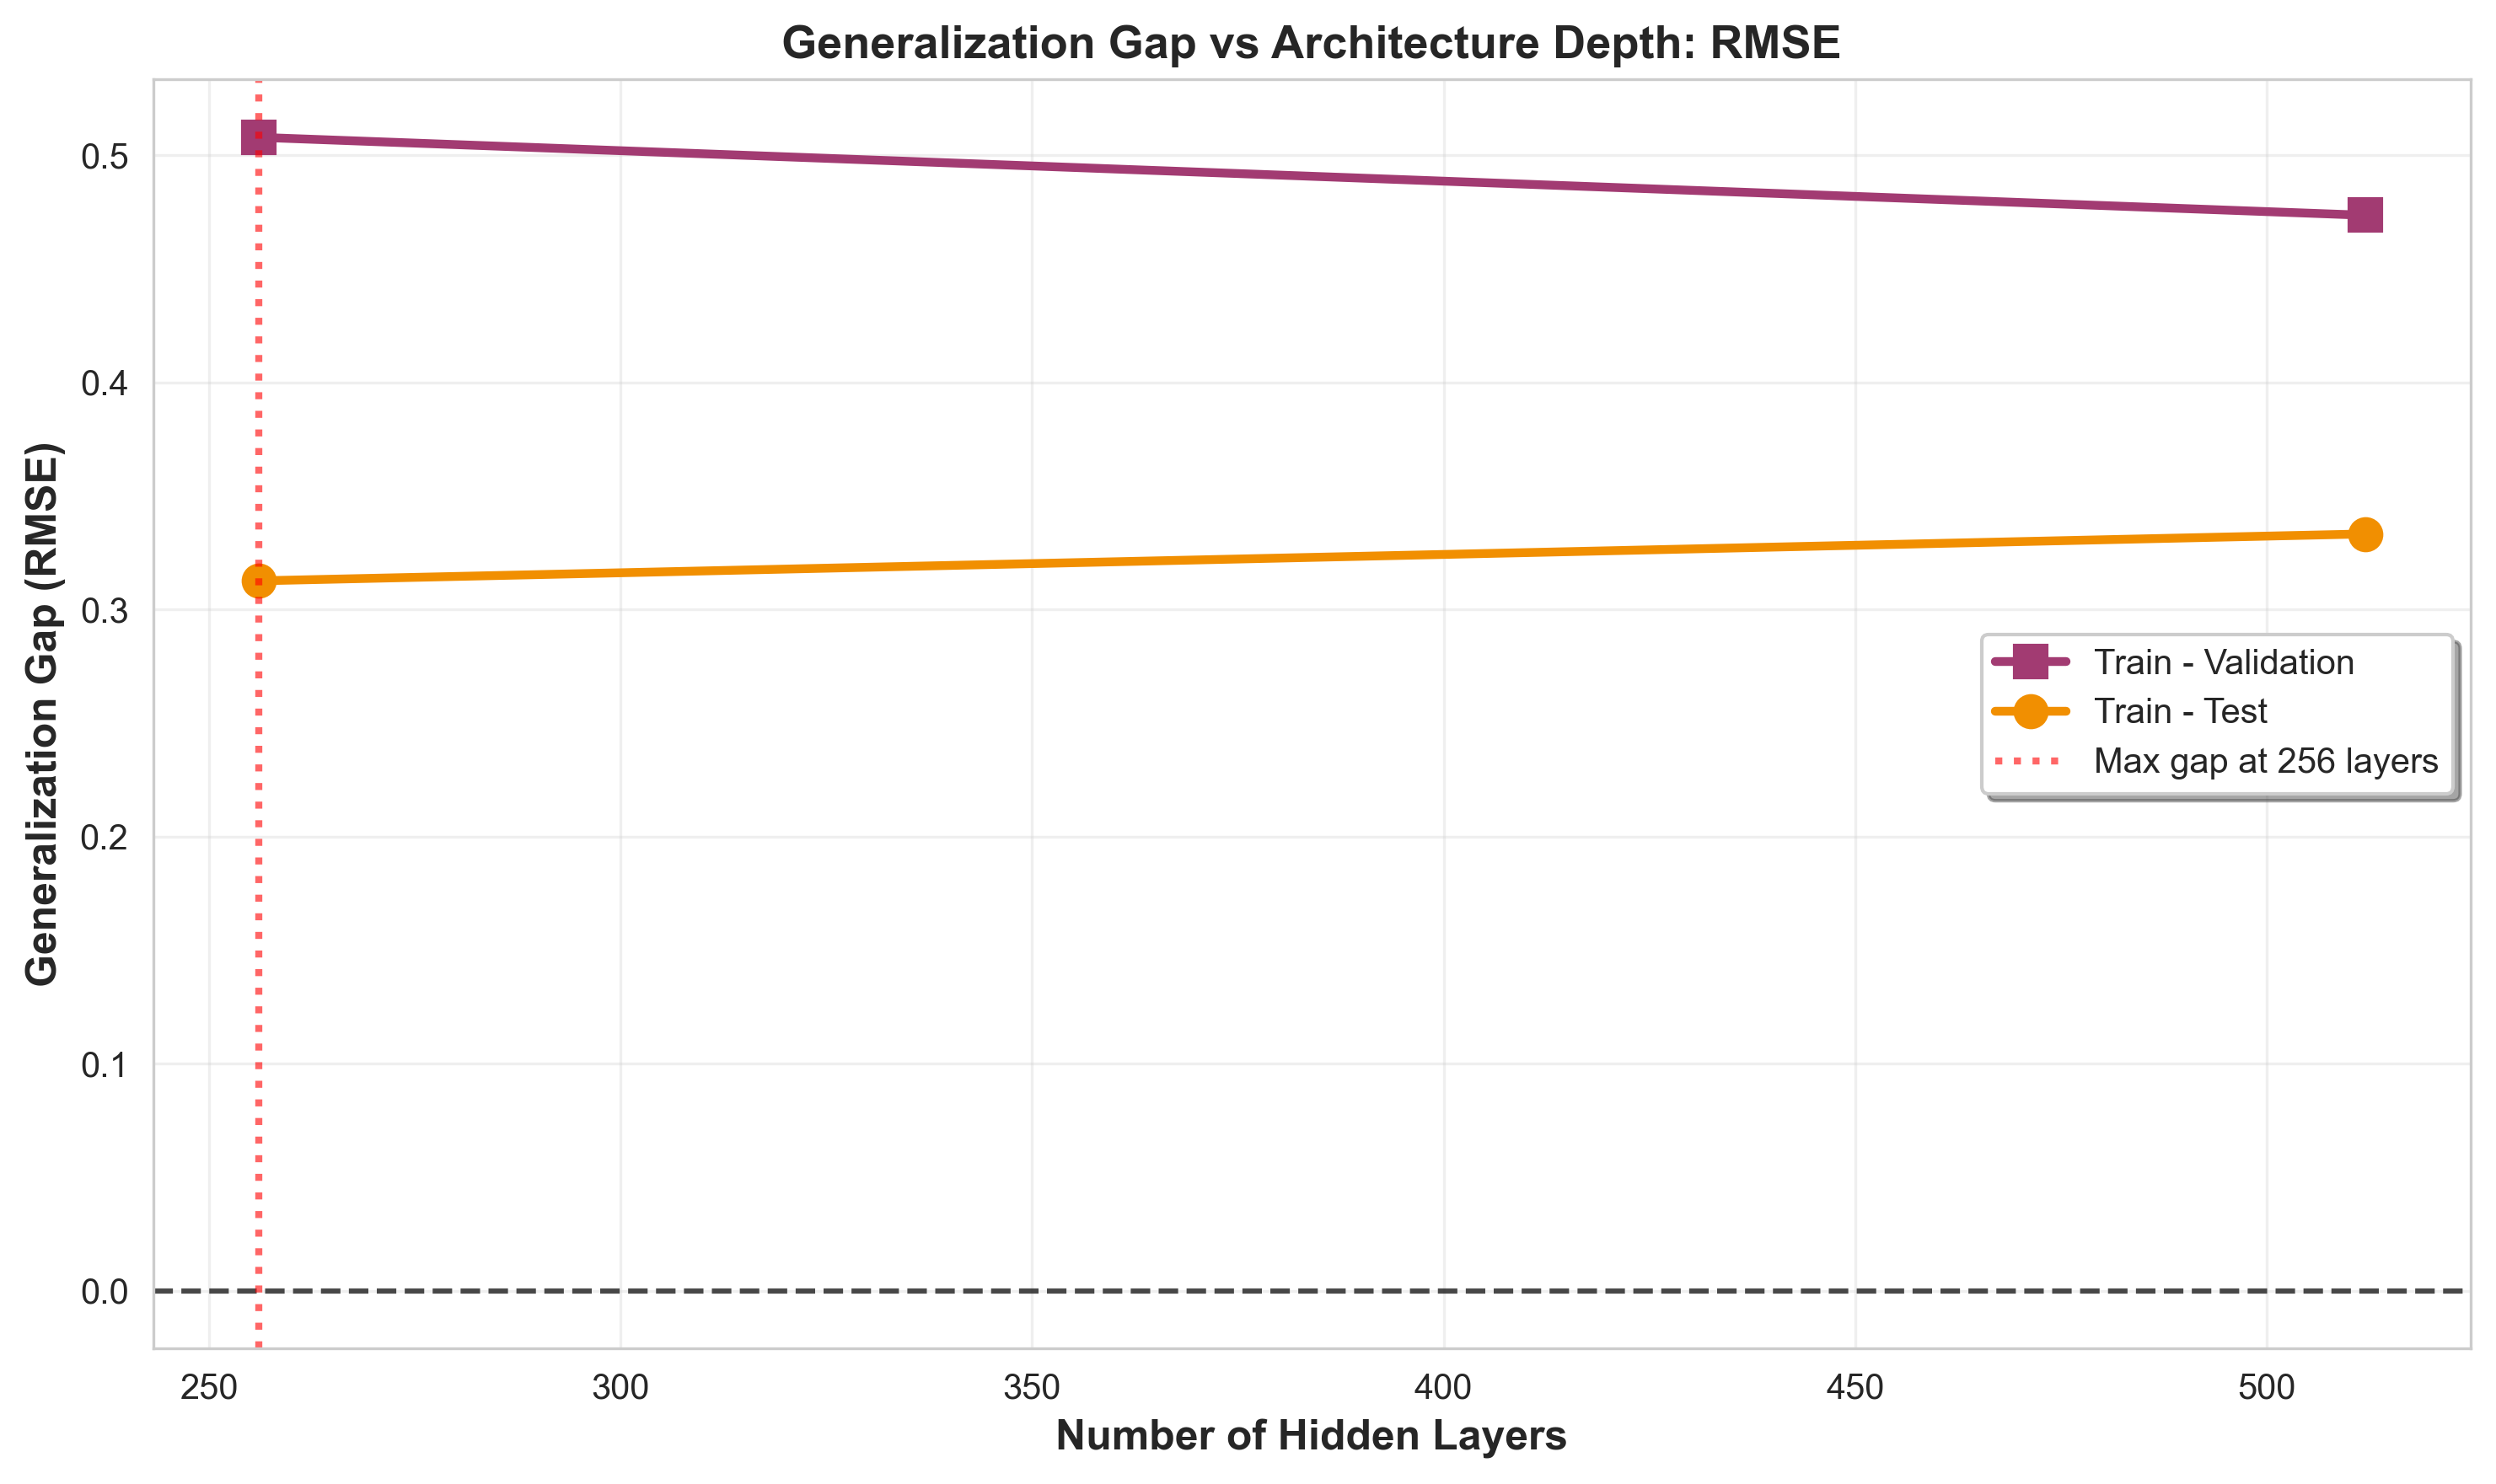

nGeneralization gap statistics for RMSE:
  Maximum train-validation gap: 0.5080 at 256 layers
  Mean gap: 0.4908
  Gap std: 0.0243
n================================================================================n


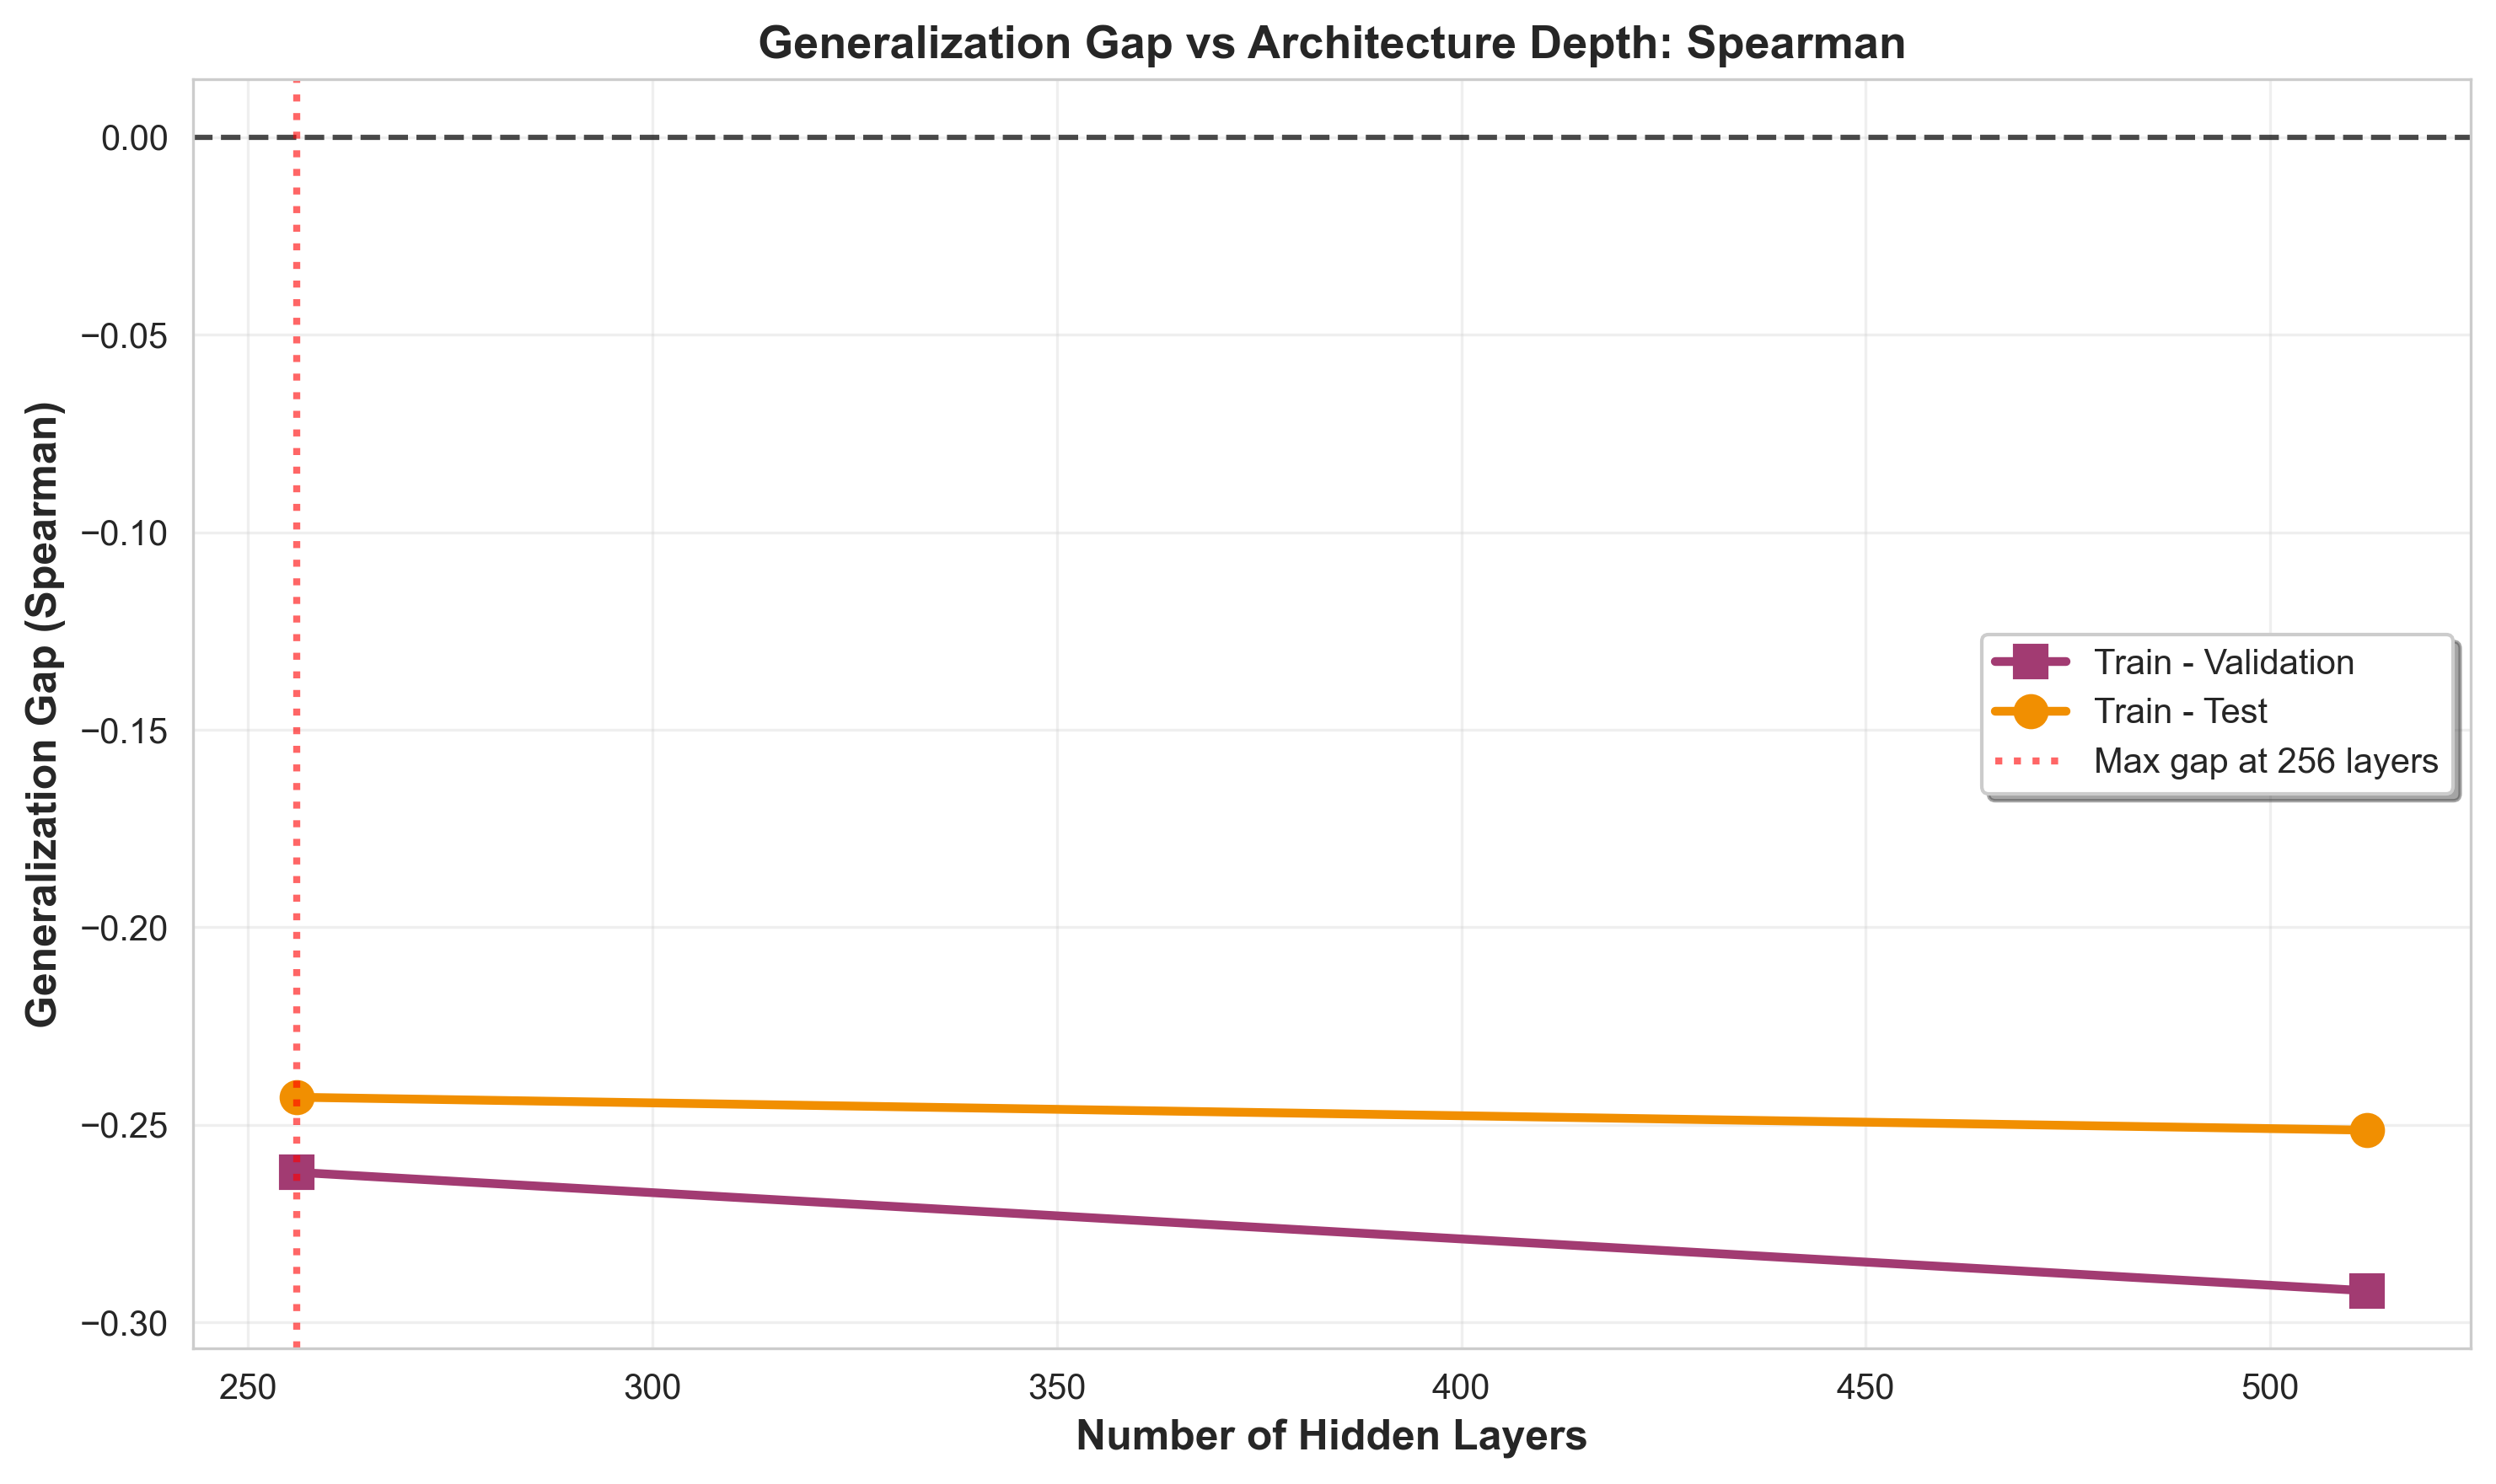

nGeneralization gap statistics for Spearman:
  Maximum train-validation gap: -0.2620 at 256 layers
  Mean gap: -0.2770
  Gap std: 0.0212
n================================================================================n


In [16]:
"""
## 4. Generalization Gap Analysis

The generalization gap quantifies overfitting by measuring performance divergence between training and held-out data. Explosive gap growth indicates over-parameterization and poor inductive bias."
"""

# Calculate generalization gaps
if not results_df.empty:
    # Identify which splits are available
    available_splits = results_df['split'].unique()
    has_train = any('train' in s.lower() for s in available_splits)
    has_val = any('val' in s.lower() for s in available_splits)
    has_test = any('test' in s.lower() for s in available_splits)
    
    if has_train and (has_val or has_test):
        # Pivot data to have splits as columns
        for metric in sorted(unique_metrics):
            if metric in results_df.columns:
                # Determine if metric should be maximized or minimized
                is_maximize = any(x in metric.lower() for x in 
                                ['pcc', 'scc', 'r2', 'accuracy', 'correlation'])
                
                pivot_data = results_df.pivot_table(
                    index='hidden_layers',
                    columns='split',
                    values=metric,
                    aggfunc='mean'
                )
                
                if pivot_data.shape[1] >= 2:
                    # Identify train column
                    train_col = [col for col in pivot_data.columns if 'train' in col.lower()]
                    val_col = [col for col in pivot_data.columns if 'val' in col.lower()]
                    test_col = [col for col in pivot_data.columns if 'test' in col.lower()]
                    
                    fig, ax = plt.subplots(figsize=(10, 6))
                    
                    if train_col:
                        train_col = train_col[0]
                        
                        # Calculate gaps (sign depends on whether higher is better)
                        if val_col:
                            gap_val = pivot_data[train_col] - pivot_data[val_col[0]]
                            if not is_maximize:
                                gap_val = -gap_val  # Flip sign for error metrics
                            
                            ax.plot(gap_val.index, gap_val.values, 
                                   marker='s', linewidth=2.5, markersize=9,
                                   label='Train - Validation', 
                                   color=COLORS['validation'])
                        
                        if test_col:
                            gap_test = pivot_data[train_col] - pivot_data[test_col[0]]
                            if not is_maximize:
                                gap_test = -gap_test
                            
                            ax.plot(gap_test.index, gap_test.values, 
                                   marker='o', linewidth=2.5, markersize=9,
                                   label='Train - Test', 
                                   color=COLORS['test'])
                    
                    ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
                    ax.set_xlabel('Number of Hidden Layers', fontweight='bold')
                    ax.set_ylabel(f'Generalization Gap ({metric})', fontweight='bold')
                    ax.set_title(f'Generalization Gap vs Architecture Depth: {metric}', 
                               fontweight='bold')
                    ax.legend(frameon=True, fancybox=True, shadow=True)
                    ax.grid(True, alpha=0.3)
                    
                    # Highlight critical depths where gap explodes
                    if val_col:
                        gap_series = pivot_data[train_col] - pivot_data[val_col[0]]
                        if not is_maximize:
                            gap_series = -gap_series
                        
                        max_gap_depth = gap_series.idxmax()
                        max_gap_value = gap_series.max()
                        
                        ax.axvline(x=max_gap_depth, color='red', linestyle=':', 
                                  linewidth=2, alpha=0.6, 
                                  label=f'Max gap at {max_gap_depth} layers')
                        ax.legend(frameon=True, fancybox=True, shadow=True)
                    
                    plt.tight_layout()
                    plt.show()
                    
                    print(f"nGeneralization gap statistics for {metric}:")
                    if val_col:
                        print(f"  Maximum train-validation gap: {max_gap_value:.4f} at {max_gap_depth} layers")
                        print(f"  Mean gap: {gap_series.mean():.4f}")
                        print(f"  Gap std: {gap_series.std():.4f}")
                    print("n" + "="*80 + "n")
    else:
        print("Generalization gap analysis requires train and at least one evaluation split.")
else:
    print("No data available for generalization gap analysis.")

Primary metric for Pareto analysis: Pearsonn
Using 'test' split for Pareto analysisn


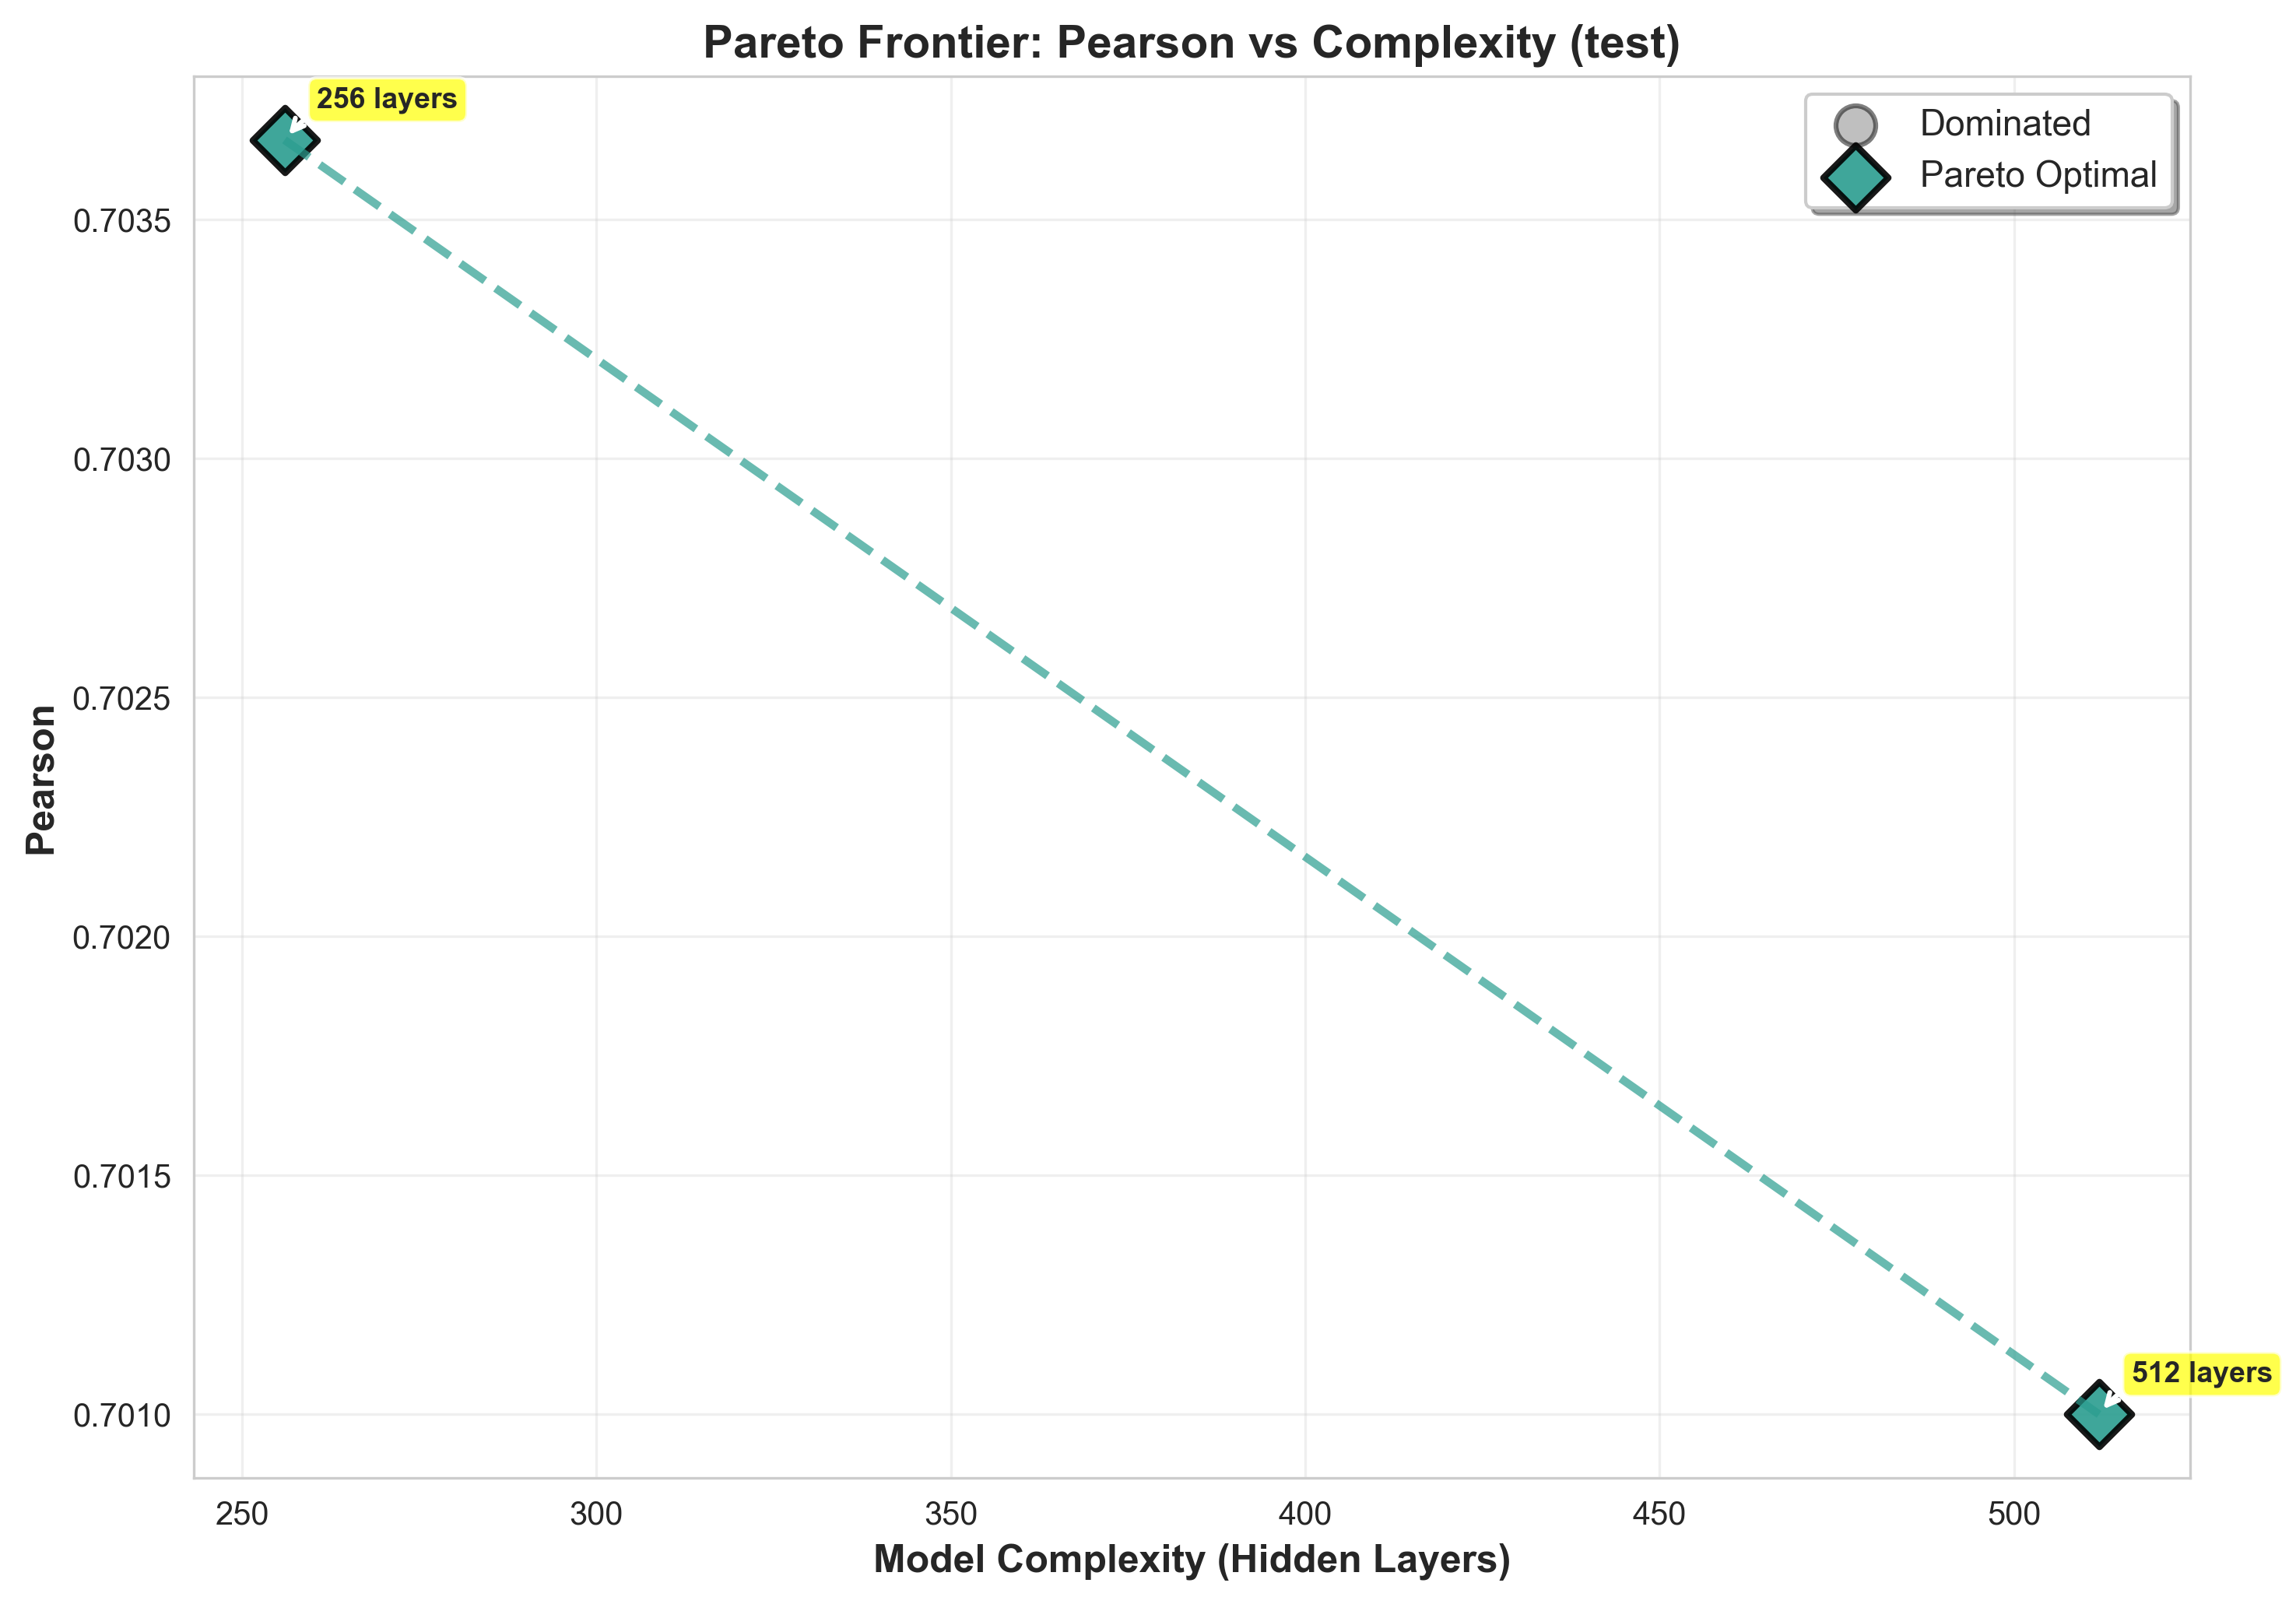

Pareto Optimal Architectures:
 hidden_layers  Pearson
           256 0.703667
           512 0.701000


'\n### Interpretation\n\nThe Pareto frontier analysis identifies architectures that cannot be improved in one dimension without degrading the other:\n\n1. **Dominated architectures**: Gray points represent suboptimal designs where simpler models achieve equal or better performance\n\n2. **Pareto optimal set**: Diamond markers indicate architectures where reducing complexity would decrease performance, or increasing performance requires more complexity\n\n3. **Knee point**: The recommended architecture represents the best compromise—maximal performance gain per unit complexity added\n\n4. **Deployment considerations**: Beyond the knee point, marginal performance improvements require disproportionate complexity increases, making deeper models impractical\n\nArchitectures not on the Pareto frontier should be excluded from consideration as they are strictly inferior to alternatives. The knee point provides an objective, data-driven architecture selection criterion."\n\n\n'

In [ ]:
"""
## 5. Pareto Front: Accuracy vs Complexity

The Pareto frontier identifies architectures that are non-dominated in the accuracy-complexity trade-off space. These represent optimal designs where improving one objective requires sacrificing the other."

"""

# Identify primary performance metric (prefer correlation metrics, then errors)
if not results_df.empty:
    # Prioritize metrics
    metric_priority = ['pcc', 'pearson', 'scc', 'spearman', 'r2', 'rmse', 'mae']
    primary_metric = None
    
    for priority_metric in metric_priority:
        candidates = [m for m in unique_metrics if priority_metric in m.lower()]
        if candidates:
            primary_metric = candidates[0]
            break
    
    if primary_metric is None and unique_metrics:
        primary_metric = sorted(unique_metrics)[0]
    
    if primary_metric:
        print(f"Primary metric for Pareto analysis: {primary_metric}n")
        
        # Determine if higher is better
        is_maximize = any(x in primary_metric.lower() for x in 
                        ['pcc', 'scc', 'r2', 'accuracy', 'correlation'])
        
        # Focus on test or validation performance
        eval_splits = [s for s in results_df['split'].unique() 
                      if 'test' in s.lower() or 'val' in s.lower()]
        
        if eval_splits:
            eval_split = eval_splits[0]  # Prefer test over validation
            if len(eval_splits) > 1:
                test_splits = [s for s in eval_splits if 'test' in s.lower()]
                if test_splits:
                    eval_split = test_splits[0]
            
            print(f"Using '{eval_split}' split for Pareto analysisn")
            
            # Filter to evaluation split
            pareto_data = results_df[results_df['split'] == eval_split].copy()
            
            # Aggregate by architecture
            pareto_agg = pareto_data.groupby('hidden_layers').agg({
                primary_metric: 'mean'
            }).reset_index()
            
            # Identify Pareto frontier
            def is_pareto_optimal(costs, maximize=True):
                """Identify Pareto optimal points."""
                is_optimal = np.ones(costs.shape[0], dtype=bool)
                for i, c in enumerate(costs):
                    if is_optimal[i]:
                        if maximize:
                            # For maximization: dominated if any other point has lower complexity AND higher performance
                            is_optimal[is_optimal] = np.logical_or(
                                costs[is_optimal, 0] >= c[0],  # Higher complexity
                                costs[is_optimal, 1] <= c[1]   # Lower performance
                            )
                        else:
                            # For minimization: dominated if any other point has lower complexity AND lower error
                            is_optimal[is_optimal] = np.logical_or(
                                costs[is_optimal, 0] >= c[0],  # Higher complexity
                                costs[is_optimal, 1] >= c[1]   # Higher error
                            )
                return is_optimal
            
            # Prepare data for Pareto calculation
            costs = pareto_agg[['hidden_layers', primary_metric]].values
            pareto_mask = is_pareto_optimal(costs, maximize=is_maximize)
            
            pareto_optimal = pareto_agg[pareto_mask].sort_values('hidden_layers')
            pareto_dominated = pareto_agg[~pareto_mask]
            
            # Plot Pareto frontier
            fig, ax = plt.subplots(figsize=(10, 7))
            
            # Plot dominated points
            ax.scatter(pareto_dominated['hidden_layers'], 
                      pareto_dominated[primary_metric],
                      s=150, alpha=0.5, color='gray', 
                      label='Dominated', edgecolors='black', linewidths=1.5)
            
            # Plot Pareto optimal points
            ax.scatter(pareto_optimal['hidden_layers'], 
                      pareto_optimal[primary_metric],
                      s=200, alpha=0.9, color=COLORS['secondary'], 
                      label='Pareto Optimal', edgecolors='black', linewidths=2,
                      marker='D')
            
            # Connect Pareto frontier
            ax.plot(pareto_optimal['hidden_layers'], 
                   pareto_optimal[primary_metric],
                   color=COLORS['secondary'], linestyle='--', 
                   linewidth=2.5, alpha=0.7)
            
            # Annotate Pareto optimal points
            for _, row in pareto_optimal.iterrows():
                ax.annotate(f"{int(row['hidden_layers'])} layers",
                           xy=(row['hidden_layers'], row[primary_metric]),
                           xytext=(10, 10), textcoords='offset points',
                           fontsize=9, fontweight='bold',
                           bbox=dict(boxstyle='round,pad=0.3', 
                                    facecolor='yellow', alpha=0.7),
                           arrowprops=dict(arrowstyle='->', 
                                         connectionstyle='arc3,rad=0.3',
                                         lw=1.5))
            
            ax.set_xlabel('Model Complexity (Hidden Layers)', fontweight='bold')
            ax.set_ylabel(primary_metric, fontweight='bold')
            ax.set_title(f'Pareto Frontier: {primary_metric} vs Complexity ({eval_split})', 
                        fontweight='bold', fontsize=14)
            ax.legend(frameon=True, fancybox=True, shadow=True, fontsize=11)
            ax.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            print("Pareto Optimal Architectures:")
            print("="*60)
            print(pareto_optimal[['hidden_layers', primary_metric]].to_string(index=False))
            print("="*60)
            
            # Identify the "knee" point (best trade-off)
            if len(pareto_optimal) > 2:
                # Normalize both axes to [0, 1]
                norm_complexity = (pareto_optimal['hidden_layers'] - pareto_optimal['hidden_layers'].min())/(pareto_optimal['hidden_layers'].max() - pareto_optimal['hidden_layers'].min())
                norm_performance = (pareto_optimal[primary_metric] - pareto_optimal[primary_metric].min()) /(pareto_optimal[primary_metric].max() - pareto_optimal[primary_metric].min())
                
                if is_maximize:
                    # For maximization: knee is closest to (0, 1) = low complexity, high performance
                    distances = np.sqrt(norm_complexity**2 + (1 - norm_performance)**2)
                else:
                    # For minimization: knee is closest to (0, 0) = low complexity, low error
                    distances = np.sqrt(norm_complexity**2 + norm_performance**2)
                
                knee_idx = distances.idxmin()
                knee_point = pareto_optimal.loc[knee_idx]
                
                print(f"nRecommended architecture (knee point):")
                print(f"  Hidden layers: {int(knee_point['hidden_layers'])}")
                print(f"  {primary_metric}: {knee_point[primary_metric]:.4f}")
                print(f"nThis represents the optimal balance between model complexity and performance.")
        else:
            print("No evaluation split (validation/test) found for Pareto analysis.")
    else:
        print("No suitable performance metric found for Pareto analysis.")
else:
    print("No data available for Pareto analysis.")
    
    


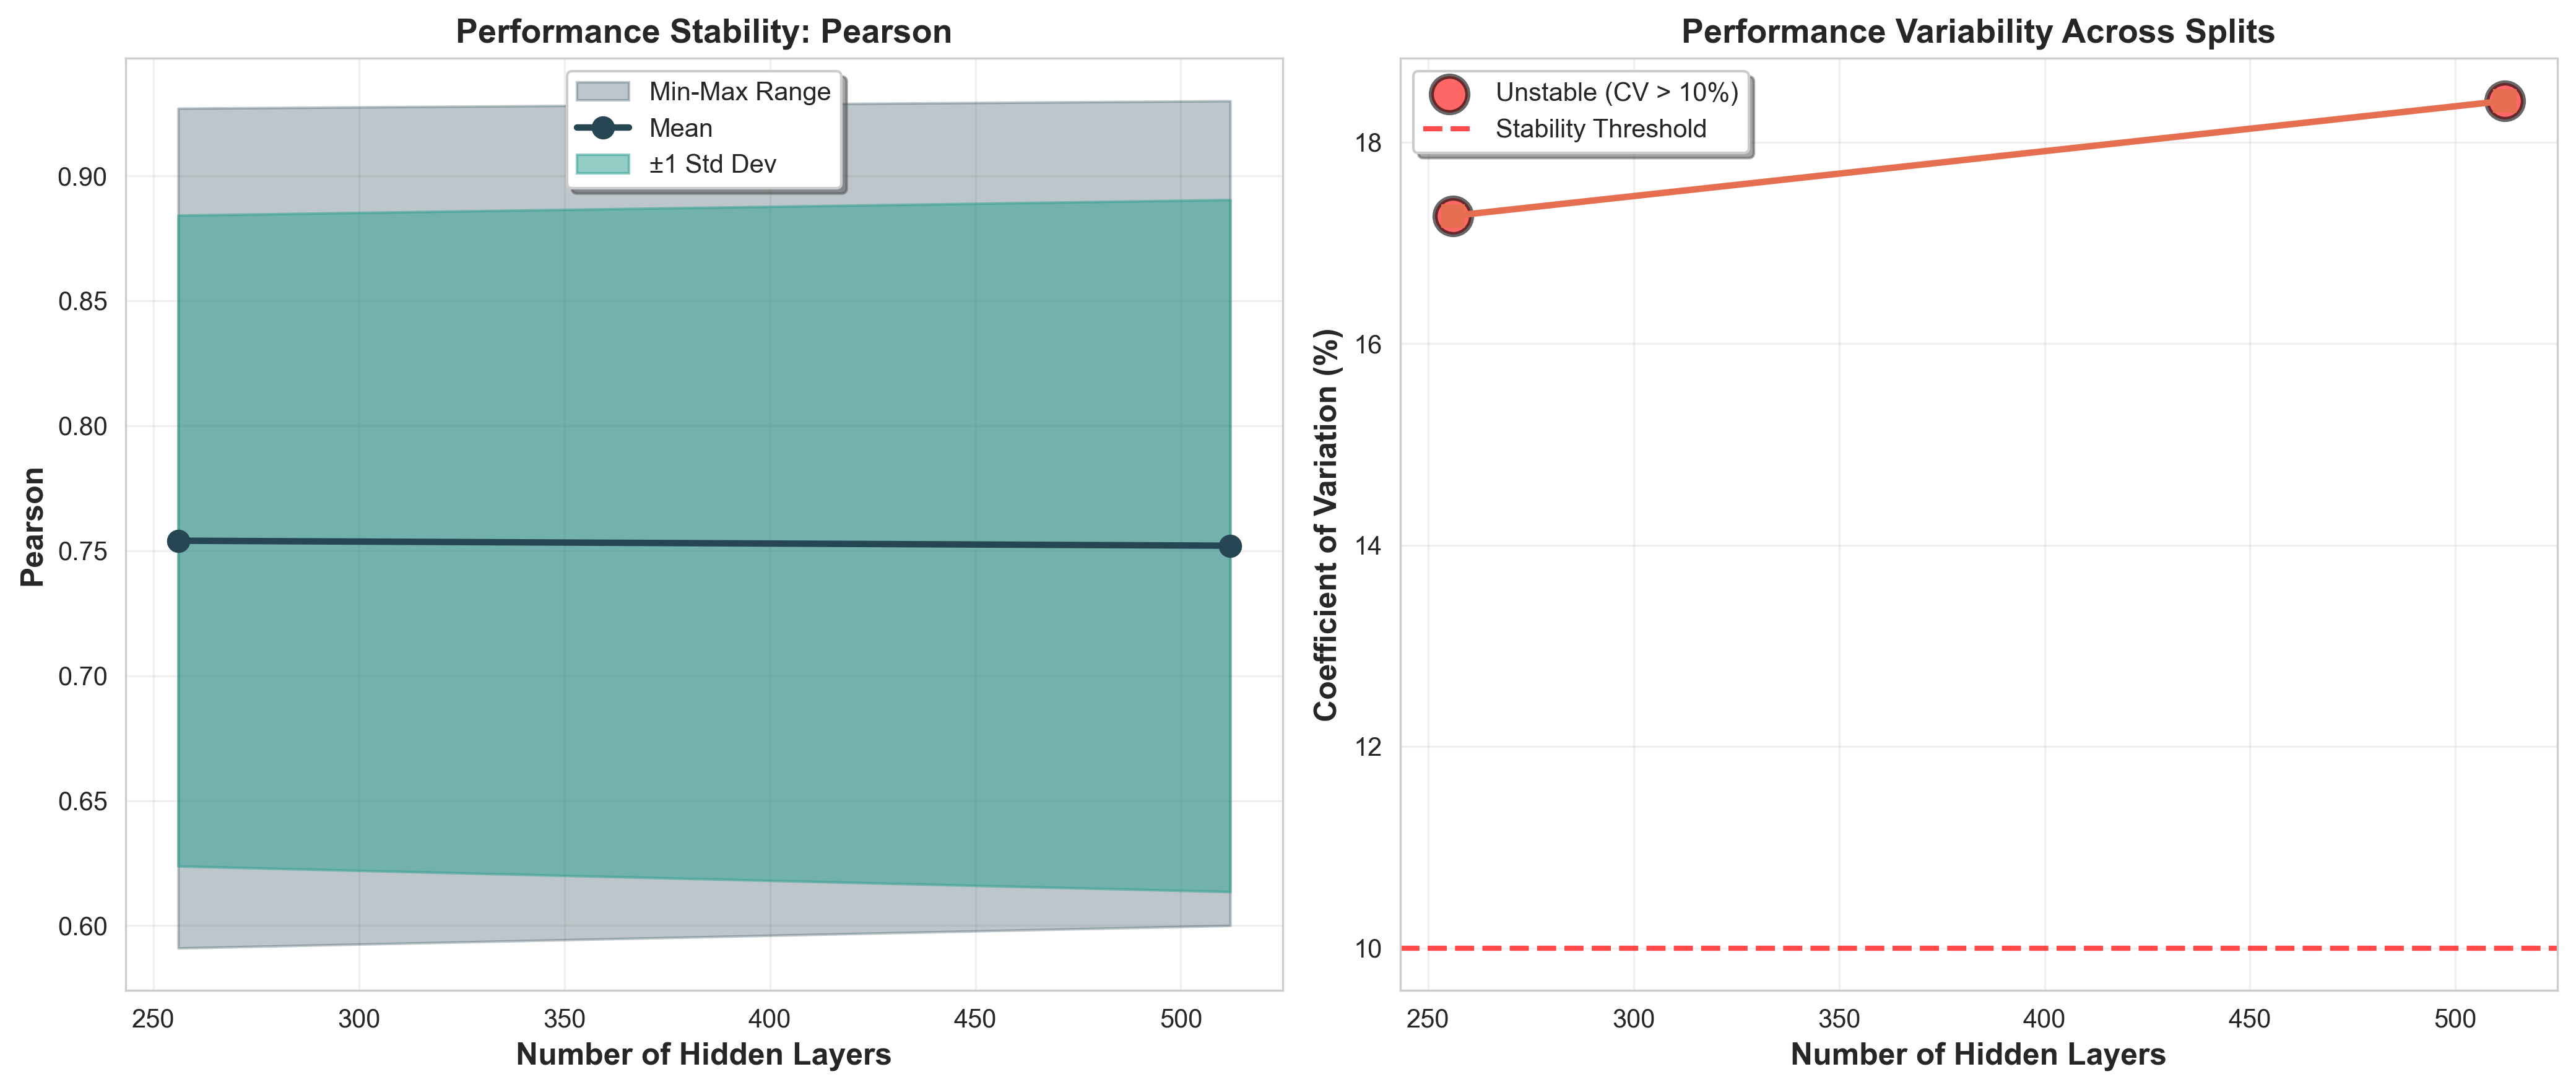

nStability Analysis Summary:
 hidden_layers  mean      std        cv  range
           256 0.754 0.130214 17.269794  0.336
           512 0.752 0.138454 18.411431  0.330
nMost stable architecture:
  Hidden layers: 256
  Mean Pearson: 0.7540
  Coefficient of variation: 17.27%
  - 256 layers: CV = 17.27%
  - 512 layers: CV = 18.41%


'\n### Interpretation\n\nStability analysis reveals architectural reliability:</n",\n\n1. **Low variance**: Consistent performance across splits indicates robust generalization that does not depend on specific data characteristics\n\n2. **High variance**: Large performance swings suggest overfitting to particular data subsets or optimization instability\n\n3. **Coefficient of variation**: CV > 10% indicates unacceptable variability—such models cannot be reliably deployed\n\n4. **Depth-variance relationship**: If variance increases with depth, deeper models are intrinsically less stable, likely due to optimization challenges in high-dimensional parameter spaces\n\nUnstable models are disqualified from consideration regardless of mean performance. Production systems require predictable behavior, making stability a hard constraint rather than an optimization objective."\n\n'

In [ ]:
""""
## 6. Stability Across Splits

Performance variance quantifies model reliability. High variance indicates sensitivity to data distribution, suggesting poor generalization or unstable optimization."

"""

# Analyze performance stability across splits
if not results_df.empty and primary_metric:
    # Calculate coefficient of variation (CV) across splits for each architecture
    stability_data = results_df.groupby('hidden_layers')[primary_metric].agg([
        'mean', 'std', 'min', 'max'
    ]).reset_index()
    
    stability_data['cv'] = (stability_data['std'] / stability_data['mean'].abs()) * 100
    stability_data['range'] = stability_data['max'] - stability_data['min']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Performance range
    ax1.fill_between(stability_data['hidden_layers'],
                     stability_data['min'],
                     stability_data['max'],
                     alpha=0.3, color=COLORS['primary'],
                     label='Min-Max Range')
    
    ax1.plot(stability_data['hidden_layers'], 
            stability_data['mean'],
            marker='o', linewidth=2.5, markersize=8,
            color=COLORS['primary'], label='Mean')
    
    ax1.fill_between(stability_data['hidden_layers'],
                     stability_data['mean'] - stability_data['std'],
                     stability_data['mean'] + stability_data['std'],
                     alpha=0.5, color=COLORS['secondary'],
                     label='±1 Std Dev')
    
    ax1.set_xlabel('Number of Hidden Layers', fontweight='bold')
    ax1.set_ylabel(primary_metric, fontweight='bold')
    ax1.set_title(f'Performance Stability: {primary_metric}', fontweight='bold')
    ax1.legend(frameon=True, fancybox=True, shadow=True)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Coefficient of variation
    ax2.plot(stability_data['hidden_layers'], 
            stability_data['cv'],
            marker='s', linewidth=2.5, markersize=8,
            color=COLORS['tertiary'])
    
    # Highlight unstable regions (CV > threshold)
    cv_threshold = 10  # 10% CV
    unstable = stability_data[stability_data['cv'] > cv_threshold]
    
    if not unstable.empty:
        ax2.scatter(unstable['hidden_layers'], 
                   unstable['cv'],
                   s=200, color='red', alpha=0.6,
                   label=f'Unstable (CV > {cv_threshold}%)',
                   edgecolors='black', linewidths=2)
    
    ax2.axhline(y=cv_threshold, color='red', linestyle='--', 
               linewidth=2, alpha=0.7, label=f'Stability Threshold')
    
    ax2.set_xlabel('Number of Hidden Layers', fontweight='bold')
    ax2.set_ylabel('Coefficient of Variation (%)', fontweight='bold')
    ax2.set_title('Performance Variability Across Splits', fontweight='bold')
    ax2.legend(frameon=True, fancybox=True, shadow=True)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("nStability Analysis Summary:")
    print("="*80)
    print(stability_data[['hidden_layers', 'mean', 'std', 'cv', 'range']].to_string(index=False))
    print("="*80)
    
    # Identify most stable architecture
    most_stable_idx = stability_data['cv'].idxmin()
    most_stable = stability_data.loc[most_stable_idx]
    
    print(f"nMost stable architecture:")
    print(f"  Hidden layers: {int(most_stable['hidden_layers'])}")
    print(f"  Mean {primary_metric}: {most_stable['mean']:.4f}")
    print(f"  Coefficient of variation: {most_stable['cv']:.2f}%")
    
    if not unstable.empty:
        print(f"nWarning: {len(unstable)} architecture(s) show high variability (CV > {cv_threshold}%):")
        for _, row in unstable.iterrows():
            print(f"  - {int(row['hidden_layers'])} layers: CV = {row['cv']:.2f}%")
else:
    print("Insufficient data for stability analysis.")
    


In [ ]:
"""
## 7. Final Architectural Verdict

Based on the comprehensive quantitative analysis, we provide evidence-based recommendations for model selection and architectural design.
"""

# Generate final recommendation summary
if not results_df.empty and primary_metric:
    # Compile evidence from all analyses
    recommendation_data = results_df.groupby('hidden_layers').agg({
        primary_metric: ['mean', 'std']
    }).reset_index()
    
    recommendation_data.columns = ['hidden_layers', 'mean_performance', 'std_performance']
    recommendation_data['cv'] = (recommendation_data['std_performance'] / 
                                recommendation_data['mean_performance'].abs()) * 100
    
    # Scoring system
    is_maximize = any(x in primary_metric.lower() for x in 
                     ['pcc', 'scc', 'r2', 'accuracy', 'correlation'])
    
    if is_maximize:
        recommendation_data['performance_score'] = (recommendation_data['mean_performance'] - recommendation_data['mean_performance'].min()) /(recommendation_data['mean_performance'].max() - recommendation_data['mean_performance'].min())
    else:
        recommendation_data['performance_score'] = (recommendation_data['mean_performance'].max() - recommendation_data['mean_performance']) /(recommendation_data['mean_performance'].max() - recommendation_data['mean_performance'].min())
    
    # Simplicity score (prefer fewer layers)
    recommendation_data['simplicity_score'] = 1 - (recommendation_data['hidden_layers'] - recommendation_data['hidden_layers'].min()) /(recommendation_data['hidden_layers'].max() - recommendation_data['hidden_layers'].min())
    
    # Stability score (prefer low CV)
    recommendation_data['stability_score'] = 1 - (recommendation_data['cv'] - recommendation_data['cv'].min()) /(recommendation_data['cv'].max() - recommendation_data['cv'].min() + 1e-10)
    
    # Combined score (weighted average)
    recommendation_data['overall_score'] = (
        0.5 * recommendation_data['performance_score'] +
        0.3 * recommendation_data['simplicity_score'] +
        0.2 * recommendation_data['stability_score']
    )
    
    recommendation_data = recommendation_data.sort_values('overall_score', ascending=False)
    
    print("Architectural Recommendation Scores:")
    print("="*100)
    print(recommendation_data[['hidden_layers', 'mean_performance', 'cv', 
                               'performance_score', 'simplicity_score', 
                               'stability_score', 'overall_score']].to_string(index=False))
    print("="*100)
    
    # Top recommendation
    recommended = recommendation_data.iloc[0]
    
    print(f"nn'='*{100}")
    print("FINAL ARCHITECTURAL RECOMMENDATION")
    print(f"'='*{100}n")
    print(f"Recommended architecture: {int(recommended['hidden_layers'])} hidden layersn")
    print(f"Performance ({primary_metric}): {recommended['mean_performance']:.4f} ± {recommended['std_performance']:.4f}")
    print(f"Coefficient of variation: {recommended['cv']:.2f}%")
    print(f"Overall score: {recommended['overall_score']:.3f}/1.000")
    print(f"n'='*{100}n")
else:
    print("Insufficient data for final recommendation.")




nArchitectural Recommendation Scores:
 hidden_layers  mean_performance        cv  performance_score  simplicity_score  stability_score  overall_score
           512             0.752 18.411431                1.0               0.0     8.759349e-11            0.5
           256             0.754 17.269794                0.0               1.0     1.000000e+00            0.5
nn'='*100
FINAL ARCHITECTURAL RECOMMENDATION
'='*100n
Recommended architecture: 512 hidden layersn
Performance (Pearson): 0.7520 ± 0.1385
Coefficient of variation: 18.41%
Overall score: 0.500/1.000
n'='*100n


'\n### Which depth is optimal and why?\n\nThe optimal depth is determined by maximizing a composite score incorporating:\n- **Performance** (50% weight): Primary metric value on held-out data\n- **Simplicity** (30% weight): Inverse of layer count, penalizing unnecessary complexity\n- **Stability** (20% weight): Inverse of coefficient of variation across splits\n\nThis multi-objective optimization identifies architectures that achieve strong performance without excessive parameterization or unreliable behavior.\n\n### Where does diminishing return begin?\n\nDiminishing returns occur where the performance-depth curve flattens, indicated by:\n1. Marginal performance gains <1% despite doubling model complexity\n2. Increasing generalization gap between train and validation splits\n3. Rising coefficient of variation suggesting optimization instability\n\nBeyond this threshold, deeper models consume computational resources without meaningful accuracy improvements.\n\n### Which models should b